In [1]:
import logging
logger = logging.Logger('catch_all')


def base64ToCSV_DataFrame(base64String):
    import base64 as b64
    import pandas as pd
    from io import StringIO

    try:
        csv = b64.b64decode(base64String).decode('utf-8')
        dataframe = pd.read_csv(StringIO(csv))

        return dataframe

    except Exception as e:
        logger.error(e, exc_info=True)
        return str(e)


# preparing independent and dependent features
def prepare_data(dataObject, n_steps):
    """This function accepts dataObject(list) and timeseries parameters as dict"""
    import numpy as np
    try:

        timeseries_data = dataObject

        X, y = [], []
        for i in range(len(timeseries_data)):
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(timeseries_data) - 1:
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
            X.append(seq_x)
            y.append(seq_y)

        return np.array(X), np.array(y)

    except Exception as e:
        logger.error(e, exc_info=True)
        return str(e)

In [2]:
import logging

logger = logging.Logger('catch_all')


# demonstrate prediction for next N days(n_pred)
def prediction(model, input_sequence, n_steps, n_pred):
    """This function accepts model,input_sequence and parameters as dict"""
    import numpy as np

    try:
        # demonstrate prediction for next N days
        n_features = 1
        input_sequence = np.array(input_sequence)
        # temporary sequence to updated with new pred
        new_sequence = list(input_sequence)
        # predicted n_pred sequence
        output_sequence = []
        i = 0
        while i < n_pred:
            if len(new_sequence) > n_steps:
                input_sequence = np.array(new_sequence[1:])
                input_sequence = input_sequence.reshape((1, n_steps, n_features))
                prediction = model.predict(input_sequence, verbose=0)
                new_sequence.append(prediction[0][0])
                new_sequence = new_sequence[1:]
                output_sequence.append(prediction[0][0])
                i = i + 1
            else:
                input_sequence = input_sequence.reshape((1, n_steps, n_features))
                prediction = model.predict(input_sequence, verbose=0)
                new_sequence.append(prediction[0][0])
                output_sequence.append(prediction[0][0])
                i = i + 1

        return output_sequence

    except Exception as e:
        logger.error(e, exc_info=True)
        return str(e)


In [3]:
import logging

logger = logging.Logger('catch_all')


# define the model
def train(input_data, hyperParameters):
    """This function accepts input data and  hyperParameters as dict"""
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM
    from tensorflow.keras.layers import Dense, Dropout
    from sklearn.metrics import mean_squared_error
    import math
    import json
    from sklearn.preprocessing import MinMaxScaler
    import numpy as np

    try:
        targetParameter = hyperParameters.get('targetParameter')
        datecolumn = hyperParameters.get('datecolumn')
        train_test_ratio = float(hyperParameters.get('train_test_ratio'))
        n_steps = int(hyperParameters.get('n_steps'))
        nodes = int(hyperParameters.get('nodes'))
        activation = hyperParameters.get('activation')
        optimizer = hyperParameters.get('optimizer')
        epochs = int(hyperParameters.get('epochs'))
        n_features = 1

        dataframe = base64ToCSV_DataFrame(input_data)
        """reading data from particular column/parameter in consideration"""
        temp_train = dataframe[targetParameter].tolist()
        
        amin, amax = min(temp_train), max(temp_train)
        for i, val in enumerate(temp_train):
            temp_train[i] = (val-amin) / (amax-amin)


        noTestSamples = round((1 - train_test_ratio) * len(temp_train))
        n_pred = noTestSamples

        """dividing into train and test"""
        testSequence = temp_train[-noTestSamples:]
        trainSequence = temp_train[:-noTestSamples]

        """preparing input sequence for testing"""
        lastWindowSequence = trainSequence[-n_steps:]

        """converting into time series format"""
        X, y = prepare_data(trainSequence, n_steps)

        """reshape timeseries data according to tne model input layer"""
        X = X.reshape((X.shape[0], X.shape[1], n_features))

        """define model"""
        model_lstm = Sequential()
        model_lstm.add(LSTM(nodes, activation=activation, return_sequences=True, input_shape=(n_steps, n_features)))
        model_lstm.add(LSTM(nodes, activation=activation))
        model_lstm.add(Dense(1))
        model_lstm.compile(optimizer=optimizer, loss='mse')
        
        """training the model"""
        model_lstm.fit(X, y, epochs=epochs, verbose=2)

        """prediction """
        output = prediction(model_lstm, lastWindowSequence, n_steps, n_pred)
        print(output)
         
        for i, val in enumerate(testSequence):
            testSequence[i] = (val*(amax-amin))+amin
            
        for i, val in enumerate(output):
            output[i] = (val*(amax-amin))+amin
            
        
        rmse = math.sqrt(mean_squared_error(testSequence, output))
        print(rmse)

        """preparing dataframe for response"""
        outputDataframe = dataframe[[datecolumn, targetParameter]]
        outputDataframe = outputDataframe[-noTestSamples:]
        outputDataframe['Predicted'] = output
        outputDataframe.rename(columns={datecolumn: 'Date', targetParameter: 'Original'}, inplace=True)
        print(outputDataframe)

        response = dict()
        response['data'] = json.loads(outputDataframe.to_json(orient='records', date_format='iso'))
        response['error'] = rmse
        return response,rmse,testSequence, output, noTestSamples,temp_train

    except Exception as e:
        logger.error(e, exc_info=True)
        return 0, str(e)


In [4]:

file = "ZGF0ZSxtZWFudGVtcCxodW1pZGl0eSx3aW5kX3NwZWVkLG1lYW5wcmVzc3VyZQoyMDEzLTAxLTAxLDEwLjAsODQuNSwwLjAsMTAxNS42NjY2NjY2NjY2NjY2CjIwMTMtMDEtMDIsNy40LDkyLjAsMi45OCwxMDE3LjgKMjAxMy0wMS0wMyw3LjE2NjY2NjY2NjY2NjY2Nyw4Ny4wLDQuNjMzMzMzMzMzMzMzMzM0LDEwMTguNjY2NjY2NjY2NjY2NgoyMDEzLTAxLTA0LDguNjY2NjY2NjY2NjY2NjY2LDcxLjMzMzMzMzMzMzMzMzMzLDEuMjMzMzMzMzMzMzMzMzMzNCwxMDE3LjE2NjY2NjY2NjY2NjYKMjAxMy0wMS0wNSw2LjAsODYuODMzMzMzMzMzMzMzMzMsMy42OTk5OTk5OTk5OTk5OTk3LDEwMTYuNQoyMDEzLTAxLTA2LDcuMCw4Mi44LDEuNDgsMTAxOC4wCjIwMTMtMDEtMDcsNy4wLDc4LjYsNi4zLDEwMjAuMAoyMDEzLTAxLTA4LDguODU3MTQyODU3MTQyODU4LDYzLjcxNDI4NTcxNDI4NTcxNSw3LjE0Mjg1NzE0Mjg1NzE0MywxMDE4LjcxNDI4NTcxNDI4NTcKMjAxMy0wMS0wOSwxNC4wLDUxLjI1LDEyLjUsMTAxNy4wCjIwMTMtMDEtMTAsMTEuMCw2Mi4wLDcuMzk5OTk5OTk5OTk5OTk5NSwxMDE1LjY2NjY2NjY2NjY2NjYKMjAxMy0wMS0xMSwxNS43MTQyODU3MTQyODU3MTQsNTEuMjg1NzE0Mjg1NzE0Mjg1LDEwLjU3MTQyODU3MTQyODU3MSwxMDE2LjE0Mjg1NzE0Mjg1NzEKMjAxMy0wMS0xMiwxNC4wLDc0LjAsMTMuMjI4NTcxNDI4NTcxNDI4LDEwMTUuNTcxNDI4NTcxNDI4NgoyMDEzLTAxLTEzLDE1LjgzMzMzMzMzMzMzMzMzNCw3NS4xNjY2NjY2NjY2NjY2Nyw0LjYzMzMzMzMzMzMzMzMzNCwxMDEzLjMzMzMzMzMzMzMzMzQKMjAxMy0wMS0xNCwxMi44MzMzMzMzMzMzMzMzMzQsODguMTY2NjY2NjY2NjY2NjcsMC42MTY2NjY2NjY2NjY2NjY3LDEwMTUuMTY2NjY2NjY2NjY2NgoyMDEzLTAxLTE1LDE0LjcxNDI4NTcxNDI4NTcxNCw3MS44NTcxNDI4NTcxNDI4NiwwLjUyODU3MTQyODU3MTQyODYsMTAxNS44NTcxNDI4NTcxNDI5CjIwMTMtMDEtMTYsMTMuODMzMzMzMzMzMzMzMzM0LDg2LjY2NjY2NjY2NjY2NjY3LDAuMCwxMDE2LjY2NjY2NjY2NjY2NjYKMjAxMy0wMS0xNywxNi41LDgwLjgzMzMzMzMzMzMzMzMzLDUuMjUwMDAwMDAwMDAwMDAxLDEwMTUuODMzMzMzMzMzMzMzNAoyMDEzLTAxLTE4LDEzLjgzMzMzMzMzMzMzMzMzNCw5Mi4xNjY2NjY2NjY2NjY2Nyw4Ljk1MDAwMDAwMDAwMDAwMSwxMDE0LjUKMjAxMy0wMS0xOSwxMi41LDc2LjY2NjY2NjY2NjY2NjY3LDUuODgzMzMzMzMzMzMzMzMzLDEwMjEuNjY2NjY2NjY2NjY2NgoyMDEzLTAxLTIwLDExLjI4NTcxNDI4NTcxNDI4Niw3NS4yODU3MTQyODU3MTQyOSw4LjQ3MTQyODU3MTQyODU3MiwxMDIwLjI4NTcxNDI4NTcxNDMKMjAxMy0wMS0yMSwxMS4yLDc3LjAsMi4yMiwxMDIxLjAKMjAxMy0wMS0yMiw5LjUsNzkuNjY2NjY2NjY2NjY2NjcsMy4wODMzMzMzMzMzMzMzMzM1LDEwMjEuOAoyMDEzLTAxLTIzLDE0LjAsNjAuMTY2NjY2NjY2NjY2NjY0LDQuMDE2NjY2NjY2NjY2NjY3LDEwMjAuNQoyMDEzLTAxLTI0LDEzLjgzMzMzMzMzMzMzMzMzNCw2MC42NjY2NjY2NjY2NjY2NjQsNi4xNjY2NjY2NjY2NjY2NjcsMTAyMC41CjIwMTMtMDEtMjUsMTIuMjUsNjcuMCw1LjU1LDEwMjAuNzUKMjAxMy0wMS0yNiwxMi42NjY2NjY2NjY2NjY2NjYsNjQuMTY2NjY2NjY2NjY2NjcsNi44MDAwMDAwMDAwMDAwMDEsMTAxOS42NjY2NjY2NjY2NjY2CjIwMTMtMDEtMjcsMTIuODU3MTQyODU3MTQyODU4LDY1LjU3MTQyODU3MTQyODU3LDUuNTU3MTQyODU3MTQyODU3LDEwMTguMTQyODU3MTQyODU3MQoyMDEzLTAxLTI4LDE0LjgzMzMzMzMzMzMzMzMzNCw1Ni4wLDMuNjk5OTk5OTk5OTk5OTk5NywxMDE3LjgzMzMzMzMzMzMzMzQKMjAxMy0wMS0yOSwxNC4xMjUsNjUuNSwzLjIzNzUsMTAxNi42MjUKMjAxMy0wMS0zMCwxNC43MTQyODU3MTQyODU3MTQsNzAuNDI4NTcxNDI4NTcxNDMsMS4wNTcxNDI4NTcxNDI4NTcyLDEwMTcuODU3MTQyODU3MTQyOQoyMDEzLTAxLTMxLDE2LjIsNjUuNiwyLjk2LDEwMTguNAoyMDEzLTAyLTAxLDE2LjAsNzMuMCwyLjIyLDEwMTYuMAoyMDEzLTAyLTAyLDE2LjI4NTcxNDI4NTcxNDI4NSw3Ny41NzE0Mjg1NzE0Mjg1NywxLjMyODU3MTQyODU3MTQyODcsMTAxNy4xNDI4NTcxNDI4NTcxCjIwMTMtMDItMDMsMTguMCw2NS41NzE0Mjg1NzE0Mjg1NywxLjg1NzE0Mjg1NzE0Mjg1NzIsMTAxNS4yODU3MTQyODU3MTQzCjIwMTMtMDItMDQsMTcuNDI4NTcxNDI4NTcxNDI3LDc0LjI4NTcxNDI4NTcxNDI5LDExLjExNDI4NTcxNDI4NTcxNCwxMDE0LjU3MTQyODU3MTQyODYKMjAxMy0wMi0wNSwxNi42MjUsOTIuMzc1LDkuNzI1MDAwMDAwMDAwMDAxLDEwMTYuMzc1CjIwMTMtMDItMDYsMTYuNjY2NjY2NjY2NjY2NjY4LDcxLjMzMzMzMzMzMzMzMzMzLDguNjMzMzMzMzMzMzMzMzMzLDEwMTguNjY2NjY2NjY2NjY2NgoyMDEzLTAyLTA3LDE1LjYsNTkuNCwxMC43NCwxMDE4LjYKMjAxMy0wMi0wOCwxNC4wLDcwLjQyODU3MTQyODU3MTQzLDkuMjU3MTQyODU3MTQyODU2LDEwMTcuMTQyODU3MTQyODU3MQoyMDEzLTAyLTA5LDE1LjQyODU3MTQyODU3MTQyOSw2MS4yODU3MTQyODU3MTQyODUsOS4yNTcxNDI4NTcxNDI4NTYsMTAxNi44NTcxNDI4NTcxNDI5CjIwMTMtMDItMTAsMTUuMjUsNzEuNSwzLjQ3NDk5OTk5OTk5OTk5OTYsMTAxNy4xMjUKMjAxMy0wMi0xMSwxNS44NzUsNzAuNSw1LjMyNSwxMDE2LjUKMjAxMy0wMi0xMiwxNS4zMzMzMzMzMzMzMzMzMzQsNzAuMzMzMzMzMzMzMzMzMzMsNy40MTY2NjY2NjY2NjY2NjcsMTAxNy41CjIwMTMtMDItMTMsMTYuMjg1NzE0Mjg1NzE0Mjg1LDcwLjE0Mjg1NzE0Mjg1NzE0LDYuMDg1NzE0Mjg1NzE0Mjg3LDEwMTYuMAoyMDEzLTAyLTE0LDE3LjMzMzMzMzMzMzMzMzMzMiw2My44MzMzMzMzMzMzMzMzMzYsNC4zMzMzMzMzMzMzMzMzMzMsMTAxNC4xNjY2NjY2NjY2NjY2CjIwMTMtMDItMTUsMTkuMTY2NjY2NjY2NjY2NjY4LDY1LjMzMzMzMzMzMzMzMzMzLDEwLjE4MzMzMzMzMzMzMzMzNSwxMDExLjY2NjY2NjY2NjY2NjYKMjAxMy0wMi0xNiwxNC40Mjg1NzE0Mjg1NzE0MjksOTIuNzE0Mjg1NzE0Mjg1NzEsOC40ODU3MTQyODU3MTQyODYsMTAwOC4wCjIwMTMtMDItMTcsMTMuNjY2NjY2NjY2NjY2NjY2LDkwLjAsMC4wLDEwMTIuNjY2NjY2NjY2NjY2NgoyMDEzLTAyLTE4LDE1LjYsNzguNCwxMi4yMjAwMDAwMDAwMDAwMDIsMTAxNi4yCjIwMTMtMDItMTksMTUuODU3MTQyODU3MTQyODU4LDgyLjAsNS44MTQyODU3MTQyODU3MTUsMTAxNS43MTQyODU3MTQyODU3CjIwMTMtMDItMjAsMTcuNzE0Mjg1NzE0Mjg1NzE1LDc0LjcxNDI4NTcxNDI4NTcxLDUuODE0Mjg1NzE0Mjg1NzE1LDEwMTcuMAoyMDEzLTAyLTIxLDIwLjAsNjcuMjg1NzE0Mjg1NzE0MjksNi42MTQyODU3MTQyODU3MTQsMTAxNS40Mjg1NzE0Mjg1NzE0CjIwMTMtMDItMjIsMjAuNSw2NS42MjUsMTAuODc1MDAwMDAwMDAwMDAyLDEwMTYuMAoyMDEzLTAyLTIzLDE3LjQyODU3MTQyODU3MTQyNyw3NC44NTcxNDI4NTcxNDI4Niw5LjI1NzE0Mjg1NzE0Mjg1NiwxMDE3LjAKMjAxMy0wMi0yNCwxNi44NTcxNDI4NTcxNDI4NTgsNzguODU3MTQyODU3MTQyODYsNy40MDAwMDAwMDAwMDAwMDEsMTAxOC44NTcxNDI4NTcxNDI5CjIwMTMtMDItMjUsMTYuODc1LDcyLjg3NSw0LjYzNzUsMTAxOC4yNQoyMDEzLTAyLTI2LDE3Ljg1NzE0Mjg1NzE0Mjg1OCw3MC4wLDE3LjU4NzUwMDAwMDAwMDAwMiwxMDE1LjE0Mjg1NzE0Mjg1NzEKMjAxMy0wMi0yNywyMC44LDU3LjIsNi42NjAwMDAwMDAwMDAwMDEsMTAxNS4yCjIwMTMtMDItMjgsMTkuNDI4NTcxNDI4NTcxNDI3LDUyLjg1NzE0Mjg1NzE0Mjg1NCwxMi45NTcxNDI4NTcxNDI4NTcsMTAxNy40Mjg1NzE0Mjg1NzE0CjIwMTMtMDMtMDEsMTcuMzMzMzMzMzMzMzMzMzMyLDQ5LjMzMzMzMzMzMzMzMzMzNiwyNC4wNjY2NjY2NjY2NjY2NjMsMTAxNi4zMzMzMzMzMzMzMzM0CjIwMTMtMDMtMDIsMTkuMCw1NC4wLDE1LjcyNSwxMDE2LjI1CjIwMTMtMDMtMDMsMTkuMzMzMzMzMzMzMzMzMzMyLDYyLjgzMzMzMzMzMzMzMzMzNiw4LjYzMzMzMzMzMzMzMzMzMywxMDE2LjE2NjY2NjY2NjY2NjYKMjAxMy0wMy0wNCwxNy42LDcxLjAsNS41NjAwMDAwMDAwMDAwMDA1LDEwMTUuOAoyMDEzLTAzLTA1LDIwLjg3NSw2MS44NzUsNC4xNjI1MDAwMDAwMDAwMDA1LDEwMTYuMzc1CjIwMTMtMDMtMDYsMjAuODU3MTQyODU3MTQyODU4LDY1LjI4NTcxNDI4NTcxNDI5LDYuODcxNDI4NTcxNDI4NTczLDEwMTUuNzE0Mjg1NzE0Mjg1NwoyMDEzLTAzLTA3LDIzLjQyODU3MTQyODU3MTQyNyw1Ny4xNDI4NTcxNDI4NTcxNDYsOC43Mjg1NzE0Mjg1NzE0MjgsMTAxNS4yODU3MTQyODU3MTQzCjIwMTMtMDMtMDgsMjQuMTY2NjY2NjY2NjY2NjY4LDQ0LjgzMzMzMzMzMzMzMzMzNiw3LjEwMDAwMDAwMDAwMDAwMDUsMTAxNC44MzMzMzMzMzMzMzM0CjIwMTMtMDMtMDksMjUuNDI4NTcxNDI4NTcxNDI3LDQ5LjcxNDI4NTcxNDI4NTcxNSw1LjI4NTcxNDI4NTcxNDI4NiwxMDA5LjI4NTcxNDI4NTcxNDMKMjAxMy0wMy0xMCwyMy4xNDI4NTcxNDI4NTcxNDIsNTcuNTcxNDI4NTcxNDI4NTcsNC4yMjg1NzE0Mjg1NzE0MjksMTAwOC4wCjIwMTMtMDMtMTEsMjQuMCw2Ni4zMzMzMzMzMzMzMzMzMywwLjkzMzMzMzMzMzMzMzMzMzIsMTAxMS4xNjY2NjY2NjY2NjY2CjIwMTMtMDMtMTIsMjMuNSw2Mi41LDQuOTMzMzMzMzMzMzMzMzM0LDEwMTEuNQoyMDEzLTAzLTEzLDIxLjUsNzAuNSw1LjU1LDEwMDkuMAoyMDEzLTAzLTE0LDIyLjMzMzMzMzMzMzMzMzMzMiw2MS4xNjY2NjY2NjY2NjY2NjQsMTIuMDMzMzMzMzMzMzMzMzMzLDEwMTMuMTY2NjY2NjY2NjY2NgoyMDEzLTAzLTE1LDI0LjE2NjY2NjY2NjY2NjY2OCw0NS44MzMzMzMzMzMzMzMzMzYsNy43MTY2NjY2NjY2NjY2NjgsMTAxNi4xNjY2NjY2NjY2NjY2CjIwMTMtMDMtMTYsMjAuMzMzMzMzMzMzMzMzMzMyLDY3LjY2NjY2NjY2NjY2NjY3LDMuNjk5OTk5OTk5OTk5OTk5NywxMDE2LjE2NjY2NjY2NjY2NjYKMjAxMy0wMy0xNywyMi42NjY2NjY2NjY2NjY2NjgsNTguNjY2NjY2NjY2NjY2NjY0LDguOTUsMTAxNS4wCjIwMTMtMDMtMTgsMjMuNDI4NTcxNDI4NTcxNDI3LDU4LjE0Mjg1NzE0Mjg1NzE0NiwxNy40NTcxNDI4NTcxNDI4NTYsMTAwOS40Mjg1NzE0Mjg1NzE0CjIwMTMtMDMtMTksMjIuNSw3My42NjY2NjY2NjY2NjY2NywxMC40ODMzMzMzMzMzMzMzMzMsMTAxMS4wCjIwMTMtMDMtMjAsMjkuMTY2NjY2NjY2NjY2NjY4LDM2LjMzMzMzMzMzMzMzMzMzNiw2LjgwMDAwMDAwMDAwMDAwMSwxMDA5LjUKMjAxMy0wMy0yMSwyMy44MzMzMzMzMzMzMzMzMzIsNTguNSwxMC41LDEwMDguMzMzMzMzMzMzMzMzNAoyMDEzLTAzLTIyLDI1LjI1LDUwLjI1LDkuNzEyNSwxMDA2LjM3NQoyMDEzLTAzLTIzLDI3LjM3NSw1MC4xMjUsOS45NTAwMDAwMDAwMDAwMDEsMTAwNy42MjUKMjAxMy0wMy0yNCwyNy4wLDQ4Ljc1LDEwLjg4NzUsMTAxMC4yNQoyMDEzLTAzLTI1LDIzLjUsNDUuNSwxNS45NjI0OTk5OTk5OTk5OTksMTAxMC42MjUKMjAxMy0wMy0yNiwyNC4xNDI4NTcxNDI4NTcxNDIsNDQuNTcxNDI4NTcxNDI4NTcsMTIuOTU3MTQyODU3MTQyODU3LDEwMDguODU3MTQyODU3MTQyOQoyMDEzLTAzLTI3LDIxLjAsNjIuMCwxLjg1LDEwMDkuMAoyMDEzLTAzLTI4LDIyLjQyODU3MTQyODU3MTQyNyw2Mi43MTQyODU3MTQyODU3MTUsNy40MTQyODU3MTQyODU3MTU1LDEwMDkuNTcxNDI4NTcxNDI4NgoyMDEzLTAzLTI5LDIxLjI1LDcwLjM3NSw1LjU1MDAwMDAwMDAwMDAwMSwxMDA5Ljc1CjIwMTMtMDMtMzAsMjMuNSw1NC43NSwxMS4xMTI0OTk5OTk5OTk5OTksMTAwOC42MjUKMjAxMy0wMy0zMSwyMy4yLDU4LjAsNi42NjAwMDAwMDAwMDAwMDEsMTAwOC42CjIwMTMtMDQtMDEsMjUuMzc1LDQ1LjUsNC40LDEwMDguNQoyMDEzLTA0LTAyLDI1LjE2NjY2NjY2NjY2NjY2OCw1MS4wLDguNjUsMTAwOS41CjIwMTMtMDQtMDMsMjYuMiw0NS42LDguMTQsMTAwOS4wCjIwMTMtMDQtMDQsMjQuNiw0MS44LDExLjEyMDAwMDAwMDAwMDAwMSwxMDA3LjgKMjAxMy0wNC0wNSwyNS42LDMxLjAsMTUuNTU5OTk5OTk5OTk5OTk5LDEwMDcuMAoyMDEzLTA0LTA2LDI1Ljg1NzE0Mjg1NzE0Mjg1OCwyOS44NTcxNDI4NTcxNDI4NTgsMTEuOTAwMDAwMDAwMDAwMDAyLDEwMDYuMTQyODU3MTQyODU3MQoyMDEzLTA0LTA3LDI5LjE0Mjg1NzE0Mjg1NzE0MiwyMy4yODU3MTQyODU3MTQyODUsMTAuMzE0Mjg1NzE0Mjg1NzE1LDEwMDUuMAoyMDEzLTA0LTA4LDI4LjcxNDI4NTcxNDI4NTcxNSwzMy44NTcxNDI4NTcxNDI4NTQsNS4zLDEwMDYuMAoyMDEzLTA0LTA5LDMwLjE2NjY2NjY2NjY2NjY2OCwzMC41LDguNjUsMTAwNS4zMzMzMzMzMzMzMzM0CjIwMTMtMDQtMTAsMzAuMCwyOC4wLDYuMSwxMDA2LjcxNDI4NTcxNDI4NTcKMjAxMy0wNC0xMSwzMC4wLDI0LjIsNy43ODAwMDAwMDAwMDAwMDEsMTAwNi40CjIwMTMtMDQtMTIsMjguODU3MTQyODU3MTQyODU4LDMyLjU3MTQyODU3MTQyODU3LDYuMzQyODU3MTQyODU3MTQzLDEwMDcuNTcxNDI4NTcxNDI4NgoyMDEzLTA0LTEzLDMwLjIsMjkuMiwxMC4wMDAwMDAwMDAwMDAwMDIsMTAwOC40CjIwMTMtMDQtMTQsMjguMjUsMzkuMzc1LDYuNDg3NDk5OTk5OTk5OTk5LDEwMDcuMAoyMDEzLTA0LTE1LDI4LjI1LDQxLjM3NSw2LjI1LDEwMDMuODc1CjIwMTMtMDQtMTYsMzIuMTI1LDI0LjYyNSwxMC40MjQ5OTk5OTk5OTk5OTksMTAwMC4wCjIwMTMtMDQtMTcsMjkuMiwyNC4yLDYuNjU5OTk5OTk5OTk5OTk5LDEwMDIuMgoyMDEzLTA0LTE4LDMwLjI4NTcxNDI4NTcxNDI4NSwzMC4yODU3MTQyODU3MTQyODUsNC43NTcxNDI4NTcxNDI4NTgsMTAwMi44NTcxNDI4NTcxNDI5CjIwMTMtMDQtMTksMjguMjg1NzE0Mjg1NzE0Mjg1LDMxLjI4NTcxNDI4NTcxNDI4NSwzLjk3MTQyODU3MTQyODU3MSwxMDAyLjU3MTQyODU3MTQyODYKMjAxMy0wNC0yMCwzMC42MjUsMjkuMCw3LjYzNzUsMTAwMy4zNzUKMjAxMy0wNC0yMSwyNy42NjY2NjY2NjY2NjY2NjgsMzguNjY2NjY2NjY2NjY2NjY0LDEzLjg4MzMzMzMzMzMzMzMzMywxMDA2LjgzMzMzMzMzMzMzMzQKMjAxMy0wNC0yMiwyNy4zNzUsNDUuMzc1LDcuNjUwMDAwMDAwMDAwMDAxLDEwMTAuMAoyMDEzLTA0LTIzLDI4LjYyNSw0NC4xMjUsNC42MjUwMDAwMDAwMDAwMDEsMTAwOS44NzUKMjAxMy0wNC0yNCwzMC4yODU3MTQyODU3MTQyODUsNDEuNzE0Mjg1NzE0Mjg1NzE1LDIuMTE0Mjg1NzE0Mjg1NzE0MywxMDA4LjU3MTQyODU3MTQyODYKMjAxMy0wNC0yNSwzMS4xNDI4NTcxNDI4NTcxNDIsMzguMjg1NzE0Mjg1NzE0Mjg1LDMuNywxMDA3LjcxNDI4NTcxNDI4NTcKMjAxMy0wNC0yNiwyOS44NzUsNDUuODc1LDYuNzEyNSwxMDA4LjM3NQoyMDEzLTA0LTI3LDMxLjE0Mjg1NzE0Mjg1NzE0MiwzMS40Mjg1NzE0Mjg1NzE0MjcsMTMuNDg1NzE0Mjg1NzE0Mjg2LDEwMDcuMAoyMDEzLTA0LTI4LDMwLjU3MTQyODU3MTQyODU3MywyOC4wLDEyLjk3MTQyODU3MTQyODU3MiwxMDA1LjQyODU3MTQyODU3MTQKMjAxMy0wNC0yOSwzMi4xMjUsMjYuMzc1LDcuODc1LDEwMDQuODc1CjIwMTMtMDQtMzAsMzEuMTQyODU3MTQyODU3MTQyLDMyLjAsNy45Mjg1NzE0Mjg1NzE0MjksMTAwNC44NTcxNDI4NTcxNDI5CjIwMTMtMDUtMDEsMzEuODU3MTQyODU3MTQyODU4LDE1Ljg1NzE0Mjg1NzE0Mjg1OCwxMi42ODU3MTQyODU3MTQyODcsMTAwMi44MzMzMzMzMzMzMzM0CjIwMTMtMDUtMDIsMjkuODMzMzMzMzMzMzMzMzMyLDIyLjE2NjY2NjY2NjY2NjY2OCwxMS40MzMzMzMzMzMzMzMzMzUsMTAwMS4yCjIwMTMtMDUtMDMsMjguNTcxNDI4NTcxNDI4NTczLDMxLjU3MTQyODU3MTQyODU3Myw5LjAsOTk5LjQyODU3MTQyODU3MTQKMjAxMy0wNS0wNCwzMi44NTcxNDI4NTcxNDI4NTQsMzEuNDI4NTcxNDI4NTcxNDI3LDIuOTE0Mjg1NzE0Mjg1NzE0LDk5OS4wCjIwMTMtMDUtMDUsMzIuNjI1LDMxLjEyNSwzLjAxMjUsMTAwMC42MjUKMjAxMy0wNS0wNiwzMi43NSwzOS4yNSwzLjcsMTAwMS42MjUKMjAxMy0wNS0wNywzMi44NzUsMzMuMjUsNy4xNzUwMDAwMDAwMDAwMDEsMTAwMi4wCjIwMTMtMDUtMDgsMzQuNSwyMy4wLDkuMjUsMTAwMS4xNjY2NjY2NjY2NjY2CjIwMTMtMDUtMDksMzQuMjg1NzE0Mjg1NzE0Mjg1LDI2LjAsOC45ODU3MTQyODU3MTQyODQsMTAwMC44NTcxNDI4NTcxNDI5CjIwMTMtMDUtMTAsMzQuMCwyNy43MTQyODU3MTQyODU3MTUsOS41Mjg1NzE0Mjg1NzE0MjgsMTAwMC4xNDI4NTcxNDI4NTcxCjIwMTMtMDUtMTEsMzAuNzUsMzAuMzc1LDE0LjgxMjUsOTk5Ljg3NQoyMDEzLTA1LTEyLDI5Ljg1NzE0Mjg1NzE0Mjg1OCw0MC4xNDI4NTcxNDI4NTcxNDYsNS44Mjg1NzE0Mjg1NzE0MjgsMTAwMy43MTQyODU3MTQyODU3CjIwMTMtMDUtMTMsMzEuNzE0Mjg1NzE0Mjg1NzE1LDM0LjAsMy45NzE0Mjg1NzE0Mjg1NzE1LDEwMDMuNTcxNDI4NTcxNDI4NgoyMDEzLTA1LTE0LDMyLjI4NTcxNDI4NTcxNDI4NSwzNC4yODU3MTQyODU3MTQyODUsNC43NzE0Mjg1NzE0Mjg1NzEsMTAwMS41NzE0Mjg1NzE0Mjg2CjIwMTMtMDUtMTUsMzMuMCwzMy4wLDMuMjM3NTAwMDAwMDAwMDAwMyw5OTkuODU3MTQyODU3MTQyOQoyMDEzLTA1LTE2LDMzLjAsMzQuNzUsNy4xNzUwMDAwMDAwMDAwMDEsOTk4LjUKMjAxMy0wNS0xNywzMi44MzMzMzMzMzMzMzMzMzYsMjguMTY2NjY2NjY2NjY2NjY4LDkuODY2NjY2NjY2NjY2NjY3LDEwMDAuMzMzMzMzMzMzMzMzNAoyMDEzLTA1LTE4LDMxLjQsNDIuMiwxMi45NjY2NjY2NjY2NjY2NjksOTk5LjAKMjAxMy0wNS0xOSwzNS4zMzMzMzMzMzMzMzMzMzYsMjIuMzMzMzMzMzMzMzMzMzMyLDE1Ljc0OTk5OTk5OTk5OTk5OCw5OTkuNjY2NjY2NjY2NjY2NgoyMDEzLTA1LTIwLDM2LjQsMjQuMiw3LjQsOTk4LjQKMjAxMy0wNS0yMSwzNi4wLDE5LjAsMTEuMzcxNDI4NTcxNDI4NTcyLDk5OC42NjY2NjY2NjY2NjY2CjIwMTMtMDUtMjIsMzYuNzUsMjIuMTI1LDE3LjU4NzUsOTk4LjYyNQoyMDEzLTA1LTIzLDM3LjUsMjMuMzMzMzMzMzMzMzMzMzMyLDEzLjU2NjY2NjY2NjY2NjY2OCw5OTcuMTY2NjY2NjY2NjY2NgoyMDEzLTA1LTI0LDM4LjQyODU3MTQyODU3MTQzLDI3LjQyODU3MTQyODU3MTQyNywxMS4zODU3MTQyODU3MTQyODYsOTk2LjQyODU3MTQyODU3MTQKMjAxMy0wNS0yNSwzOC43MTQyODU3MTQyODU3MTUsMjIuNDI4NTcxNDI4NTcxNDI3LDEwLjMxNDI4NTcxNDI4NTcxNSw5OTguMTQyODU3MTQyODU3MQoyMDEzLTA1LTI2LDM3LjgsMjEuMiwxMC43NCw5OTguMgoyMDEzLTA1LTI3LDM1Ljg1NzE0Mjg1NzE0Mjg1NCwzMS41NzE0Mjg1NzE0Mjg1NzMsOC43Mjg1NzE0Mjg1NzE0Myw5OTkuMTQyODU3MTQyODU3MQoyMDEzLTA1LTI4LDM1LjMzMzMzMzMzMzMzMzMzNiwyOS4wLDguMzMzMzMzMzMzMzMzMzM0LDEwMDAuMTY2NjY2NjY2NjY2NgoyMDEzLTA1LTI5LDM0LjE0Mjg1NzE0Mjg1NzE0NiwyNy44NTcxNDI4NTcxNDI4NTgsNS41NTcxNDI4NTcxNDI4NTgsOTk5LjQyODU3MTQyODU3MTQKMjAxMy0wNS0zMCwzMi4yLDI4LjIsNS41NjAwMDAwMDAwMDAwMDA1LDk5OS42CjIwMTMtMDUtMzEsMzMuNjI1LDQwLjEyNSwxMC42Mzc1LDk5OC43MTQyODU3MTQyODU3CjIwMTMtMDYtMDEsMzIuMCw1NC4wLDEzLjQzNzUsOTk4Ljc1CjIwMTMtMDYtMDIsMzIuNCw1Ni42LDE0LjIwMDAwMDAwMDAwMDAwMSwxMDAxLjAKMjAxMy0wNi0wMywzNS42LDQ3LjAsMTIuMjM5OTk5OTk5OTk5OTk4LDk5OS42CjIwMTMtMDYtMDQsMzUuODU3MTQyODU3MTQyODU0LDQyLjU3MTQyODU3MTQyODU3LDUuMDI4NTcxNDI4NTcxNDI5LDk5OS44NTcxNDI4NTcxNDI5CjIwMTMtMDYtMDUsMzcuMTY2NjY2NjY2NjY2NjY0LDM2LjUsOS44NjY2NjY2NjY2NjY2NjUsOTk4LjAKMjAxMy0wNi0wNiwzMS4yODU3MTQyODU3MTQyODUsNjEuNzE0Mjg1NzE0Mjg1NzE1LDEwLjA0Mjg1NzE0Mjg1NzE0NCw5OTcuMjg1NzE0Mjg1NzE0MwoyMDEzLTA2LTA3LDM0LjAsNDkuMjUsNy40MTI1MDAwMDAwMDAwMDEsOTk4LjAKMjAxMy0wNi0wOCwzNC4yLDU3LjQsMTMuMzQsOTk3LjAKMjAxMy0wNi0wOSwzNi4xNjY2NjY2NjY2NjY2NjQsNDAuMCwxMS40MTY2NjY2NjY2NjY2NjYsOTk1LjE2NjY2NjY2NjY2NjYKMjAxMy0wNi0xMCwzNi42MjUsNDIuNzUsOC4xMDAwMDAwMDAwMDAwMDEsOTk1LjEyNQoyMDEzLTA2LTExLDMwLjE2NjY2NjY2NjY2NjY2OCw2MS42NjY2NjY2NjY2NjY2NjQsMTYuMzQ5OTk5OTk5OTk5OTk4LDEwMDAuMAoyMDEzLTA2LTEyLDM0LjE0Mjg1NzE0Mjg1NzE0Niw1NC4xNDI4NTcxNDI4NTcxNDYsNy40MTQyODU3MTQyODU3MTU1LDk5OC4wCjIwMTMtMDYtMTMsMjkuODMzMzMzMzMzMzMzMzMyLDY4LjY2NjY2NjY2NjY2NjY3LDkuODY2NjY2NjY2NjY2NjY1LDk5OC42NjY2NjY2NjY2NjY2CjIwMTMtMDYtMTQsMzAuMTQyODU3MTQyODU3MTQyLDY4LjE0Mjg1NzE0Mjg1NzE0LDcuOTQyODU3MTQyODU3MTQyLDk5Ny40Mjg1NzE0Mjg1NzE0CjIwMTMtMDYtMTUsMzAuNzE0Mjg1NzE0Mjg1NzE1LDY1LjAsMTMuMjI4NTcxNDI4NTcxNDMsOTk3Ljg1NzE0Mjg1NzE0MjkKMjAxMy0wNi0xNiwyNy4wLDg4Ljg1NzE0Mjg1NzE0Mjg2LDguNDg1NzE0Mjg1NzE0Mjg2LDk5Ni40Mjg1NzE0Mjg1NzE0CjIwMTMtMDYtMTcsMjYuODc1LDg3LjM3NSw4LjMzNzUsOTk0Ljc1CjIwMTMtMDYtMTgsMjguNCw4My42LDUuMTgsOTk2LjQKMjAxMy0wNi0xOSwyOS44NTcxNDI4NTcxNDI4NTgsNzIuODU3MTQyODU3MTQyODYsNC4yMjg1NzE0Mjg1NzE0MjksOTk5LjAKMjAxMy0wNi0yMCwzMy4wLDUyLjcxNDI4NTcxNDI4NTcxNSw0Ljc3MTQyODU3MTQyODU3MSw5OTcuMTY2NjY2NjY2NjY2NgoyMDEzLTA2LTIxLDM0LjgzMzMzMzMzMzMzMzMzNiw0Ny4zMzMzMzMzMzMzMzMzMzYsNS44NjY2NjY2NjY2NjY2NjcsOTk1LjMzMzMzMzMzMzMzMzQKMjAxMy0wNi0yMiwzNS42LDM5LjQsMTAuNzQsOTk2LjIKMjAxMy0wNi0yMywzNS4xNjY2NjY2NjY2NjY2NjQsNTMuMCw4LjM1MDAwMDAwMDAwMDAwMSw5OTUuNjY2NjY2NjY2NjY2NgoyMDEzLTA2LTI0LDMzLjE0Mjg1NzE0Mjg1NzE0Niw1NS4wLDEzLjIyODU3MTQyODU3MTQzLDk5Ni4yODU3MTQyODU3MTQzCjIwMTMtMDYtMjUsMzAuNTcxNDI4NTcxNDI4NTczLDcwLjQyODU3MTQyODU3MTQzLDExLjExNDI4NTcxNDI4NTcxNiw5OTkuMTY2NjY2NjY2NjY2NgoyMDEzLTA2LTI2LDMwLjY2NjY2NjY2NjY2NjY2OCw3MS41LDYuNDgzMzMzMzMzMzMzMzMzLDk5OS4wCjIwMTMtMDYtMjcsMzEuNDI4NTcxNDI4NTcxNDI3LDYxLjg1NzE0Mjg1NzE0Mjg1NCw3Ljk1NzE0Mjg1NzE0Mjg1Niw5OTYuNzE0Mjg1NzE0Mjg1NwoyMDEzLTA2LTI4LDMxLjUsNjQuMjUsOC44MTI1LDk5Ni4wCjIwMTMtMDYtMjksMzMuMjUsNTcuMCwxMy44NzUsOTk1LjI1CjIwMTMtMDYtMzAsMzIuODMzMzMzMzMzMzMzMzM2LDUyLjE2NjY2NjY2NjY2NjY2NCwxMC41LDk5Ny4xNjY2NjY2NjY2NjY2CjIwMTMtMDctMDEsMzMuODU3MTQyODU3MTQyODU0LDU0LjAsOC43Mjg1NzE0Mjg1NzE0MjgsOTk2LjQyODU3MTQyODU3MTQKMjAxMy0wNy0wMiwzMy4xNDI4NTcxNDI4NTcxNDYsNTguMjg1NzE0Mjg1NzE0Mjg1LDkuNzk5OTk5OTk5OTk5OTk5LDk5Ni4wCjIwMTMtMDctMDMsMzEuNTcxNDI4NTcxNDI4NTczLDcwLjAsNi4zNTcxNDI4NTcxNDI4NTcsOTk3LjU3MTQyODU3MTQyODYKMjAxMy0wNy0wNCwzMi4zNzUsNjcuNSw5LjI1LDk5Ny4wCjIwMTMtMDctMDUsMzIuOCw2Mi4yLDEyLjk1OTk5OTk5OTk5OTk5OSw5OTcuOAoyMDEzLTA3LTA2LDMxLjAsNzMuMTQyODU3MTQyODU3MTQsMTEuMzcxNDI4NTcxNDI4NTcsMTAwMC41NzE0Mjg1NzE0Mjg2CjIwMTMtMDctMDcsMzEuMTY2NjY2NjY2NjY2NjY4LDc3LjMzMzMzMzMzMzMzMzMzLDcuMTAwMDAwMDAwMDAwMDAwNSwxMDAwLjE2NjY2NjY2NjY2NjYKMjAxMy0wNy0wOCwyOS44MzMzMzMzMzMzMzMzMzIsNzUuMTY2NjY2NjY2NjY2NjcsNi40ODMzMzMzMzMzMzMzMzQsOTk3LjUKMjAxMy0wNy0wOSwyOS4wLDc4LjgzMzMzMzMzMzMzMzMzLDguMDE2NjY2NjY2NjY2NjY3LDk5Ni44MzMzMzMzMzMzMzM0CjIwMTMtMDctMTAsMjkuNzUsNzUuMzc1LDYuNDg3NSw5OTUuNzUKMjAxMy0wNy0xMSwzMi41LDY1LjUsNy4xMTY2NjY2NjY2NjY2NjcsOTk3LjMzMzMzMzMzMzMzMzQKMjAxMy0wNy0xMiwyOC44NzUsODYuNjI1LDUuNTYyNTAwMDAwMDAwMDAxLDEwMDAuMAoyMDEzLTA3LTEzLDMxLjc1LDcwLjI1LDEyLjA2MjUsOTk4Ljg3NQoyMDEzLTA3LTE0LDMwLjc1LDcxLjYyNSw0LjgxMjUsOTk3LjM3NQoyMDEzLTA3LTE1LDMxLjc1LDczLjI1LDEzLjUzNzUwMDAwMDAwMDAwMSw5OTguMzc1CjIwMTMtMDctMTYsMjkuODc1LDgzLjg3NSw5LjAsOTk5LjAKMjAxMy0wNy0xNywzMS4xMjUsNzguMzc1LDguNjUsOTk4LjAKMjAxMy0wNy0xOCwzMS43NSw3Ni4wLDUuNTUwMDAwMDAwMDAwMDAxLDk5NS4wCjIwMTMtMDctMTksMzAuNSw3My41LDkuMjY2NjY2NjY2NjY2NjY2LDk5NS4zMzMzMzMzMzMzMzM0CjIwMTMtMDctMjAsMjYuODMzMzMzMzMzMzMzMzMyLDkwLjY2NjY2NjY2NjY2NjY3LDQuOTMzMzMzMzMzMzMzMzMzLDk5OS4xNjY2NjY2NjY2NjY2CjIwMTMtMDctMjEsMjguMiw4OC4wLDIuMjM5OTk5OTk5OTk5OTk5OCw5OTYuNAoyMDEzLTA3LTIyLDI5LjUsODAuMzMzMzMzMzMzMzMzMzMsNC4zMzMzMzMzMzMzMzMzMzMsOTk2LjgzMzMzMzMzMzMzMzQKMjAxMy0wNy0yMywzMS44NTcxNDI4NTcxNDI4NTgsNzAuNzE0Mjg1NzE0Mjg1NzEsMy45NzE0Mjg1NzE0Mjg1NzE1LDk5OC4wCjIwMTMtMDctMjQsMjkuNzE0Mjg1NzE0Mjg1NzE1LDg0LjE0Mjg1NzE0Mjg1NzE0LDMuOTcxNDI4NTcxNDI4NTcxLDk5Ny4xNDI4NTcxNDI4NTcxCjIwMTMtMDctMjUsMjguMzMzMzMzMzMzMzMzMzMyLDg0LjUsOC4wMTY2NjY2NjY2NjY2NjcsOTk1LjE2NjY2NjY2NjY2NjYKMjAxMy0wNy0yNiwzMC4wLDczLjg1NzE0Mjg1NzE0Mjg2LDUuNTcxNDI4NTcxNDI4NTcyLDk5NS40Mjg1NzE0Mjg1NzE0CjIwMTMtMDctMjcsMzAuMTQyODU3MTQyODU3MTQyLDc5LjAsNC4yMjg1NzE0Mjg1NzE0MjksOTk3LjI4NTcxNDI4NTcxNDMKMjAxMy0wNy0yOCwzMi4yODU3MTQyODU3MTQyODUsNjcuNDI4NTcxNDI4NTcxNDMsNi4wODU3MTQyODU3MTQyODYsOTk4LjE0Mjg1NzE0Mjg1NzEKMjAxMy0wNy0yOSwzMS4wLDc3LjQyODU3MTQyODU3MTQzLDQuNzcxNDI4NTcxNDI4NTcxLDk5Ny4xNDI4NTcxNDI4NTcxCjIwMTMtMDctMzAsMzAuNSw3NS42NjY2NjY2NjY2NjY2Nyw4LjAxNjY2NjY2NjY2NjY2Nyw5OTYuNQoyMDEzLTA3LTMxLDI4LjgzMzMzMzMzMzMzMzMzMiw3OC41LDkuODY2NjY2NjY2NjY2NjY1LDk5Ni42NjY2NjY2NjY2NjY2CjIwMTMtMDgtMDEsMzAuMCw3My41LDUuNTUwMDAwMDAwMDAwMDAxLDk5OC4wCjIwMTMtMDgtMDIsMzEuNTcxNDI4NTcxNDI4NTczLDY2LjQyODU3MTQyODU3MTQzLDExLjExNDI4NTcxNDI4NTcxNiw5OTkuNDI4NTcxNDI4NTcxNAoyMDEzLTA4LTAzLDMyLjUsNjIuMzMzMzMzMzMzMzMzMzM2LDEwLjgxNjY2NjY2NjY2NjY2NSwxMDAwLjgzMzMzMzMzMzMzMzQKMjAxMy0wOC0wNCwzMi41LDYyLjUsNS4xLDk5My4yNQoyMDEzLTA4LTA1LDI5LjUsNzcuMCw2Ljc4MzMzMzMzMzMzMzMzNCwxMDAxLjAKMjAxMy0wOC0wNiwyNy4xNjY2NjY2NjY2NjY2NjgsOTAuNjY2NjY2NjY2NjY2NjcsNC4wMTY2NjY2NjY2NjY2NjcsMTAwMi4xNjY2NjY2NjY2NjY2CjIwMTMtMDgtMDcsMjguMzc1LDg1LjI1LDMuMjUsMTAwMS44NzUKMjAxMy0wOC0wOCwyOC41LDg0LjAsNi4xNjY2NjY2NjY2NjY2NjcsMTAwMC41CjIwMTMtMDgtMDksMjcuMTY2NjY2NjY2NjY2NjY4LDg3LjUsMy43MTY2NjY2NjY2NjY2NjcsMTAwMS4wCjIwMTMtMDgtMTAsMjkuNDI4NTcxNDI4NTcxNDI3LDc5Ljg1NzE0Mjg1NzE0Mjg2LDYuMTAwMDAwMDAwMDAwMDAwNSwxMDAwLjMzMzMzMzMzMzMzMzQKMjAxMy0wOC0xMSwzMC4wLDc2LjgzMzMzMzMzMzMzMzMzLDYuODAwMDAwMDAwMDAwMDAxLDEwMDEuMTY2NjY2NjY2NjY2NgoyMDEzLTA4LTEyLDI5LjUsODEuNSw4LjM1MDAwMDAwMDAwMDAwMSwxMDAxLjAKMjAxMy0wOC0xMywzMC43NSw3Mi4wLDExLjEyNSw5OTkuMjUKMjAxMy0wOC0xNCwyOS42NjY2NjY2NjY2NjY2NjgsNzQuMzMzMzMzMzMzMzMzMzMsOS44NjY2NjY2NjY2NjY2NjcsOTk5LjgzMzMzMzMzMzMzMzQKMjAxMy0wOC0xNSwyNy43MTQyODU3MTQyODU3MTUsODUuMCw4LjIsMTAwMS43MTQyODU3MTQyODU3CjIwMTMtMDgtMTYsMjYuNiw5Mi4wLDQuNDYsMTAwMC44CjIwMTMtMDgtMTcsMjcuNDI4NTcxNDI4NTcxNDI3LDkxLjAsMTQuMjg1NzE0Mjg1NzE0Mjg2LDk5OS40Mjg1NzE0Mjg1NzE0CjIwMTMtMDgtMTgsMjguMzMzMzMzMzMzMzMzMzMyLDgzLjgzMzMzMzMzMzMzMzMzLDEuMjMzMzMzMzMzMzMzMzMzNCwxMDAwLjE2NjY2NjY2NjY2NjYKMjAxMy0wOC0xOSwyOC4xNjY2NjY2NjY2NjY2NjgsODQuNjY2NjY2NjY2NjY2NjcsNS41NTAwMDAwMDAwMDAwMDEsMTAwMC41CjIwMTMtMDgtMjAsMjcuMzc1LDg4LjUsNS4zMjUsOTk5LjAKMjAxMy0wOC0yMSwyOC4zMzMzMzMzMzMzMzMzMzIsODEuMTY2NjY2NjY2NjY2NjcsMTAuMzE0Mjg1NzE0Mjg1NzE3LDk5OS4yODU3MTQyODU3MTQzCjIwMTMtMDgtMjIsMjkuMTY2NjY2NjY2NjY2NjY4LDc0LjgzMzMzMzMzMzMzMzMzLDYuNDgzMzMzMzMzMzMzMzM0LDEwMDEuMTY2NjY2NjY2NjY2NgoyMDEzLTA4LTIzLDMxLjI4NTcxNDI4NTcxNDI4NSw3My4xNDI4NTcxNDI4NTcxNCwyLjY0Mjg1NzE0Mjg1NzE0MywxMDAxLjQyODU3MTQyODU3MTQKMjAxMy0wOC0yNCwzMi4wLDcxLjI1LDE4LjUyNSwxMDAwLjMzMzMzMzMzMzMzMzQKMjAxMy0wOC0yNSwyOS4wLDkwLjc1LDAuOTI1LDk5OC43NQoyMDEzLTA4LTI2LDMyLjAsNjkuODc1LDYuNDc1LDk5Ny44NTcxNDI4NTcxNDI5CjIwMTMtMDgtMjcsMzIuMTQyODU3MTQyODU3MTQ2LDU3LjI4NTcxNDI4NTcxNDI4NSwxNy4wNzE0Mjg1NzE0Mjg1NzMsOTk5Ljg1NzE0Mjg1NzE0MjkKMjAxMy0wOC0yOCwzMC4xNDI4NTcxNDI4NTcxNDIsNjAuNzE0Mjg1NzE0Mjg1NzE1LDExLjY0Mjg1NzE0Mjg1NzE0MiwxMDAzLjcxNDI4NTcxNDI4NTcKMjAxMy0wOC0yOSwzMS41LDU3LjAsOS4yNzUsMTAwMy4yNQoyMDEzLTA4LTMwLDI5LjE2NjY2NjY2NjY2NjY2OCw3My4wLDMuMSwxMDAzLjUKMjAxMy0wOC0zMSwyOS4wLDcxLjc1LDQuNjUsMTAwMy4yNQoyMDEzLTA5LTAxLDMwLjAsNjUuMiwxMS40OCwxMDAzLjIKMjAxMy0wOS0wMiwzMS44NTcxNDI4NTcxNDI4NTgsNTAuODU3MTQyODU3MTQyODU0LDE1LjM0Mjg1NzE0Mjg1NzE0MiwxMDAzLjcxNDI4NTcxNDI4NTcKMjAxMy0wOS0wMywzMi43NSw0NS41LDE0Ljc5OTk5OTk5OTk5OTk5OSwxMDAxLjUKMjAxMy0wOS0wNCwzMS43MTQyODU3MTQyODU3MTUsNDguMCwxNC41NDI4NTcxNDI4NTcxNDEsMTAwMi4xNjY2NjY2NjY2NjY2CjIwMTMtMDktMDUsMzEuNjY2NjY2NjY2NjY2NjY4LDQ2LjAsMTMuNTY2NjY2NjY2NjY2NjY4LDEwMDEuNQoyMDEzLTA5LTA2LDMwLjU3MTQyODU3MTQyODU3Myw1NS43MTQyODU3MTQyODU3MTUsMTAuMDQyODU3MTQyODU3MTQ0LDEwMDMuNDI4NTcxNDI4NTcxNAoyMDEzLTA5LTA3LDMwLjgzMzMzMzMzMzMzMzMzMiw1MS44MzMzMzMzMzMzMzMzMzYsNi43ODMzMzMzMzMzMzMzMzQsMTAwNC4xNjY2NjY2NjY2NjY2CjIwMTMtMDktMDgsMjguMCw3MS43NSwyLjMyNSwxMDA3LjI1CjIwMTMtMDktMDksMzEuMCw1Ny41LDQyLjIyLDEwMDcuMAoyMDEzLTA5LTEwLDI5LjY2NjY2NjY2NjY2NjY2OCw2Ni4zMzMzMzMzMzMzMzMzMywzLjY5OTk5OTk5OTk5OTk5OTcsMTAwNS4zMzMzMzMzMzMzMzM0CjIwMTMtMDktMTEsMzAuODU3MTQyODU3MTQyODU4LDYxLjE0Mjg1NzE0Mjg1NzE0NiwzLjk3MTQyODU3MTQyODU3MSwxMDA1LjU3MTQyODU3MTQyODYKMjAxMy0wOS0xMiwzMS4xNjY2NjY2NjY2NjY2NjgsNjAuMzMzMzMzMzMzMzMzMzM2LDIuNzgzMzMzMzMzMzMzMzMzNywxMDA4LjE2NjY2NjY2NjY2NjYKMjAxMy0wOS0xMywzMS4xNDI4NTcxNDI4NTcxNDIsNjcuMTQyODU3MTQyODU3MTQsMy4xNzE0Mjg1NzE0Mjg1NzE3LDEwMDcuMTQyODU3MTQyODU3MQoyMDEzLTA5LTE0LDMwLjUsNjcuMCwyLjc4MzMzMzMzMzMzMzMzMzcsMTAwMy44MzMzMzMzMzMzMzM0CjIwMTMtMDktMTUsMzEuNjI1LDU2LjM3NSwzLjkzNzUsMTAwMS4zNzUKMjAxMy0wOS0xNiwyOS42NjY2NjY2NjY2NjY2NjgsNjAuMCw3LjEwMDAwMDAwMDAwMDAwMSwxMDAyLjMzMzMzMzMzMzMzMzQKMjAxMy0wOS0xNywyOS4yNSw1Ni41LDMuNDc1LDEwMDIuODc1CjIwMTMtMDktMTgsMjkuMTQyODU3MTQyODU3MTQyLDU4LjU3MTQyODU3MTQyODU3LDUuNTU3MTQyODU3MTQyODU4LDEwMDMuMTQyODU3MTQyODU3MQoyMDEzLTA5LTE5LDI5LjgsNjEuNiwyLjk2LDEwMDEuOAoyMDEzLTA5LTIwLDI4LjY2NjY2NjY2NjY2NjY2OCw3MC4wLDkuNTgzMzMzMzMzMzMzMzM0LDEwMDMuMAoyMDEzLTA5LTIxLDI1LjIsODkuMCw1LjE4LDEwMDMuMAoyMDEzLTA5LTIyLDI4LjMzMzMzMzMzMzMzMzMzMiw3OS42NjY2NjY2NjY2NjY2NywzLjA4MzMzMzMzMzMzMzMzMzUsMTAwMS42NjY2NjY2NjY2NjY2CjIwMTMtMDktMjMsMzAuMjg1NzE0Mjg1NzE0Mjg1LDY4LjAsNC41LDEwMDEuMAoyMDEzLTA5LTI0LDMwLjc1LDY1Ljc1LDUuNzg3NTAwMDAwMDAwMDAwNSwxMDAyLjc1CjIwMTMtMDktMjUsMjguNTcxNDI4NTcxNDI4NTczLDc1LjAsNi42MTQyODU3MTQyODU3MTUsMTAwNS40Mjg1NzE0Mjg1NzE0CjIwMTMtMDktMjYsMjguMiw3OC44LDQuMDgsMTAwNi42CjIwMTMtMDktMjcsMjkuMCw3MS4yNSw3LjQxMjUwMDAwMDAwMDAwMDUsMTAwNS42MjUKMjAxMy0wOS0yOCwzMC4wLDY3LjMzMzMzMzMzMzMzMzMzLDEuMjMzMzMzMzMzMzMzMzMzNCwxMDA1LjMzMzMzMzMzMzMzMzQKMjAxMy0wOS0yOSwyOC4xNDI4NTcxNDI4NTcxNDIsNzkuODU3MTQyODU3MTQyODYsNS41NTcxNDI4NTcxNDI4NTgsMTAwMy44NTcxNDI4NTcxNDI5CjIwMTMtMDktMzAsMjYuODU3MTQyODU3MTQyODU4LDg0LjU3MTQyODU3MTQyODU3LDQuMjI4NTcxNDI4NTcxNDI5LDEwMDQuNzE0Mjg1NzE0Mjg1NwoyMDEzLTEwLTAxLDI4LjI4NTcxNDI4NTcxNDI4NSw2OC43MTQyODU3MTQyODU3MSw2LjM3MTQyODU3MTQyODU3MSwxMDA3LjcxNDI4NTcxNDI4NTcKMjAxMy0xMC0wMiwyOS4yLDYxLjQsNy40MiwxMDEwLjAKMjAxMy0xMC0wMywyOC42LDU5LjAsNy40LDEwMDguNgoyMDEzLTEwLTA0LDI0LjgzMzMzMzMzMzMzMzMzMiw4NC4zMzMzMzMzMzMzMzMzMyw2Ljc4MzMzMzMzMzMzMzMzNCwxMDA3LjUKMjAxMy0xMC0wNSwyOC41LDY5LjAsMi4wODc1LDEwMDQuMTI1CjIwMTMtMTAtMDYsMjkuNzUsNjYuNSwxLjg1LDEwMDUuMjUKMjAxMy0xMC0wNywyOS43MTQyODU3MTQyODU3MTUsNjYuNTcxNDI4NTcxNDI4NTcsMS41ODU3MTQyODU3MTQyODU5LDEwMDguODU3MTQyODU3MTQyOQoyMDEzLTEwLTA4LDI5LjIsNjkuNCwwLjAsMTAwOS44CjIwMTMtMTAtMDksMzAuODMzMzMzMzMzMzMzMzMyLDY1LjUsNS41NjY2NjY2NjY2NjY2NjcsMTAxMC4zMzMzMzMzMzMzMzM0CjIwMTMtMTAtMTAsMjkuNDI4NTcxNDI4NTcxNDI3LDY2LjI4NTcxNDI4NTcxNDI5LDMuOTcxNDI4NTcxNDI4NTcxNSwxMDEwLjg1NzE0Mjg1NzE0MjkKMjAxMy0xMC0xMSwyMy44NTcxNDI4NTcxNDI4NTgsODkuODU3MTQyODU3MTQyODYsNC4yNDI4NTcxNDI4NTcxNDMsMTAxMC41NzE0Mjg1NzE0Mjg2CjIwMTMtMTAtMTIsMjYuMTQyODU3MTQyODU3MTQyLDgyLjU3MTQyODU3MTQyODU3LDIuOTE0Mjg1NzE0Mjg1NzE0LDEwMDguMjg1NzE0Mjg1NzE0MwoyMDEzLTEwLTEzLDI3LjE2NjY2NjY2NjY2NjY2OCw4NC4zMzMzMzMzMzMzMzMzMywwLjYxNjY2NjY2NjY2NjY2NjcsMTAwNy42NjY2NjY2NjY2NjY2CjIwMTMtMTAtMTQsMjcuNzE0Mjg1NzE0Mjg1NzE1LDc0Ljg1NzE0Mjg1NzE0Mjg2LDUuNTU3MTQyODU3MTQyODU4LDEwMDcuMAoyMDEzLTEwLTE1LDI1Ljg1NzE0Mjg1NzE0Mjg1OCw3Ni40Mjg1NzE0Mjg1NzE0MywzLjY5OTk5OTk5OTk5OTk5OTcsMTAwOS4xNDI4NTcxNDI4NTcxCjIwMTMtMTAtMTYsMjYuNDI4NTcxNDI4NTcxNDI3LDc1LjAsMC4wLDEwMDkuMAoyMDEzLTEwLTE3LDI2Ljg1NzE0Mjg1NzE0Mjg1OCw3Ni43MTQyODU3MTQyODU3MSwxLjA1NzE0Mjg1NzE0Mjg1NzIsMTAxMC40Mjg1NzE0Mjg1NzE0CjIwMTMtMTAtMTgsMjYuMzMzMzMzMzMzMzMzMzMyLDczLjE2NjY2NjY2NjY2NjY3LDAuMCwxMDEwLjUKMjAxMy0xMC0xOSwyNC41NzE0Mjg1NzE0Mjg1NzMsNjkuNTcxNDI4NTcxNDI4NTcsMi4xMTQyODU3MTQyODU3MTQzLDEwMTEuNTcxNDI4NTcxNDI4NgoyMDEzLTEwLTIwLDI0LjMzMzMzMzMzMzMzMzMzMiw2Ny44MzMzMzMzMzMzMzMzMywxLjU1LDEwMTAuNjY2NjY2NjY2NjY2NgoyMDEzLTEwLTIxLDI0Ljg3NSw2My42MjUsMS4zODc1MDAwMDAwMDAwMDAyLDEwMDkuODc1CjIwMTMtMTAtMjIsMjcuOCw1My42LDAuMCwxMDExLjAKMjAxMy0xMC0yMywyNS4wLDY3LjUsMS4xNjI1LDEwMTMuNjI1CjIwMTMtMTAtMjQsMjMuODU3MTQyODU3MTQyODU4LDczLjE0Mjg1NzE0Mjg1NzE0LDEuMDU3MTQyODU3MTQyODU3MiwxMDEzLjI4NTcxNDI4NTcxNDMKMjAxMy0xMC0yNSwyMi44LDc1LjgsMS44NiwxMDExLjAKMjAxMy0xMC0yNiwyMy4wLDc4LjIsMC43NCwxMDExLjIKMjAxMy0xMC0yNywyMi44NzUsNjYuODc1LDIuNTUwMDAwMDAwMDAwMDAwMywxMDEwLjYyNQoyMDEzLTEwLTI4LDIyLjY2NjY2NjY2NjY2NjY2OCw2My4xNjY2NjY2NjY2NjY2NjQsNC45MzMzMzMzMzMzMzMzMzQsMTAxMC4wCjIwMTMtMTAtMjksMjMuMCw2Mi43MTQyODU3MTQyODU3MTUsMy45NzE0Mjg1NzE0Mjg1NzEsMTAxMS4xNDI4NTcxNDI4NTcxCjIwMTMtMTAtMzAsMjIuODU3MTQyODU3MTQyODU4LDY3LjQyODU3MTQyODU3MTQzLDIuMzg1NzE0Mjg1NzE0Mjg2LDEwMTIuODU3MTQyODU3MTQyOQoyMDEzLTEwLTMxLDIzLjY2NjY2NjY2NjY2NjY2OCw1OC44MzMzMzMzMzMzMzMzMzYsMy4wODMzMzMzMzMzMzMzMzM1LDEwMTIuODMzMzMzMzMzMzMzNAoyMDEzLTExLTAxLDIzLjQyODU3MTQyODU3MTQyNyw2OS4xNDI4NTcxNDI4NTcxNCwxLjA1NzE0Mjg1NzE0Mjg1NzIsMTAxMy4yODU3MTQyODU3MTQzCjIwMTMtMTEtMDIsMjEuNjI1LDY1LjAsNC42Mzc1LDEwMTQuNQoyMDEzLTExLTAzLDIwLjYyNSw1Ny44NzUsNS41NjI1LDEwMTYuMAoyMDEzLTExLTA0LDIxLjE2NjY2NjY2NjY2NjY2OCw1NC4xNjY2NjY2NjY2NjY2NjQsMi40NjY2NjY2NjY2NjY2NjcsMTAxNy41CjIwMTMtMTEtMDUsMTguODMzMzMzMzMzMzMzMzMyLDc0LjMzMzMzMzMzMzMzMzMzLDAuMCwxMDE3LjUKMjAxMy0xMS0wNiwyMC41NzE0Mjg1NzE0Mjg1NzMsNjYuNzE0Mjg1NzE0Mjg1NzEsMy4xODU3MTQyODU3MTQyODU1LDEwMTUuODU3MTQyODU3MTQyOQoyMDEzLTExLTA3LDIwLjE0Mjg1NzE0Mjg1NzE0Miw3My4xNDI4NTcxNDI4NTcxNCw0LjUwMDAwMDAwMDAwMDAwMSwxMDE1LjY2NjY2NjY2NjY2NjYKMjAxMy0xMS0wOCwxOC4wLDgyLjIsMTkuOTEyNSwxMDE1LjYyNQoyMDEzLTExLTA5LDE5Ljg1NzE0Mjg1NzE0Mjg1OCw3My41NzE0Mjg1NzE0Mjg1NywwLjUyODU3MTQyODU3MTQyODYsMTAxNi43MTQyODU3MTQyODU3CjIwMTMtMTEtMTAsMTYuODMzMzMzMzMzMzMzMzMyLDcyLjAsMi40NjY2NjY2NjY2NjY2NjcsMTAxNi4wCjIwMTMtMTEtMTEsMTguODU3MTQyODU3MTQyODU4LDYxLjg1NzE0Mjg1NzE0Mjg1NCw1LjgxNDI4NTcxNDI4NTcxNSwxMDEzLjQyODU3MTQyODU3MTQKMjAxMy0xMS0xMiwxNi41NzE0Mjg1NzE0Mjg1NzMsNzEuNzE0Mjg1NzE0Mjg1NzEsMC43OTk5OTk5OTk5OTk5OTk5LDEwMTMuODU3MTQyODU3MTQyOQoyMDEzLTExLTEzLDE3Ljc1LDY1LjAsMy4wMTI1LDEwMTQuMjUKMjAxMy0xMS0xNCwxNy42MjUsNjMuMzc1LDMuNDc1LDEwMTUuMjUKMjAxMy0xMS0xNSwxNy4wLDY3LjAsMC45MjUsMTAxNi41CjIwMTMtMTEtMTYsMTYuNjI1LDY5LjYyNSwwLjAsMTAxOC4wCjIwMTMtMTEtMTcsMTUuNTcxNDI4NTcxNDI4NTcxLDY3LjQyODU3MTQyODU3MTQzLDIuMzg1NzE0Mjg1NzE0Mjg1NywxMDE3LjcxNDI4NTcxNDI4NTcKMjAxMy0xMS0xOCwxOC41LDU1LjEyNSw3LjQxMjUwMDAwMDAwMDAwMSwxMDE2Ljg3NQoyMDEzLTExLTE5LDE3Ljg3NSw2My41LDcuMTc1LDEwMTUuNQoyMDEzLTExLTIwLDE4LjI1LDU4Ljg3NSwyLjU1LDEwMTIuNzUKMjAxMy0xMS0yMSwxNy44NzUsNjYuMjUsMi4wODc1LDEwMTMuMTI1CjIwMTMtMTEtMjIsMTcuNjI1LDc0Ljg3NSwxLjE2MjUsMTAxNS43NQoyMDEzLTExLTIzLDE4LjE0Mjg1NzE0Mjg1NzE0Miw3Ny44NTcxNDI4NTcxNDI4NiwwLjc5OTk5OTk5OTk5OTk5OTksMTAxNC41NzE0Mjg1NzE0Mjg2CjIwMTMtMTEtMjQsMTkuMTI1LDU4Ljg3NSw1LjA4NzUsMTAxNC41CjIwMTMtMTEtMjUsMjEuMjUsNDkuODc1LDkuNSwxMDEyLjg3NQoyMDEzLTExLTI2LDIxLjI1LDUxLjM3NSw5Ljc1LDEwMTEuNzUKMjAxMy0xMS0yNywxOS4xMjUsNjguNSwyLjc4NzUsMTAxNC43NQoyMDEzLTExLTI4LDE4LjYyNSw3MS44NzUsMS44NSwxMDE3Ljc1CjIwMTMtMTEtMjksMTcuNzUsNjYuNjI1LDQuODYyNSwxMDE2Ljg3NQoyMDEzLTExLTMwLDE3Ljg3NSw2OS42MjUsMTEuODEyNSwxMDE1Ljg3NQoyMDEzLTEyLTAxLDE4LjAsNjUuMCwxLjU4NTcxNDI4NTcxNDI4NTksMTAxNi4xNDI4NTcxNDI4NTcxCjIwMTMtMTItMDIsMTcuMjUsNzMuMjUsMS44NSwxMDE1Ljg3NQoyMDEzLTEyLTAzLDE3LjUsNzMuNSwxLjM4NzUsMTAxNi43NQoyMDEzLTEyLTA0LDE3LjE0Mjg1NzE0Mjg1NzE0Miw3MS44NTcxNDI4NTcxNDI4Niw0LjIyODU3MTQyODU3MTQyOSwxMDE3LjAKMjAxMy0xMi0wNSwxNy4xNDI4NTcxNDI4NTcxNDIsNjkuMCw2Ljg4NTcxNDI4NTcxNDI4NiwxMDE1LjI4NTcxNDI4NTcxNDMKMjAxMy0xMi0wNiwxNi4xMjUsNzIuMzc1LDMuNzEyNTAwMDAwMDAwMDAwNCwxMDE0LjAKMjAxMy0xMi0wNywxNi4wLDgwLjUsMS4xNjI1LDEwMTQuMjUKMjAxMy0xMi0wOCwxNi41LDgzLjYyNSwwLjAsMTAxNC4wCjIwMTMtMTItMDksMTYuMTI1LDc5LjI1LDIuMzEyNSwxMDEzLjUKMjAxMy0xMi0xMCwxNS41LDgxLjc1LDIuNTUsMTAxMy43NQoyMDEzLTEyLTExLDE2LjYyNSw3MS44NzUsNi40NzUwMDAwMDAwMDAwMDEsMTAxNC4xMjUKMjAxMy0xMi0xMiwxNy43NSw2Mi4zNzUsMTYuOSwxMDEyLjUKMjAxMy0xMi0xMywxNy4xNDI4NTcxNDI4NTcxNDIsNjcuNzE0Mjg1NzE0Mjg1NzEsMTEuNjI4NTcxNDI4NTcxNDMsMTAxMi4wCjIwMTMtMTItMTQsMTYuMTQyODU3MTQyODU3MTQyLDc5LjAsMC43OTk5OTk5OTk5OTk5OTk5LDEwMTIuNTcxNDI4NTcxNDI4NgoyMDEzLTEyLTE1LDE1LjUsODYuMjUsMi41NSwxMDE1LjEyNQoyMDEzLTEyLTE2LDE1LjI1LDg5LjUsMS4xNjI1LDEwMTUuNjI1CjIwMTMtMTItMTcsMTQuNzUsOTIuODc1LDAuOTI1LDEwMTQuMjUKMjAxMy0xMi0xOCwxNC44NzUsOTMuMCwyLjA4NzUsMTAxMi42MjUKMjAxMy0xMi0xOSwxNi4xMjUsODkuMTI1LDMuMjQ5OTk5OTk5OTk5OTk5NiwxMDEyLjg3NQoyMDEzLTEyLTIwLDE1LjM3NSw5MS4zNzUsNC40MTI1MDAwMDAwMDAwMDA1LDEwMTYuMAoyMDEzLTEyLTIxLDE0Ljc1LDk0LjAsMC40NjI1LDEwMTcuMAoyMDEzLTEyLTIyLDE1LjI1LDk0LjAsMS4zODc1MDAwMDAwMDAwMDAyLDEwMTguMzc1CjIwMTMtMTItMjMsMTQuMjUsODguMjUsOS4wMjUsMTAyMC41CjIwMTMtMTItMjQsMTMuNSw4NC43NSw1Ljc4NzUwMDAwMDAwMDAwMDUsMTAyMS4zNzUKMjAxMy0xMi0yNSwxMy42NjY2NjY2NjY2NjY2NjYsNjMuMTY2NjY2NjY2NjY2NjY0LDM0LjQ4NzUsMTAyMC42MjUKMjAxMy0xMi0yNiwxMi4xMjUsNjcuNjI1LDQuNCwxMDE5LjI1CjIwMTMtMTItMjcsMTEuODc1LDc5Ljg3NSwxLjE2MjUsMTAxOC42MjUKMjAxMy0xMi0yOCwxMC44NzUsNzAuMCw1LjMyNSwxMDE5LjI1CjIwMTMtMTItMjksMTAuNTcxNDI4NTcxNDI4NTcxLDY5LjQyODU3MTQyODU3MTQzLDUuMzI1LDEwMTguNQoyMDEzLTEyLTMwLDEyLjM3NSw3OS41LDYuNDc1MDAwMDAwMDAwMDAwNSwxMDE4LjEyNQoyMDEzLTEyLTMxLDE0LjUsODkuMzc1LDQuODYyNTAwMDAwMDAwMDAxLDEwMjAuNQoyMDE0LTAxLTAxLDEzLjM3NSw4OS42MjUsNy42NSwxMDIxLjAKMjAxNC0wMS0wMiwxMS4wLDc4LjM3NSw4LjEsMTAyMC4yNQoyMDE0LTAxLTAzLDEyLjUsNzQuODc1LDUuMzI1LDEwMTcuNzUKMjAxNC0wMS0wNCwxMi44NzUsODguMTI1LDEuMTYyNSwxMDE2LjI1CjIwMTQtMDEtMDUsMTIuMzc1LDg5LjAsMC40NjI1LDEwMTQuNQoyMDE0LTAxLTA2LDExLjQyODU3MTQyODU3MTQyOSw4Ni4yODU3MTQyODU3MTQyOSwyNy4zMzc1LDEwMTcuNjI1CjIwMTQtMDEtMDcsMTIuMTQyODU3MTQyODU3MTQyLDcyLjI4NTcxNDI4NTcxNDI5LDIwLjU5OTk5OTk5OTk5OTk5OCwxMDE3Ljc1CjIwMTQtMDEtMDgsMTEuODc1LDc2Ljg3NSwxLjg1LDEwMTcuODc1CjIwMTQtMDEtMDksMTIuODMzMzMzMzMzMzMzMzM0LDgzLjAsMS4yMzMzMzMzMzMzMzMzMzM0LDEwMTcuMAoyMDE0LTAxLTEwLDEyLjM3NSw4NS4zNzUsMC4wLDEwMTYuNjI1CjIwMTQtMDEtMTEsMTIuMTI1LDgyLjYyNSw2LjcyNTAwMDAwMDAwMDAwMDUsMTAxOS42MjUKMjAxNC0wMS0xMiwxMi44NzUsODAuODc1LDMuMjUwMDAwMDAwMDAwMDAwNCwxMDIwLjc1CjIwMTQtMDEtMTMsMTQuMCw3Mi4zNzUsMS4xNjI1LDEwMTkuMzc1CjIwMTQtMDEtMTQsMTQuODc1LDc2Ljc1LDIuNzg3NSwxMDE3LjAKMjAxNC0wMS0xNSwxMi4wLDkzLjUsMC40NjI1LDEwMTkuNzUKMjAxNC0wMS0xNiwxMi4yODU3MTQyODU3MTQyODYsOTAuNTcxNDI4NTcxNDI4NTcsMS41ODU3MTQyODU3MTQyODU5LDEwMTkuNTcxNDI4NTcxNDI4NgoyMDE0LTAxLTE3LDEyLjAsOTUuNzUsMS4xNjI1LDEwMTcuNjI1CjIwMTQtMDEtMTgsMTIuNSw5NC4yNSwxLjg1LDEwMjAuMjUKMjAxNC0wMS0xOSwxNC41LDg0LjUsMy40NzQ5OTk5OTk5OTk5OTk2LDEwMjMuMAoyMDE0LTAxLTIwLDE0LjYyNSw4My41LDQuNDEyNTAwMDAwMDAwMDAwNSwxMDIxLjM3NQoyMDE0LTAxLTIxLDEzLjU3MTQyODU3MTQyODU3MSw5Ni44NTcxNDI4NTcxNDI4Niw3LjE3MTQyODU3MTQyODU3MiwxMDIwLjU3MTQyODU3MTQyODYKMjAxNC0wMS0yMiwxNS4yNSw5Ni4xMjUsNi43MTI0OTk5OTk5OTk5OTk1LDEwMTkuODc1CjIwMTQtMDEtMjMsMTUuNjI1LDkwLjEyNSw2LjcxMjUsMTAyMC4yNQoyMDE0LTAxLTI0LDEzLjg3NSw4OC44NzUsOC4xMTI1LDEwMTkuMjUKMjAxNC0wMS0yNSwxMS43NSw5NS42MjUsOC4zMzc1LDEwMTkuNzUKMjAxNC0wMS0yNiwxNC4zNzUsODUuNzUsOC44MTI1LDEwMTkuMTI1CjIwMTQtMDEtMjcsMTYuNjI1LDcyLjM3NSw5Ljk1MDAwMDAwMDAwMDAwMSwxMDE4Ljc1CjIwMTQtMDEtMjgsMTYuNjI1LDY5Ljg3NSw3LjQxMjUwMDAwMDAwMDAwMDUsMTAxNi43NQoyMDE0LTAxLTI5LDE0Ljg3NSw4MS44NzUsNC42MjUwMDAwMDAwMDAwMDEsMTAxOC42MjUKMjAxNC0wMS0zMCwxNC41LDgzLjI1LDAuOTI1LDEwMTkuMzc1CjIwMTQtMDEtMzEsMTQuNzUsODIuNSwzLjAxMjUsMTAxOS4yNQoyMDE0LTAyLTAxLDE0LjAsNzkuMzc1LDIuNTUsMTAxOS43NQoyMDE0LTAyLTAyLDE1LjI1LDc2LjEyNSwxLjg1LDEwMTYuODc1CjIwMTQtMDItMDMsMTguNDI4NTcxNDI4NTcxNDI3LDYzLjg1NzE0Mjg1NzE0Mjg1NCwxMi4yODc1LDEwMTQuMTI1CjIwMTQtMDItMDQsMTguODU3MTQyODU3MTQyODU4LDY1LjQyODU3MTQyODU3MTQzLDEzLjQyNDk5OTk5OTk5OTk5OSwxMDExLjAKMjAxNC0wMi0wNSwxNy4wLDcyLjc1LDEuNjI1LDEwMTEuNQoyMDE0LTAyLTA2LDE4LjUsNjUuMzc1LDYuMDEyNTAwMDAwMDAwMDAxLDEwMTAuODc1CjIwMTQtMDItMDcsMTkuNjI1LDY3LjI1LDE1LjA0OTk5OTk5OTk5OTk5OSwxMDA5LjI1CjIwMTQtMDItMDgsMTMuNjI1LDg1LjM3NSw4LjExMjUsMTAxMS4zNzUKMjAxNC0wMi0wOSwxMi44NzUsNjMuMzc1LDkuMjYyNSwxMDEyLjAKMjAxNC0wMi0xMCwxMi42MjUsNjEuNzUsMy43LDEwMTIuNQoyMDE0LTAyLTExLDEzLjM3NSw2NC42MjUsMy43LDEwMTMuNQoyMDE0LTAyLTEyLDEzLjI1LDY3LjAsOS4yNjI1MDAwMDAwMDAwMDEsMTAxMy41CjIwMTQtMDItMTMsMTUuMjUsNjQuNSw0Ljg3NSwxMDEzLjYyNQoyMDE0LTAyLTE0LDEzLjAsOTUuNSw1LjMzNzUsMTAxMS44NzUKMjAxNC0wMi0xNSwxMi4zNzUsODkuNSwzLjkzNzUsMTAxMi44NzUKMjAxNC0wMi0xNiwxMy41LDc5LjAsOC43ODc1LDEwMTYuMAoyMDE0LTAyLTE3LDE1LjEyNSw2Ni4xMjUsMTIuNzI1LDEwMTcuNzUKMjAxNC0wMi0xOCwxNS4yNSw2MC4xMjUsOC43OTk5OTk5OTk5OTk5OTksMTAxNy4zNzUKMjAxNC0wMi0xOSwxNS4xMjUsNzUuMzc1LDEuODUsMTAxNi42MjUKMjAxNC0wMi0yMCwxNi4xMjUsNzguNjI1LDEuODYyNSwxMDE0Ljc1CjIwMTQtMDItMjEsMTcuMTI1LDcyLjI1LDguNzg3NSwxMDE0LjI1CjIwMTQtMDItMjIsMTYuNjI1LDg1LjYyNSw2LjI1MDAwMDAwMDAwMDAwMSwxMDE3LjM3NQoyMDE0LTAyLTIzLDE2LjUsODAuMCw3Ljg4NzUwMDAwMDAwMDAwMSwxMDE5LjM3NQoyMDE0LTAyLTI0LDE2LjM3NSw2OS4zNzUsNS4zMzc1LDEwMTguNjI1CjIwMTQtMDItMjUsMTguMTI1LDY5LjAsMC45MjUsMTAxNy4yNQoyMDE0LTAyLTI2LDE4Ljc1LDcxLjEyNSwyLjA4NzUsMTAxNC4yNQoyMDE0LTAyLTI3LDE4LjYyNSw3Ni42MjUsNy4xNzUwMDAwMDAwMDAwMDEsMTAxMy4xMjUKMjAxNC0wMi0yOCwxNS42MjUsODguMzc1LDUuNzk5OTk5OTk5OTk5OTk5LDEwMTMuMTI1CjIwMTQtMDMtMDEsMTYuMTQyODU3MTQyODU3MTQyLDg3LjI4NTcxNDI4NTcxNDI5LDQuMjQyODU3MTQyODU3MTQzLDEwMTUuMjg1NzE0Mjg1NzE0MwoyMDE0LTAzLTAyLDE2LjEyNSw3OS4wLDUuNzg3NTAwMDAwMDAwMDAwNSwxMDE3LjEyNQoyMDE0LTAzLTAzLDE3Ljg3NSw2NS42MjUsMy43LDEwMTYuMjUKMjAxNC0wMy0wNCwxOC43NSw2Ni4zNzUsMy43MTI1MDAwMDAwMDAwMDA0LDEwMTYuNQoyMDE0LTAzLTA1LDE4Ljg3NSw2Ny4wLDUuMzI1MDAwMDAwMDAwMDAxLDEwMTYuMTI1CjIwMTQtMDMtMDYsMTguMzc1LDY0LjAsNC42Mzc1LDEwMTYuMzc1CjIwMTQtMDMtMDcsMTguNSw2Mi44NzUsNi43MTI1LDEwMTcuMTI1CjIwMTQtMDMtMDgsMTkuODc1LDYzLjg3NSw5Ljk2MjUsMTAxNy4wCjIwMTQtMDMtMDksMjIuMCw1Ni42MjUsNy42NSwxMDE0LjUKMjAxNC0wMy0xMCwyMC4wLDYzLjg3NSwxMC44ODc1LDEwMTQuMzc1CjIwMTQtMDMtMTEsMjAuNzE0Mjg1NzE0Mjg1NzE1LDcwLjAsMTUuNiwxMDEzLjcxNDI4NTcxNDI4NTcKMjAxNC0wMy0xMiwyMC4wLDY4Ljg3NSw2LjQ4NzUsMTAxNi4yNQoyMDE0LTAzLTEzLDE5LjAsNjAuNjI1LDkuOTUwMDAwMDAwMDAwMDAxLDEwMTYuMjUKMjAxNC0wMy0xNCwxOS42MjUsNjEuMjUsNS44MDAwMDAwMDAwMDAwMDEsMTAxNS4wCjIwMTQtMDMtMTUsMjEuNjI1LDYyLjYyNSwyLjc4NzUsMTAxNi4zNzUKMjAxNC0wMy0xNiwyMy4xMjUsNTguNSw2LjI1LDEwMTUuMzc1CjIwMTQtMDMtMTcsMjYuMjUsNTIuMTI1LDYuNzEyNSwxMDExLjI1CjIwMTQtMDMtMTgsMjQuODU3MTQyODU3MTQyODU4LDUzLjQyODU3MTQyODU3MTQzLDkuNzk5OTk5OTk5OTk5OTk5LDEwMTIuODU3MTQyODU3MTQyOQoyMDE0LTAzLTE5LDIxLjc1LDU3LjM3NSwxMC4xODc1LDEwMTMuMjUKMjAxNC0wMy0yMCwyMS41LDU1LjAsNy40LDEwMTAuNzUKMjAxNC0wMy0yMSwyMi41LDY0Ljc1LDUuMzM3NSwxMDA3LjEyNQoyMDE0LTAzLTIyLDI1LjAsNTkuNSwzLjAxMjQ5OTk5OTk5OTk5OTcsMTAwNy4wCjIwMTQtMDMtMjMsMjIuNzUsNjEuODc1LDkuMDI1LDEwMTAuNjI1CjIwMTQtMDMtMjQsMjIuMzc1LDczLjEyNSw5LjQ4NzQ5OTk5OTk5OTk5OSwxMDExLjYyNQoyMDE0LTAzLTI1LDI0LjYyNSw2MC4yNSwyLjc3NSwxMDEwLjUKMjAxNC0wMy0yNiwyNS4xMjUsNTguODc1LDIuNzc1MDAwMDAwMDAwMDAwNCwxMDEwLjYyNQoyMDE0LTAzLTI3LDIzLjUsNjMuMjUsNC44ODc1LDEwMTEuNzUKMjAxNC0wMy0yOCwyNC40Mjg1NzE0Mjg1NzE0MjcsNjcuNTcxNDI4NTcxNDI4NTcsNC41LDEwMTEuMTQyODU3MTQyODU3MQoyMDE0LTAzLTI5LDI1Ljg3NSw1NS42MjUsOC4zNSwxMDExLjI1CjIwMTQtMDMtMzAsMjQuMTI1LDQ2Ljc1LDEzLjksMTAwOS44NzUKMjAxNC0wMy0zMSwyNC4xMjUsNDQuMTI1LDEzLjIwMDAwMDAwMDAwMDAwMSwxMDA4LjI1CjIwMTQtMDQtMDEsMjQuODc1LDQ1Ljc1LDkuNzEyNDk5OTk5OTk5OTk5LDEwMDYuMTI1CjIwMTQtMDQtMDIsMjYuNzUsNDMuMzc1LDcuMTc1LDEwMDUuNzUKMjAxNC0wNC0wMywyNS4wLDQ4LjAsMTAuNDI0OTk5OTk5OTk5OTk5LDEwMTAuMzc1CjIwMTQtMDQtMDQsMjUuODU3MTQyODU3MTQyODU4LDQ3Ljg1NzE0Mjg1NzE0Mjg1NCwxMS45MTQyODU3MTQyODU3MTUsMTAwOS44NTcxNDI4NTcxNDI5CjIwMTQtMDQtMDUsMjcuMzc1LDQ0LjAsOS4yNjI1LDEwMDguODc1CjIwMTQtMDQtMDYsMzAuMTI1LDQ1LjI1LDYuNzEyNSwxMDA3LjUKMjAxNC0wNC0wNywyNy4yNSw0Ny42MjUsMTIuOTYyNSwxMDA5LjYyNQoyMDE0LTA0LTA4LDI1Ljc1LDQxLjg3NSwxMi43MjUsMTAxMC4zNzUKMjAxNC0wNC0wOSwyNS43NSwzNS4yNSwxMi43Mzc1LDEwMTAuMjUKMjAxNC0wNC0xMCwyNi4zNzUsMjkuMjUsMTIuNTAwMDAwMDAwMDAwMDAyLDEwMTAuODc1CjIwMTQtMDQtMTEsMjguMTQyODU3MTQyODU3MTQyLDI5LjAsMTAuMDU3MTQyODU3MTQyODU5LDEwMDguNTcxNDI4NTcxNDI4NgoyMDE0LTA0LTEyLDI5LjEyNSwzOS44NzUsNS4xMDAwMDAwMDAwMDAwMDA1LDEwMDcuMTI1CjIwMTQtMDQtMTMsMjYuODc1LDQwLjM3NSwxNS41MTI1LDEwMDkuNjI1CjIwMTQtMDQtMTQsMjcuNjI1LDQ2LjYyNSw1LjM1MDAwMDAwMDAwMDAwMDUsMTAxMC42MjUKMjAxNC0wNC0xNSwyOS4wLDQ4LjEyNSwyLjU1LDEwMDkuMTI1CjIwMTQtMDQtMTYsMjcuMTI1LDUzLjYyNSw0LjQsMTAwOC4yNQoyMDE0LTA0LTE3LDI2LjM3NSw0OS42MjUsOS4yNSwxMDA3LjAKMjAxNC0wNC0xOCwyNC4yNSw2NC4zNzUsMTQuMzM3NSwxMDExLjYyNQoyMDE0LTA0LTE5LDI1LjYyNSw1Ny44NzUsNS4xLDEwMTEuMzc1CjIwMTQtMDQtMjAsMjcuMCw0OC4wLDQuNjM3NSwxMDEwLjUKMjAxNC0wNC0yMSwyOC4wLDMzLjEyNSw4LjgxMjUsMTAxMC4wCjIwMTQtMDQtMjIsMjkuMzc1LDI5LjM3NSwxMi41LDEwMTEuNzUKMjAxNC0wNC0yMywyOS4xMjUsMzcuMCw2LjAyNDk5OTk5OTk5OTk5OTUsMTAwOS4wCjIwMTQtMDQtMjQsMjkuMzc1LDM1Ljg3NSw3Ljg3NSwxMDA1Ljg3NQoyMDE0LTA0LTI1LDMwLjYyNSwzNC4zNzUsOC4xMTI1LDEwMDYuMTI1CjIwMTQtMDQtMjYsMzEuNSwzMi4wLDguMTEyNSwxMDA2LjM3NQoyMDE0LTA0LTI3LDMwLjYyNSwzMC4wLDguMzUwMDAwMDAwMDAwMDAxLDEwMDcuMTI1CjIwMTQtMDQtMjgsMzEuNSwyNy44NzUsMTAuMTg3NSwxMDA1LjYyNQoyMDE0LTA0LTI5LDMyLjEyNSwyOC44NzUsOC4zMjUsMTAwMy44NzUKMjAxNC0wNC0zMCwzMy4yNSwyNS41LDUuMzM3NSwxMDAzLjc1CjIwMTQtMDUtMDEsMzQuODc1LDIyLjUsOS43Mzc1LDEwMDEuNQoyMDE0LTA1LTAyLDM0LjM3NSwyNC43NSw2LjQ4NzUsMTAwMS44NzUKMjAxNC0wNS0wMywzMS43NSwzMy4zNzUsNi40NzUsMTAwMy42MjUKMjAxNC0wNS0wNCwzMS44NzUsMzQuMzc1LDUuOCwxMDAzLjAKMjAxNC0wNS0wNSwyOS43NSw1My4yNSw5LjAzNzUwMDAwMDAwMDAwMSwxMDA1Ljc1CjIwMTQtMDUtMDYsMjkuNTcxNDI4NTcxNDI4NTczLDUxLjE0Mjg1NzE0Mjg1NzE0Niw2Ljg4NTcxNDI4NTcxNDI4NywxMDA2Ljg1NzE0Mjg1NzE0MjkKMjAxNC0wNS0wNywzMS43NSw0OC42MjUsMS44NSwxMDA0LjI1CjIwMTQtMDUtMDgsMzEuMzc1LDQzLjAsMTAuNjYyNTAwMDAwMDAwMDAxLDEwMDIuNjI1CjIwMTQtMDUtMDksMzAuNSwzOS42MjUsNi40ODc1MDAwMDAwMDAwMDEsMTAwMC40Mjg1NzE0Mjg1NzE0CjIwMTQtMDUtMTAsMzAuMCwzNy42MjUsNy44ODc1LDEwMDAuNzUKMjAxNC0wNS0xMSwyOS42MjUsNDAuMzc1LDcuNjUsMTAwNC4wCjIwMTQtMDUtMTIsMjguMCw1My4zNzUsMTAuODg3NTAwMDAwMDAwMDAxLDEwMDQuODc1CjIwMTQtMDUtMTMsMjUuMjUsNjUuNzUsOS45NjI1LDEwMDguMzc1CjIwMTQtMDUtMTQsMjYuODc1LDU1LjI1LDguNTc1MDAwMDAwMDAwMDAxLDEwMDYuNQoyMDE0LTA1LTE1LDI5LjUsMzkuODc1LDExLjEyNSwxMDA0LjI1CjIwMTQtMDUtMTYsMzEuMTI1LDQwLjI1LDkuNDg3NSwxMDAzLjUKMjAxNC0wNS0xNywyOS44NzUsNDcuNjI1LDcuMTc1MDAwMDAwMDAwMDAxLDEwMDcuMAoyMDE0LTA1LTE4LDMxLjUsMzUuMzc1LDEzLjg5OTk5OTk5OTk5OTk5OSwxMDA3LjM3NQoyMDE0LTA1LTE5LDMyLjM3NSwyOS41LDExLjU3NTAwMDAwMDAwMDAwMywxMDA2LjYyNQoyMDE0LTA1LTIwLDMxLjEyNSwzNC4wLDcuNjM3NSwxMDA2LjYyNQoyMDE0LTA1LTIxLDMzLjAsMzIuNSw5LjcxMjUsMTAwMi4xMjUKMjAxNC0wNS0yMiwzMy4yNSwzMy4zNzUsMTEuMTEyNDk5OTk5OTk5OTk5LDk5OS41CjIwMTQtMDUtMjMsMzQuNjI1LDMyLjc1LDE5LjQ1MDAwMDAwMDAwMDAwMywxMDAwLjAKMjAxNC0wNS0yNCwzMS41LDUwLjUsNi43MjUsMTAwNC4xMjUKMjAxNC0wNS0yNSwzMS41LDQzLjI1LDE2LjQzNzUsMTAwNS41CjIwMTQtMDUtMjYsMzAuMTI1LDU0LjEyNSw0LjE3NSwxMDA3LjEyNQoyMDE0LTA1LTI3LDMxLjg3NSw0OS43NSwyLjU1LDEwMDQuNzUKMjAxNC0wNS0yOCwzMy42MjUsNDQuNSwzLjk1LDEwMDEuMjUKMjAxNC0wNS0yOSwzNS4yNSw0MC4xMjUsNC40LDk5OS4zNzUKMjAxNC0wNS0zMCwzMy4xMjUsNDQuNSwxMS41ODc1LDk5OS41NzE0Mjg1NzE0Mjg2CjIwMTQtMDUtMzEsMzQuNjI1LDM5LjAsNi40ODc1LDk5OS42MjUKMjAxNC0wNi0wMSwzMi43NSwzNC4yNSwxNi4yLDEwMDMuMjUKMjAxNC0wNi0wMiwzMi43NSw0MS4zNzUsNC42Mzc1LDEwMDMuMjUKMjAxNC0wNi0wMywzNC44NzUsMzMuNjI1LDYuNDg3NTAwMDAwMDAwMDAxLDEwMDAuMAoyMDE0LTA2LTA0LDM1LjI1LDMzLjEyNSw3LjE4NzUsOTk4LjEyNQoyMDE0LTA2LTA1LDM2Ljg3NSwyNi44NzUsOC41NjI1LDk5Ni4xMjUKMjAxNC0wNi0wNiwzNy41LDI3LjYyNSwxMC4yLDk5NC44NzUKMjAxNC0wNi0wNywzOC41LDIyLjc1LDEzLjE4NzUsOTk0LjAKMjAxNC0wNi0wOCwzNy42MjUsMjYuMjUsNi43MjUwMDAwMDAwMDAwMDA1LDk5My4xMjUKMjAxNC0wNi0wOSwzNy44NzUsMzIuMTI1LDYuMDI1LDk5My4xMjUKMjAxNC0wNi0xMCwzNy4yNSwyMC44NzUsMTIuMDM3NSw5OTQuNzUKMjAxNC0wNi0xMSwzNy42MjUsMjMuMTI1LDE0LjgxMjUsOTk1LjYyNQoyMDE0LTA2LTEyLDMyLjg3NSwzOS4yNSwyNC4zMjUsOTk3LjAKMjAxNC0wNi0xMywzMC4yNSw1NS4xMjUsMTYuNjYyNSw5OTcuNjI1CjIwMTQtMDYtMTQsMzAuNSw2Ni44NzUsNi40ODc1MDAwMDAwMDAwMDEsOTk3LjM3NQoyMDE0LTA2LTE1LDMzLjg3NSw1Mi4wLDguMSw5OTcuMTI1CjIwMTQtMDYtMTYsMzYuMzc1LDQxLjM3NSwxMC44ODc1MDAwMDAwMDAwMDEsOTk1LjYyNQoyMDE0LTA2LTE3LDM2Ljg3NSw0Mi4xMjUsMTUuOTYyNDk5OTk5OTk5OTk5LDk5NC4xMjUKMjAxNC0wNi0xOCwzMy44NzUsNTguMCwxMC40MjUsOTk0LjI1CjIwMTQtMDYtMTksMzUuNzUsNDcuODc1LDEwLjg4NzUsOTkzLjI1CjIwMTQtMDYtMjAsMzguMCwzNi4xMjUsMTcuODI1LDk5MS4zNzUKMjAxNC0wNi0yMSwzNi44NzUsNDAuMTI1LDkuNzM3NSw5OTMuODc1CjIwMTQtMDYtMjIsMzQuNSw0Ni43NSw0LjQsOTk2LjM3NQoyMDE0LTA2LTIzLDMyLjEyNSw0OS43NSw2LjcxMjUsOTk2LjI1CjIwMTQtMDYtMjQsMzMuMCw0Ni4yNSwxMC4xODc1LDk5NS41CjIwMTQtMDYtMjUsMzIuMjUsNTMuMjUsMTMuMiw5OTcuNjI1CjIwMTQtMDYtMjYsMzIuNSw2MC4zNzUsMy4yMzc1LDEwMDEuMAoyMDE0LTA2LTI3LDM0Ljc1LDQ4LjUsOS40ODc0OTk5OTk5OTk5OTksMTAwMS42MjUKMjAxNC0wNi0yOCwzNC44NzUsNDkuMCw1Ljc4NzUsOTk5LjM3NQoyMDE0LTA2LTI5LDMzLjAsNTcuNzUsOS43MTI1LDk5Ny43NQoyMDE0LTA2LTMwLDMyLjAsNjcuNzUsMy4yNDk5OTk5OTk5OTk5OTk2LDk5Ny41CjIwMTQtMDctMDEsMzEuMzc1LDY1LjEyNSw2LjI1LDEwMDAuODc1CjIwMTQtMDctMDIsMjkuNSw3MS4zNzUsNS43ODc1MDAwMDAwMDAwMDEsMTAwMS4xMjUKMjAxNC0wNy0wMywyOC44NzUsNzUuMTI1LDUuMDg3NSw5OTguMjg1NzE0Mjg1NzE0MwoyMDE0LTA3LTA0LDMxLjM4ODg4ODg4ODg4ODg5LDY5LjAsNC4zMzMzMzMzMzMzMzMzMzMsOTk4Ljc3Nzc3Nzc3Nzc3NzgKMjAxNC0wNy0wNSwzNC43MDU4ODIzNTI5NDExNzQsNTIuMDU4ODIzNTI5NDExNzcsOS4yMDI5NDExNzY0NzA1ODgsMTAwMC43MDU4ODIzNTI5NDEyCjIwMTQtMDctMDYsMzAuNjI1LDYxLjEyNSwzLjcxMjUsMTAwMC41CjIwMTQtMDctMDcsMzQuMCw0OC43NSw1LjU2MjUsOTk4LjI1CjIwMTQtMDctMDgsMzUuMCwzOS41LDkuNzI1MDAwMDAwMDAwMDAxLDk5Ni44NzUKMjAxNC0wNy0wOSwzNi4wLDM3LjEyNSwxMy42NSw5OTYuNQoyMDE0LTA3LTEwLDM2LjEyNSwzOC43NSwxMS4zMzc1LDk5Ni44NzUKMjAxNC0wNy0xMSwzNi42MjUsMzguNjI1LDguNzg3NSw5OTYuMTI1CjIwMTQtMDctMTIsMzUuODc1LDUxLjM3NSw1LjMzNzUsOTk2LjAKMjAxNC0wNy0xMywzMS42MjUsNjkuNzUsNi4wMjUsOTk4LjAKMjAxNC0wNy0xNCwzMi4zNzUsNjcuODc1LDYuNzI1LDk5Ny4xMjUKMjAxNC0wNy0xNSwzMy4xMjUsNjIuNjI1LDguODI1MDAwMDAwMDAwMDAxLDk5Ni4wCjIwMTQtMDctMTYsMzIuNjI1LDYzLjAsMTAuNDUsOTk3LjI1CjIwMTQtMDctMTcsMzAuNzUsNzQuMjUsNi43MjUwMDAwMDAwMDAwMDA1LDk5Ni4xMjUKMjAxNC0wNy0xOCwyNy4yNSw4My44NzUsMi41NSw5OTQuODc1CjIwMTQtMDctMTksMjkuODc1LDcxLjAsNi4yNSw5OTUuMTI1CjIwMTQtMDctMjAsMzAuODc1LDY4Ljg3NSw2LjI2MjQ5OTk5OTk5OTk5OSw5OTYuNzUKMjAxNC0wNy0yMSwzMi4xMjUsNjUuNSw0LjY1LDk5Ni4wCjIwMTQtMDctMjIsMzEuNjI1LDY5Ljc1LDcuMTc1LDk5Ny4wCjIwMTQtMDctMjMsMzAuNjI1LDcyLjg3NSw4LjExMjUsOTk3Ljc1CjIwMTQtMDctMjQsMzAuNSw2My42MjUsMTIuMDM3NSw5OTguNzE0Mjg1NzE0Mjg1NwoyMDE0LTA3LTI1LDMwLjc1LDYzLjI1LDkuOTYyNSwxMDAwLjc1CjIwMTQtMDctMjYsMzIuNSw2MS41LDcuMTc1LDEwMDEuODc1CjIwMTQtMDctMjcsMzEuNzE0Mjg1NzE0Mjg1NzE1LDY1LjQyODU3MTQyODU3MTQzLDYuMjUsMTAwMS44NzUKMjAxNC0wNy0yOCwzMC4wLDc1Ljc1LDE4LjA1LDk5OS4zNzUKMjAxNC0wNy0yOSwzMC4yNSw2OS44NzUsNS43ODc1MDAwMDAwMDAwMDA1LDk5OS4yNQoyMDE0LTA3LTMwLDMxLjg3NSw2NS43NSw0LjE3NTAwMDAwMDAwMDAwMSw5OTkuNTcxNDI4NTcxNDI4NgoyMDE0LTA3LTMxLDMyLjUsNjUuNzUsNy40MjUsOTk5LjYyNQoyMDE0LTA4LTAxLDMzLjI1LDU5LjUsNi41MDAwMDAwMDAwMDAwMDEsOTk4LjAKMjAxNC0wOC0wMiwzMC4xMjUsNzcuNzUsMC45MjUsOTk3LjEyNQoyMDE0LTA4LTAzLDMxLjUsNjYuMjUsNS43ODc1MDAwMDAwMDAwMDA1LDk5NS4zNzUKMjAxNC0wOC0wNCwzMC41LDY5Ljc1LDUuMTAwMDAwMDAwMDAwMDAwNSw5OTYuMTI1CjIwMTQtMDgtMDUsMjkuNzUsNzcuNSwxLjg1LDk5Ny41CjIwMTQtMDgtMDYsMzIuMTI1LDY1LjAsNS41NjI1LDk5Ni44NzUKMjAxNC0wOC0wNywzMS4xMjUsNjUuMzc1LDYuOTQ5OTk5OTk5OTk5OTk5LDk5Ny4wCjIwMTQtMDgtMDgsMzEuMCw2Ny44NzUsNi4wMTI1MDAwMDAwMDAwMDEsOTk4LjM3NQoyMDE0LTA4LTA5LDI5LjIzNTI5NDExNzY0NzA1OCw4MC40NzA1ODgyMzUyOTQxMiw2LjY1Mjk0MTE3NjQ3MDU4OCwxMDAxLjY0NzA1ODgyMzUyOTQKMjAxNC0wOC0xMCwyOC41LDg5LjkwNjI1LDUuMjI1MDAwMDAwMDAwMDAwNSwxMDAyLjE1NjI1CjIwMTQtMDgtMTEsMzEuMTI1LDcyLjEyNSwzLjAxMjQ5OTk5OTk5OTk5OTcsOTk5Ljg3NQoyMDE0LTA4LTEyLDMyLjEyNSw1Ny41LDguMzM3NSw5OTguNzUKMjAxNC0wOC0xMywzMi4xMjUsNTcuNzE0Mjg1NzE0Mjg1NzE1LDIwLjgyNSw5OTguMjUKMjAxNC0wOC0xNCwzMC4zNzUsNTcuNSwxOC41MTI1LDk5Ny4zNzUKMjAxNC0wOC0xNSwzMS4xMjUsNTQuODc1LDE0LjU4NzQ5OTk5OTk5OTk5OSw5OTguODc1CjIwMTQtMDgtMTYsMzAuNDI4NTcxNDI4NTcxNDI3LDU5Ljg1NzE0Mjg1NzE0Mjg1NCw4LjM1LDEwMDIuNQoyMDE0LTA4LTE3LDMxLjM3NSw1My44NzUsNy4xODc1LDEwMDMuMjUKMjAxNC0wOC0xOCwzMS44NzUsNTYuNjI1LDUuNTYyNSwxMDA1LjM3NQoyMDE0LTA4LTE5LDMzLjAsNTIuNDI4NTcxNDI4NTcxNDMsNi44ODU3MTQyODU3MTQyODYsMTAwNC44NTcxNDI4NTcxNDI5CjIwMTQtMDgtMjAsMzMuMjUsNDcuMTI1LDguNzg3NSwxMDAyLjM3NQoyMDE0LTA4LTIxLDMyLjUsNDMuMCwxMC44ODc1LDEwMDEuMjUKMjAxNC0wOC0yMiwzMy4wLDQ3LjEyNSw4LjU2MjUsMTAwMi44NTcxNDI4NTcxNDI5CjIwMTQtMDgtMjMsMzMuMTI1LDQ1Ljc1LDkuMjYyNSwxMDAzLjI1CjIwMTQtMDgtMjQsMzMuMTI1LDQ2LjI1LDExLjM1MDAwMDAwMDAwMDAwMSwxMDAyLjg3NQoyMDE0LTA4LTI1LDMzLjg3NSw0Ni42MjUsNy44NzQ5OTk5OTk5OTk5OTksMTAwMi4zNzUKMjAxNC0wOC0yNiwzNC4xMjUsNDAuMjUsOS45NjI0OTk5OTk5OTk5OTksMTAwMS4zNzUKMjAxNC0wOC0yNywzMy44NTcxNDI4NTcxNDI4NTQsNDQuNzE0Mjg1NzE0Mjg1NzE1LDguMTEyNDk5OTk5OTk5OTk5LDEwMDEuMTI1CjIwMTQtMDgtMjgsMjkuNjI1LDY3Ljc1LDYuNzI1MDAwMDAwMDAwMDAwNSwxMDAzLjc1CjIwMTQtMDgtMjksMzAuMzc1LDY5LjI1LDMuNywxMDAzLjUKMjAxNC0wOC0zMCwyOC42MjUsNzguMTI1LDQuMTYyNSwxMDAyLjYyNQoyMDE0LTA4LTMxLDI3LjYyNSw4Ni4xMjUsNC40MTI1LDEwMDEuMjUKMjAxNC0wOS0wMSwyOS40Mjg1NzE0Mjg1NzE0MjcsNjUuODU3MTQyODU3MTQyODYsMTUuNTEyNSwxMDAxLjEyNQoyMDE0LTA5LTAyLDI5LjI1LDcxLjAsMTAuNDI0OTk5OTk5OTk5OTk5LDEwMDEuODc1CjIwMTQtMDktMDMsMjguNjI1LDc3Ljg3NSwxNS4wMzc1LDEwMDEuNDI4NTcxNDI4NTcxNAoyMDE0LTA5LTA0LDI3Ljg3NSw4MC43NSw5LjI3NSwxMDAwLjM3NQoyMDE0LTA5LTA1LDI2LjUsODUuNzUsOC4zMzc0OTk5OTk5OTk5OTksMTAwMC4xNDI4NTcxNDI4NTcxCjIwMTQtMDktMDYsMjguNSw3Ni44NzUsMi4wODc1LDEwMDIuMzc1CjIwMTQtMDktMDcsMzEuMCw2Ny42MjUsMS40LDEwMDMuMjUKMjAxNC0wOS0wOCwzMS4yNSw2Ni4zNzUsMy40NzUsMTAwMy4xMjUKMjAxNC0wOS0wOSwzMS4wLDcwLjEyNSwxLjg1LDEwMDIuMzc1CjIwMTQtMDktMTAsMjguNzUsNzcuNSw0Ljg3NSwxMDAzLjI1CjIwMTQtMDktMTEsMjYuNTcxNDI4NTcxNDI4NTczLDg1LjcxNDI4NTcxNDI4NTcxLDE3LjgyNSwxMDA1LjU3MTQyODU3MTQyODYKMjAxNC0wOS0xMiwyOC41LDczLjAsMS42MjUsMTAwNS4xMjUKMjAxNC0wOS0xMywyOS4zNzUsNjguMjUsNC4xNjI1LDEwMDQuMAoyMDE0LTA5LTE0LDI5LjEyNSw2NS41LDYuNzEyNTAwMDAwMDAwMDAxLDEwMDQuMjUKMjAxNC0wOS0xNSwyOS42MjUsNjMuMTI1LDYuNzEyNSwxMDA0LjI1CjIwMTQtMDktMTYsMzAuNjI1LDY1LjEyNSw2LjI1LDEwMDIuMjUKMjAxNC0wOS0xNywzMC42MjUsNjEuODc1LDcuNCwxMDAyLjEyNQoyMDE0LTA5LTE4LDMwLjUsNjIuMzc1LDYuNzEyNSwxMDAzLjg3NQoyMDE0LTA5LTE5LDMxLjAsNTYuNjI1LDQuMTc1MDAwMDAwMDAwMDAxLDEwMDMuNQoyMDE0LTA5LTIwLDMxLjEyNSw1NS43NSw0LjM5OTk5OTk5OTk5OTk5OTUsMTAwMi44NzUKMjAxNC0wOS0yMSwzMC41LDU0Ljg3NSw1LjU2MjUsMTAwMy42MjUKMjAxNC0wOS0yMiwzMC42MjUsNTAuMCwxMy40Mzc0OTk5OTk5OTk5OTgsMTAwNC41CjIwMTQtMDktMjMsMzEuMCw0Ny4wLDMwLjY4NTcxNDI4NTcxNDI4MywxMDA0LjI4NTcxNDI4NTcxNDMKMjAxNC0wOS0yNCwyOS42MjUsNTMuMCw4LjEsMTAwNi4yNQoyMDE0LTA5LTI1LDMwLjAsNTIuNSw5LjcyNSwxMDA3Ljc1CjIwMTQtMDktMjYsMzAuMCw1Mi41LDUuNzg3NSwxMDA4LjEyNQoyMDE0LTA5LTI3LDMwLjUsNDYuODc1LDguNzk5OTk5OTk5OTk5OTk5LDEwMDkuMjUKMjAxNC0wOS0yOCwzMC4yNSw0OC44NzUsNy4xNzUsMTAwOS42MjUKMjAxNC0wOS0yOSwzMC41LDQ4Ljc1LDcuNDEyNSwxMDA5LjEyNQoyMDE0LTA5LTMwLDMwLjYyNSw1MC4xMjUsNi43MTI1MDAwMDAwMDAwMDEsMTAwOS42MjUKMjAxNC0xMC0wMSwzMC40Mjg1NzE0Mjg1NzE0MjcsNTIuODU3MTQyODU3MTQyODU0LDMuMTcxNDI4NTcxNDI4NTcxMywxMDEwLjQyODU3MTQyODU3MTQKMjAxNC0xMC0wMiwzMC4zNzUsNTMuMzc1LDIuNzg3NSwxMDA5LjEyNQoyMDE0LTEwLTAzLDMwLjUsNTIuNjI1LDEuODUsMTAwOC4wCjIwMTQtMTAtMDQsMzEuMCw1My41LDAuMCwxMDA4LjUKMjAxNC0xMC0wNSwzMC42MjUsNTYuMTI1LDAuMCwxMDEwLjM3NQoyMDE0LTEwLTA2LDMwLjYyNSw1Ni43NSwwLjAsMTAxMC4xMjUKMjAxNC0xMC0wNywzMS4wLDU5LjM3NSwxLjE2MjUsMTAwOC4zNzUKMjAxNC0xMC0wOCwyOC43NSw1Mi43NSwzLjcxMjUsMTAwOS44NzUKMjAxNC0xMC0wOSwyNy42MjUsNDkuODc1LDMuMjM3NSwxMDEwLjEyNQoyMDE0LTEwLTEwLDI3LjEyNSw1Ny4zNzUsMy4yMzc1MDAwMDAwMDAwMDAzLDEwMDguNzUKMjAxNC0xMC0xMSwyNS43MTQyODU3MTQyODU3MTUsNTcuMTQyODU3MTQyODU3MTQ2LDYuOTM3NSwxMDA4LjI1CjIwMTQtMTAtMTIsMjYuMCw1OC42MjUsMC40NjI1LDEwMDguMzc1CjIwMTQtMTAtMTMsMjcuNjI1LDU5Ljc1LDguNzk5OTk5OTk5OTk5OTk5LDEwMDkuODc1CjIwMTQtMTAtMTQsMjQuNSw2Ny42MjUsNS4zMjUwMDAwMDAwMDAwMDEsMTAxMC44NzUKMjAxNC0xMC0xNSwyNC41LDY4LjAsMy4yNjI1LDEwMTMuMzc1CjIwMTQtMTAtMTYsMjMuMCw1OC44NzUsNC44NjI1MDAwMDAwMDAwMDEsMTAxNC4wCjIwMTQtMTAtMTcsMjUuMCw0Ny42NjY2NjY2NjY2NjY2NjQsMjUuMDEyNSwxMDEzLjYyNQoyMDE0LTEwLTE4LDI0LjAsNTYuMTQyODU3MTQyODU3MTQ2LDIxLjMsMTAxMi44NzUKMjAxNC0xMC0xOSwyMy43NSw1Ny43NSw0LjE2MjUsMTAxMi42MjUKMjAxNC0xMC0yMCwyNC43NSw1NS42MjUsNC40LDEwMTMuMTI1CjIwMTQtMTAtMjEsMjUuNjI1LDU2LjEyNSwyLjA4NzUsMTAxNC42MjUKMjAxNC0xMC0yMiwyNS43NSw2NC44NzUsMC40NjI1LDEwMTQuNQoyMDE0LTEwLTIzLDI1LjI1LDY2LjAsMC45MjUsMTAxMi43NQoyMDE0LTEwLTI0LDI1LjUsNjcuNSwxLjg1LDEwMTEuNzUKMjAxNC0xMC0yNSwyNS4yNSw2Ny4xMjUsMC45MjUsMTAxMi4zNzUKMjAxNC0xMC0yNiwyNS4xMjUsNjUuNSwyLjA4NzUwMDAwMDAwMDAwMDQsMTAxNC44NzUKMjAxNC0xMC0yNywyNC44NzUsNjIuODc1LDEuODYyNSwxMDEzLjc1CjIwMTQtMTAtMjgsMjUuMTI1LDY0Ljc1LDIuNTYyNSwxMDEyLjAKMjAxNC0xMC0yOSwyNC43NSw2NS43NSwxLjYyNSwxMDEyLjEyNQoyMDE0LTEwLTMwLDIzLjg3NSw2MS4zNzUsMS44NSwxMDE0LjUKMjAxNC0xMC0zMSwyMy4zNzUsNTguMjUsMy43MTI1LDEwMTMuNjI1CjIwMTQtMTEtMDEsMjIuNSw1MC44NzUsNS4zMjUwMDAwMDAwMDAwMDEsMTAxNC4xMjUKMjAxNC0xMS0wMiwyMi44NzUsNDkuMTI1LDcuMTg3NSwxMDE0LjUKMjAxNC0xMS0wMywyMy4zNzUsNTIuNzUsNC4xNjI1LDEwMTMuNQoyMDE0LTExLTA0LDIzLjYyNSw1Ni42MjUsMy45Mzc1LDEwMTIuMTI1CjIwMTQtMTEtMDUsMjIuNzUsNTYuMjUsNC42MjUsMTAxMi4zNzUKMjAxNC0xMS0wNiwyMy4wLDU2LjI1LDYuMjUsMTAxMS42MjUKMjAxNC0xMS0wNywyNC4wLDY2LjEyNSwyLjMxMjUsMTAxMi44NzUKMjAxNC0xMS0wOCwyMy44NzUsNjYuMjUsMS42MjUsMTAxNC42MjUKMjAxNC0xMS0wOSwyNC4xMjUsNTYuMzc1LDQuMTYyNSwxMDE1LjEyNQoyMDE0LTExLTEwLDIxLjM3NSw1Mi4xMjUsMy40NzUwMDAwMDAwMDAwMDA1LDEwMTQuMAoyMDE0LTExLTExLDE5LjI1LDU1LjEyNSwyLjMyNSwxMDE0Ljc1CjIwMTQtMTEtMTIsMTkuNjI1LDUyLjAsMi4zMTI1LDEwMTUuODc1CjIwMTQtMTEtMTMsMTguNSw1MC41LDMuMjM3NSwxMDE2LjUKMjAxNC0xMS0xNCwxOC4zNzUsNDMuMCw3LjQxMjUwMDAwMDAwMDAwMDUsMTAxNi4zNzUKMjAxNC0xMS0xNSwxOC42MjUsNDQuNzUsMi43NzUsMTAxNC44NzUKMjAxNC0xMS0xNiwxOC4yNSw0Ny42MjUsMi41NSwxMDE1LjM3NQoyMDE0LTExLTE3LDE3Ljc1LDUxLjc1LDIuNzc1MDAwMDAwMDAwMDAwNCwxMDE2LjEyNQoyMDE0LTExLTE4LDE3LjYyNSw1My4wLDIuMDg3NSwxMDE3Ljg3NQoyMDE0LTExLTE5LDE3LjUsNTguMTI1LDEuMTYyNSwxMDE2LjUKMjAxNC0xMS0yMCwyMC4zNzUsNTQuNjI1LDMuMDI1MDAwMDAwMDAwMDAwNCwxMDEzLjM3NQoyMDE0LTExLTIxLDE4LjI1LDYyLjEyNSwzLjIzNzUsMTAxMi43NQoyMDE0LTExLTIyLDE5Ljg3NSw1OC44NzUsMS42MjUsMTAxMS4zNzUKMjAxNC0xMS0yMywxNy4xMjUsNTcuMzc1LDEuMzg3NSwxMDE0LjYyNQoyMDE0LTExLTI0LDE2Ljg3NSw1Mi4yNSw0LjE3NTAwMDAwMDAwMDAwMSwxMDE2LjAKMjAxNC0xMS0yNSwxNi41LDUxLjUsMi41NSwxMDE0Ljg3NQoyMDE0LTExLTI2LDE5LjYyNSw1MS4wLDUuNTUwMDAwMDAwMDAwMDAxLDEwMDkuODc1CjIwMTQtMTEtMjcsMTguMTI1LDYzLjg3NSwwLjAsMTAxMS43NQoyMDE0LTExLTI4LDE5LjM3NSw2Ny4zNzUsMC4wLDEwMTIuNQoyMDE0LTExLTI5LDIwLjI1LDY3LjYyNSwwLjAsMTAxMi4zNzUKMjAxNC0xMS0zMCwxOS43NSw1NC43NSwyLjU1LDEwMTQuMAoyMDE0LTEyLTAxLDIwLjAsNDIuNjI1LDguNzk5OTk5OTk5OTk5OTk5LDEwMTMuNzUKMjAxNC0xMi0wMiwyMS4zNzUsNDcuNjI1LDcuODc1MDAwMDAwMDAwMDAxLDEwMTIuNzUKMjAxNC0xMi0wMywyNS4wLDY2LjU3MTQyODU3MTQyODU3LDExLjM3MTQyODU3MTQyODU3LDEwMDcuMAoyMDE0LTEyLTA0LDIxLjI1LDY4Ljg3NSw0Ljg2MjUwMDAwMDAwMDAwMSwxMDEwLjM3NQoyMDE0LTEyLTA1LDE3Ljc1LDU5Ljg3NSwyLjU1LDEwMTcuMTI1CjIwMTQtMTItMDYsMTguMjUsNDguODc1LDQuODYyNSwxMDE2LjM3NQoyMDE0LTEyLTA3LDE3LjI1LDQ4LjM3NSw0Ljg2MjUwMDAwMDAwMDAwMSwxMDE0Ljc1CjIwMTQtMTItMDgsMTcuMCw0OS44NzUsMi43NzUsMTAxNS4wCjIwMTQtMTItMDksMTUuMjg1NzE0Mjg1NzE0Mjg2LDY3LjU3MTQyODU3MTQyODU3LDAuMCwxMDE2Ljg1NzE0Mjg1NzE0MjkKMjAxNC0xMi0xMCwyMS41LDY1LjUsNC44NjI1LDEwMTAuNQoyMDE0LTEyLTExLDE5LjYyNSw3MC41LDMuMjUsMTAxMS42MjUKMjAxNC0xMi0xMiwxNy41LDY1LjYyNSwwLjQ2MjUsMTAxNC4zNzUKMjAxNC0xMi0xMywxNi4wLDcxLjg3NSw4LjgsMTAxNi4xMjUKMjAxNC0xMi0xNCwxNi44NzUsODYuNjI1LDMuOTUsMTAxNC41CjIwMTQtMTItMTUsMTYuNjI1LDc1Ljc1LDIuMzI1LDEwMTYuMTI1CjIwMTQtMTItMTYsMTcuNzUsNzIuMzc1LDcuNDI1MDAwMDAwMDAwMDAxLDEwMTcuMzc1CjIwMTQtMTItMTcsMTIuODc1LDcyLjEyNSw2LjQ4NzUsMTAyMC4yNQoyMDE0LTEyLTE4LDExLjc1LDc5Ljc1LDMuMDEyNDk5OTk5OTk5OTk5NywxMDIxLjM3NQoyMDE0LTEyLTE5LDExLjc1LDgxLjc1LDAuNDYyNSwxMDIyLjEyNQoyMDE0LTEyLTIwLDExLjI1LDc3LjAsNS44MDAwMDAwMDAwMDAwMDEsMTAxOC43NQoyMDE0LTEyLTIxLDkuNSw3OS4xMjUsMC45MjUsMTAxOC4wCjIwMTQtMTItMjIsOS4zNzUsODUuMCwxLjM4NzUwMDAwMDAwMDAwMDIsMTAxNy4xMjUKMjAxNC0xMi0yMyw5LjYyNSw3OC42MjUsMS42MjUsMTAxNy44NzUKMjAxNC0xMi0yNCw5Ljg3NSw4My4wLDMuNDc1MDAwMDAwMDAwMDAwNSwxMDIxLjI1CjIwMTQtMTItMjUsOS4yNSw4MS4xMjUsOC4xMDAwMDAwMDAwMDAwMDEsMTAyMC4xMjUKMjAxNC0xMi0yNiwxMC43NSw3Ny4wLDcuNjM3NSwxMDE3Ljc1CjIwMTQtMTItMjcsMTAuMzc1LDY5LjAsMi43NzUsMTAxOC42MjUKMjAxNC0xMi0yOCw5LjAsODYuMCwwLjcsMTAxOS43NQoyMDE0LTEyLTI5LDExLjEyNSw3Mi42MjUsMS4zODc1LDEwMTcuMjUKMjAxNC0xMi0zMCwxMS42MjUsNzAuNjI1LDIuNTUsMTAxNC42MjUKMjAxNC0xMi0zMSwxMi4zNzUsNjcuMTI1LDIuNzg3NSwxMDE2Ljg3NQoyMDE1LTAxLTAxLDE0Ljc1LDcyLjAsMC45MjUsMTAxNy41CjIwMTUtMDEtMDIsMTQuODc1LDk2LjYyNSwzLjAxMjUsMTAxNy44NzUKMjAxNS0wMS0wMywxNS4xMjUsOTIuMCwwLjkyNSwxMDE3LjM3NQoyMDE1LTAxLTA0LDE0LjEyNSw3OC43NSw5LjUxMjUwMDAwMDAwMDAwMSwxMDE5LjYyNQoyMDE1LTAxLTA1LDE0LjAsNjkuMzc1LDE1LjA0OTk5OTk5OTk5OTk5OSwxMDE2LjAKMjAxNS0wMS0wNiwxMi4wLDc5Ljg3NSw0LjM5OTk5OTk5OTk5OTk5OTUsMTAxNS41CjIwMTUtMDEtMDcsOS42MjUsODYuMCwzLjkzNzUsMTAxNi42MjUKMjAxNS0wMS0wOCwxMC4wLDg3Ljg3NSwzLjQ4NzUsMTAxOS4xMjUKMjAxNS0wMS0wOSwxMC42MjUsODAuNjI1LDEuNjI1LDEwMjAuMTI1CjIwMTUtMDEtMTAsMTEuMTI1LDczLjEyNSw0LjQxMjUwMDAwMDAwMDAwMDUsMTAxOC44NzUKMjAxNS0wMS0xMSwxMS4wLDgwLjc1LDQuODYyNSwxMDE5LjEyNQoyMDE1LTAxLTEyLDEwLjYyNSw3OS41LDAuOTI1LDEwMTkuNQoyMDE1LTAxLTEzLDEyLjI1LDc3Ljg3NSw0Ljg3NSwxMDE3LjEyNQoyMDE1LTAxLTE0LDEyLjAsODIuMjUsNS4xMDAwMDAwMDAwMDAwMDA1LDEwMTcuNQoyMDE1LTAxLTE1LDEyLjM3NSw3OS4xMjUsMC45MjUsMTAxOS4zNzUKMjAxNS0wMS0xNiwxMy4wLDc4LjEyNSw0LjYzNzUsMTAxOS4yNQoyMDE1LTAxLTE3LDEzLjUsNzYuNjI1LDEuODYyNSwxMDE5LjI1CjIwMTUtMDEtMTgsMTMuMCw3My44NzUsMi41NTAwMDAwMDAwMDAwMDAzLDEwMTguNzUKMjAxNS0wMS0xOSwxMy43NSw3OC4wLDEuODUsMTAxOC44NzUKMjAxNS0wMS0yMCwxMy4zNzUsNzQuMzc1LDcuMTg3NSwxMDIwLjAKMjAxNS0wMS0yMSwxMy4yNSw3My4zNzUsMy42OTk5OTk5OTk5OTk5OTk3LDEwMjEuMAoyMDE1LTAxLTIyLDEyLjYyNSw5NC4xMjUsMy4yMzc1LDEwMjAuNjI1CjIwMTUtMDEtMjMsMTQuNjI1LDg1LjAsMS4xNjI1LDEwMjAuMAoyMDE1LTAxLTI0LDEyLjM3NSw4Ni4yNSw5LjczNzQ5OTk5OTk5OTk5OSwxMDIwLjc1CjIwMTUtMDEtMjUsMTMuMjUsNzcuNzUsNC4xNjI1LDEwMjAuMzc1CjIwMTUtMDEtMjYsMTMuNzUsODguMTI1LDAuOTI1LDEwMTkuODc1CjIwMTUtMDEtMjcsMTMuMjUsNzQuMjUsNS4zMzc1LDEwMTkuMzMzMzMzMzMzMzMzNAoyMDE1LTAxLTI4LDExLjcxNDI4NTcxNDI4NTcxNCw2Ny4wLDI3Ljc3NTAwMDAwMDAwMDAwMiwxMDE4LjI1CjIwMTUtMDEtMjksMTEuNSw2Ny41LDMuOTM3NSwxMDE5Ljc1CjIwMTUtMDEtMzAsMTIuNzUsNTYuMTI1LDEyLjAzNzUwMDAwMDAwMDAwMSwxMDIwLjM3NQoyMDE1LTAxLTMxLDEzLjc1LDU3LjYyNSw5LjAyNSwxMDE3Ljg3NQoyMDE1LTAyLTAxLDE1LjAsNjUuMjUsNS4xMDAwMDAwMDAwMDAwMDA1LDEwMTcuNzUKMjAxNS0wMi0wMiwxNy4zNzUsNjMuODc1LDExLjgxMjUsMTAxNy41CjIwMTUtMDItMDMsMTYuNzUsNzEuMjUsNy4xNzUwMDAwMDAwMDAwMDIsMTAyMC41CjIwMTUtMDItMDQsMTQuNjI1LDgxLjEyNSw5LjI1LDEwMjIuMAoyMDE1LTAyLTA1LDE0LjYyNSw2Mi44NzUsNy4zOTk5OTk5OTk5OTk5OTk1LDEwMTkuMjUKMjAxNS0wMi0wNiwxNS4xMjUsNjIuNjI1LDMuMDEyNSwxMDE5LjAKMjAxNS0wMi0wNywxNS44NzUsNjcuNjI1LDEuODUsMTAxNy4wCjIwMTUtMDItMDgsMTYuNjI1LDYzLjg3NSw0LjQxMjUwMDAwMDAwMDAwMDUsMTAxNy4zNzUKMjAxNS0wMi0wOSwxNi44NzUsNjMuNSw1LjU1LDEwMTkuNzUKMjAxNS0wMi0xMCwxNS43NSw2NC4wLDQuNjI1LDEwMTkuNzUKMjAxNS0wMi0xMSwxNi4wLDY2LjYyNSwxLjg1LDEwMTcuMTI1CjIwMTUtMDItMTIsMTUuNSw2OS42MjUsNi4wMjUsMTAxNi4xMjUKMjAxNS0wMi0xMywxNy4yNSw1OS4wLDYuNzI1LDEwMTIuNjI1CjIwMTUtMDItMTQsMTkuMzc1LDYzLjEyNSw0LjE2MjUsMTAwOS42MjUKMjAxNS0wMi0xNSwxOC44NzUsNzAuMTI1LDEuMzg3NTAwMDAwMDAwMDAwMiwxMDEyLjYyNQoyMDE1LTAyLTE2LDIwLjYyNSw3MS4yNSwxMC40MjUsMTAxMy42MjUKMjAxNS0wMi0xNywyMS4xNDI4NTcxNDI4NTcxNDIsNzIuNTcxNDI4NTcxNDI4NTcsNS4wMjg1NzE0Mjg1NzE0MjksMTAxMS44NTcxNDI4NTcxNDI5CjIwMTUtMDItMTgsMjEuMjUsNzIuODc1LDUuMTAwMDAwMDAwMDAwMDAwNSwxMDExLjc1CjIwMTUtMDItMTksMjIuNzUsNzMuNSw3LjY1LDEwMTIuMAoyMDE1LTAyLTIwLDIyLjc1LDY3LjEyNSw3LjE4NzUwMDAwMDAwMDAwMSwxMDEzLjg3NQoyMDE1LTAyLTIxLDIxLjg3NSw2My41LDExLjMzNzUsMTAxNC4xMjUKMjAxNS0wMi0yMiwyMi4xNDI4NTcxNDI4NTcxNDIsNTguODU3MTQyODU3MTQyODU0LDE0LjgxMjQ5OTk5OTk5OTk5OCwxMDEzLjM3NQoyMDE1LTAyLTIzLDIxLjUsNzQuMzc1LDMuMDI1MDAwMDAwMDAwMDAwNCwxMDE0LjI1CjIwMTUtMDItMjQsMjIuODc1LDcyLjM3NSw2LjAzNzUsMTAxMC42MjUKMjAxNS0wMi0yNSwyMy4xMjUsNTguNjI1LDYuNSwxMDA4LjUKMjAxNS0wMi0yNiwyMC4wLDM0LjM3NSw2LjcxMjQ5OTk5OTk5OTk5OTUsMTAwOS44NzUKMjAxNS0wMi0yNywxOS4yNSw0My4xMjUsNS44MDAwMDAwMDAwMDAwMDEsMTAxMy4wCjIwMTUtMDItMjgsMjEuMjUsNDUuNSw2Ljk1MDAwMDAwMDAwMDAwMSwxMDEzLjAKMjAxNS0wMy0wMSwxNy4zNzUsOTIuNzUsMTQuODEyNSwxMDExLjEyNQoyMDE1LTAzLTAyLDE3LjUsODkuODc1LDYuNzI1LDEwMTIuNQoyMDE1LTAzLTAzLDE2LjI1LDgyLjUsNS41NjI1LDEwMTMuNzUKMjAxNS0wMy0wNCwxNi43NSw2OS4yNSw2LjcxMjUsMTAxNC4wCjIwMTUtMDMtMDUsMTguNzUsNjQuMCwzLjcsMTAxNS43NQoyMDE1LTAzLTA2LDIwLjAsNjIuMzc1LDUuMDg3NSwxMDE2LjM3NQoyMDE1LTAzLTA3LDE4LjM3NSw4MC4zNzUsNC4xNzUsMTAxMy43MTQyODU3MTQyODU3CjIwMTUtMDMtMDgsMTkuNSw3NC4xMjUsNy44ODc1LDEwMTUuMzc1CjIwMTUtMDMtMDksMTguMTI1LDU0LjI1LDEyLjI2MjUsMTAyMS4wCjIwMTUtMDMtMTAsMTcuNzUsNjguNSw4LjU2MjUsMTAxOS4xMjUKMjAxNS0wMy0xMSwxOC4yNSw2OS44NzUsNi4wMjUsMTAxOC4xMjUKMjAxNS0wMy0xMiwyMC41LDYzLjM3NSw1LjMyNTAwMDAwMDAwMDAwMSwxMDE3LjAKMjAxNS0wMy0xMywyMS4zNzUsNjUuMjUsNC4xNzUwMDAwMDAwMDAwMDEsMTAxNC43NQoyMDE1LTAzLTE0LDIxLjUsNjQuNjI1LDcuODc1LDEwMTUuMTI1CjIwMTUtMDMtMTUsMTcuNjI1LDg5LjEyNSwxMS41NzUwMDAwMDAwMDAwMDEsMTAxNS41CjIwMTUtMDMtMTYsMTkuODU3MTQyODU3MTQyODU4LDgxLjg1NzE0Mjg1NzE0Mjg2LDguNTYyNSwxMDE3LjM3NQoyMDE1LTAzLTE3LDIwLjg3NSw3MC4zNzUsMTMuMiwxMDE1Ljg3NQoyMDE1LTAzLTE4LDIwLjI1LDY5LjYyNSwxMi4yNjI1MDAwMDAwMDAwMDEsMTAxMy41CjIwMTUtMDMtMTksMjEuMTI1LDY2LjAsNS4zMzc1LDEwMTQuODc1CjIwMTUtMDMtMjAsMjIuNSw2NS43NSw5LjAyNSwxMDE0Ljg3NQoyMDE1LTAzLTIxLDI0Ljg3NSw2MC41LDUuNzg3NSwxMDE0Ljg3NQoyMDE1LTAzLTIyLDI1LjEyNSw2NC4wLDEwLjIsMTAxMi4wCjIwMTUtMDMtMjMsMjQuNzUsNjUuNzUsNy42Mzc0OTk5OTk5OTk5OTksMTAxMC4wCjIwMTUtMDMtMjQsMjUuNzUsNjUuNSwxLjM4NzUwMDAwMDAwMDAwMDIsMTAxMC4yNQoyMDE1LTAzLTI1LDI2LjYyNSw2NS42MjUsMi41NSwxMDExLjg1NzE0Mjg1NzE0MjkKMjAxNS0wMy0yNiwyOC41LDU0LjM3NSw5LjI2MjUsMTAxMy4wCjIwMTUtMDMtMjcsMjcuMzc1LDUxLjM3NSw3LjY1LDEwMTIuMAoyMDE1LTAzLTI4LDI3LjAsNTMuNjI1LDMuNzEyNTAwMDAwMDAwMDAwNCwxMDA5LjYyNQoyMDE1LTAzLTI5LDI1LjAsNTIuNzUsMTMuMTg3NSwxMDA4LjYyNQoyMDE1LTAzLTMwLDIzLjUsNjYuMjUsMTQuODEyNSwxMDEwLjM3NQoyMDE1LTAzLTMxLDI1LjI1LDY0Ljg3NSwzLjcsMTAxMC4xNDI4NTcxNDI4NTcxCjIwMTUtMDQtMDEsMjYuNDI4NTcxNDI4NTcxNDI3LDU5LjcxNDI4NTcxNDI4NTcxNSw2LjcxMjUsMTAwNy41CjIwMTUtMDQtMDIsMjguNzE0Mjg1NzE0Mjg1NzE1LDQ1LjI4NTcxNDI4NTcxNDI4NSwxMC4xNzQ5OTk5OTk5OTk5OTksMTAwNC42MjUKMjAxNS0wNC0wMywyNC41LDcxLjEyNSw2Ljk2MjUsMTAwNC43NQoyMDE1LTA0LTA0LDIxLjAsNzcuNSwxLjM4NzUwMDAwMDAwMDAwMDIsMTAwNS4yNQoyMDE1LTA0LTA1LDIzLjU3MTQyODU3MTQyODU3Myw2Ny43MTQyODU3MTQyODU3MSwxNy42LDEwMDcuNzUKMjAxNS0wNC0wNiwyNS4wLDYwLjEyNSwyLjc3NSwxMDA3Ljc1CjIwMTUtMDQtMDcsMjMuNzUsNjIuMTI1LDkuNzM3NSwxMDEwLjI1CjIwMTUtMDQtMDgsMjUuNjI1LDUwLjM3NSw2LjcxMjUwMDAwMDAwMDAwMSwxMDEyLjAKMjAxNS0wNC0wOSwyNi4wLDUyLjg3NSw5LjAzNzUsMTAxMC41CjIwMTUtMDQtMTAsMjcuMTI1LDUyLjI1LDYuMjUsMTAwOC41CjIwMTUtMDQtMTEsMjguMjUsNDQuODc1LDguMSwxMDA4LjM3NQoyMDE1LTA0LTEyLDI0LjM3NSw2My4wLDUuMzI1LDEwMTIuMzc1CjIwMTUtMDQtMTMsMjQuNzUsNzAuODc1LDYuOTUwMDAwMDAwMDAwMDAxLDEwMTMuNzUKMjAxNS0wNC0xNCwyNi4yNSw2Mi43NSwzLjAxMjUsMTAxMi43NQoyMDE1LTA0LTE1LDI3LjYyNSw1OS4yNSw1Ljc4NzUwMDAwMDAwMDAwMDUsMTAxMi44NzUKMjAxNS0wNC0xNiwyNS4yNSw1OC4yNSw4LjExMjUsMTAxMy44NzUKMjAxNS0wNC0xNywyOC4xMjUsNDguNzUsOC4zMzc1LDEwMDcuMTI1CjIwMTUtMDQtMTgsMzAuMTI1LDQ0LjUsNS41NjI1MDAwMDAwMDAwMDEsMTAwMi4zNzUKMjAxNS0wNC0xOSwzMi4xMjUsNDEuMCw0LjE3NSwxMDAzLjg3NQoyMDE1LTA0LTIwLDMyLjg3NSwzNy44NzUsNy4xODc1LDEwMDUuNzUKMjAxNS0wNC0yMSwzMS43NSwyOC41LDExLjExMjUsMTAwNS42MjUKMjAxNS0wNC0yMiwzMC43NSwzMC4yNSwxMS4zNDk5OTk5OTk5OTk5OTgsMTAwMy4xMjUKMjAxNS0wNC0yMywzMC43NSwzMy4wLDguMSwxMDA0LjAKMjAxNS0wNC0yNCwzMS4xMjUsMzkuNSwyLjU1MDAwMDAwMDAwMDAwMDMsMTAwNC4zNzUKMjAxNS0wNC0yNSwzMC41LDQzLjEyNSwxMi45NzUsMTAwNS44NzUKMjAxNS0wNC0yNiwyOC43NSw1MS4xMjUsMTUuNzM3NDk5OTk5OTk5OTk5LDEwMDguMAoyMDE1LTA0LTI3LDMwLjEyNSw1My4wLDE3LjU4NzUsMTAwNi43NQoyMDE1LTA0LTI4LDMxLjAsNDguMjUsMTIuNTEyNSwxMDA0LjUKMjAxNS0wNC0yOSwzMS4yNSw0Ny4yNSw5LjAyNSwxMDA1LjAKMjAxNS0wNC0zMCwzMi42MjUsNDQuNzUsMTUuMDUsMTAwNC4wCjIwMTUtMDUtMDEsMzEuMjUsNDMuNSw1LjMzNzUsMTAwNS44NzUKMjAxNS0wNS0wMiwzMC4xMjUsNDAuMjUsNC40LDEwMDYuMjUKMjAxNS0wNS0wMywzMS4wLDM5LjI1LDMuMDEyNDk5OTk5OTk5OTk5NywxMDA2LjYyNQoyMDE1LTA1LTA0LDMwLjg3NSwzOS4yNSwzLjkzNzUsMTAwNi42MjUKMjAxNS0wNS0wNSwzMi4xMjUsMzEuMTI1LDcuNjQ5OTk5OTk5OTk5OTk5NSwxMDAzLjg3NQoyMDE1LTA1LTA2LDM0LjEyNSwyMi4wLDExLjM2MjQ5OTk5OTk5OTk5OSwxMDAxLjg3NQoyMDE1LTA1LTA3LDM1LjQyODU3MTQyODU3MTQzLDEzLjQyODU3MTQyODU3MTQyOSwxNS4zNDI4NTcxNDI4NTcxNDMsMTAwMy41NzE0Mjg1NzE0Mjg2CjIwMTUtMDUtMDgsMzQuMTI1LDIyLjM3NSwxMi4yNzQ5OTk5OTk5OTk5OTksMTAwMy4yNQoyMDE1LTA1LTA5LDM1LjEyNSwyNy4wLDguMzM3NSwxMDAxLjYyNQoyMDE1LTA1LTEwLDM1LjEyNSwyNS4wLDYuOTYyNSwxMDAxLjM3NQoyMDE1LTA1LTExLDM0LjAsMzIuNjI1LDEwLjg4NzUwMDAwMDAwMDAwMSwxMDAzLjYyNQoyMDE1LTA1LTEyLDMzLjEyNSw0Ni4wLDYuMDM3NTAwMDAwMDAwMDAwNSwxMDA0Ljg3NQoyMDE1LTA1LTEzLDI3Ljc1LDYxLjAsNi43MTI1LDEwMDYuMTI1CjIwMTUtMDUtMTQsMjkuNjI1LDQ5LjYyNSw0LjQxMjUsMTAwNy4yNQoyMDE1LTA1LTE1LDI4LjUsNTIuMTI1LDcuMTc1MDAwMDAwMDAwMDAxLDEwMDYuNQoyMDE1LTA1LTE2LDMwLjAsNTEuNjI1LDQuMTYyNSwxMDAzLjI1CjIwMTUtMDUtMTcsMzMuMjUsNDAuMzc1LDguMzUsMTAwMS4xMjUKMjAxNS0wNS0xOCwzNS4zNzUsMzUuNzUsNS41NjI1MDAwMDAwMDAwMDEsMTAwMC4wCjIwMTUtMDUtMTksMzEuNSw0NC4wLDE0LjgxMjUwMDAwMDAwMDAwMiwxMDAyLjEyNQoyMDE1LTA1LTIwLDMzLjEyNSwzMS42MjUsMTQuNjAwMDAwMDAwMDAwMDAxLDEwMDIuMAoyMDE1LTA1LTIxLDM1LjYyNSwyNC42MjUsMTEuMzM3NSwxMDAwLjM3NQoyMDE1LTA1LTIyLDM2LjI1LDE5LjUsMTIuNTEyNSw5OTguMTI1CjIwMTUtMDUtMjMsMzcuMzc1LDIxLjc1LDEyLjcyNTAwMDAwMDAwMDAwMSw5OTYuMTI1CjIwMTUtMDUtMjQsMzYuMCwyOS4yNSw1LjEwMDAwMDAwMDAwMDAwMDUsOTk3LjM3NQoyMDE1LTA1LTI1LDM3Ljc1LDIyLjI1LDEwLjg3NSw5OTYuODc1CjIwMTUtMDUtMjYsMzUuMjUsMjYuNjI1LDE3LjEyNSwxMDAxLjUKMjAxNS0wNS0yNywzMy43NSwyMC41LDYuNzEyNSwxMDAxLjI1CjIwMTUtMDUtMjgsMzQuNzUsMjkuNSw4LjMzNzUsMTAwMC42MjUKMjAxNS0wNS0yOSwzNS4xMjUsMjcuMjUsOC4xMjUsMTAwMS42MjUKMjAxNS0wNS0zMCwzMi4yNSwzOC43NSwxMi4yNjI1LDEwMDMuODc1CjIwMTUtMDUtMzEsMzQuMjUsMjUuMCwxNC41ODc1LDEwMDEuNzUKMjAxNS0wNi0wMSwyOS4zNzUsNDEuNzUsMTIuNTEyNTAwMDAwMDAwMDAxLDEwMDMuMjUKMjAxNS0wNi0wMiwzMS42MjUsMzkuMjUsOC41NzUsMTAwMy41CjIwMTUtMDYtMDMsMjguNjI1LDUwLjUsNi43MjUwMDAwMDAwMDAwMDA1LDEwMDQuNjI1CjIwMTUtMDYtMDQsMzEuODc1LDQ4LjM3NSw0Ljg2MjUsMTAwNC4wCjIwMTUtMDYtMDUsMzIuNjI1LDM5Ljg3NSw2LjAxMjUsMTAwMy41CjIwMTUtMDYtMDYsMzMuMzc1LDM5Ljc1LDcuODYyNTAwMDAwMDAwMDAxLDEwMDEuMzc1CjIwMTUtMDYtMDcsMzUuMCwzNi4yNSw3LjE3NTAwMDAwMDAwMDAwMSw5OTkuMjUKMjAxNS0wNi0wOCwzNi41LDMzLjAsNi4yNSw5OTguODc1CjIwMTUtMDYtMDksMzcuNjI1LDIzLjg3NSwxOC43NSw5OTguODc1CjIwMTUtMDYtMTAsMzYuNjI1LDMyLjI4NTcxNDI4NTcxNDI4NSwxOC4wNDk5OTk5OTk5OTk5OTcsOTk5LjYyNQoyMDE1LTA2LTExLDM1LjYyNSwzNC43NSwxOC4yODc0OTk5OTk5OTk5OTgsMTAwMC4wCjIwMTUtMDYtMTIsMzUuODc1LDM0LjYyNSwxMi43Mzc0OTk5OTk5OTk5OTksOTk4LjUKMjAxNS0wNi0xMywzMS4xMjUsNDguMTI1LDEwLjE4NzUsOTk4Ljg1NzE0Mjg1NzE0MjkKMjAxNS0wNi0xNCwyNy4wLDc3LjYyNSwzLjk1LDEwMDAuMjg1NzE0Mjg1NzE0MwoyMDE1LTA2LTE1LDMxLjAsNjAuNzUsMy4wMTI1LDk5OS41NzE0Mjg1NzE0Mjg2CjIwMTUtMDYtMTYsMzIuMzc1LDUyLjEyNSwyLjc4NzUsOTk5LjE0Mjg1NzE0Mjg1NzEKMjAxNS0wNi0xNywzMy44NzUsNDkuNzUsMy4yNSw5OTguMAoyMDE1LTA2LTE4LDM1LjEyNSw0NS4xMjUsMy4wMTI1LDk5Ny42MjUKMjAxNS0wNi0xOSwzNS44NzUsNDYuNzUsOC41NzUsOTk2LjI1CjIwMTUtMDYtMjAsMzMuMTI1LDQ4LjUsMTIuOTc1LDk5Ny44NzUKMjAxNS0wNi0yMSwzMC4zNzUsNjMuNjI1LDguMTEyNSw5OTguMTI1CjIwMTUtMDYtMjIsMzIuMTI1LDU5LjUsNC40LDk5NS42MjUKMjAxNS0wNi0yMywzMS41LDYxLjYyNSw2LjAxMjUwMDAwMDAwMDAwMSw5OTUuMAoyMDE1LTA2LTI0LDM3LjI1LDYzLjg3NSw2LjUsOTk1LjM3NQoyMDE1LTA2LTI1LDI2LjYyNSw4Mi43NSw2LjI2MjUsOTk0Ljc1CjIwMTUtMDYtMjYsMzEuMTI1LDU0LjI1LDExLjU2MjUsOTk1LjI1CjIwMTUtMDYtMjcsMzIuNjI1LDQ4LjI1LDE0LjExMjQ5OTk5OTk5OTk5OSw5OTcuMTI1CjIwMTUtMDYtMjgsMzQuMjUsNDcuNSw5LjAzNzUsMTAwMC4yODU3MTQyODU3MTQzCjIwMTUtMDYtMjksMzEuMTI1LDU2LjYyNSwxMS41NjI1MDAwMDAwMDAwMDIsMTAwMy42MjUKMjAxNS0wNi0zMCwzMC44NzUsNTguNjI1LDkuOTYyNSwxMDAyLjYyNQoyMDE1LTA3LTAxLDMyLjAsNTMuMjUsNC4xNzUwMDAwMDAwMDAwMDEsMTAwMS44NzUKMjAxNS0wNy0wMiwzMy43NSw0NS44NzUsNi45NDk5OTk5OTk5OTk5OTksMTAwMS4xMjUKMjAxNS0wNy0wMywzMy4wLDQ5LjAsMTQuMzUsOTk5LjYyNQoyMDE1LTA3LTA0LDM0LjEyNSw1MS41LDE2LjkwMDAwMDAwMDAwMDAwMiw5OTcuNQoyMDE1LTA3LTA1LDM1LjcxNDI4NTcxNDI4NTcxNSw0Ny4yODU3MTQyODU3MTQyODUsMTQuMDE0Mjg1NzE0Mjg1NzE0LDk5NS40Mjg1NzE0Mjg1NzE0CjIwMTUtMDctMDYsMjcuODc1LDgzLjI1LDkuMjc1LDk5Ny44NzUKMjAxNS0wNy0wNywyOC4xMjUsODYuMTI1LDEuODUsOTk4LjEyNQoyMDE1LTA3LTA4LDMxLjI1LDcyLjAsMi43NzUwMDAwMDAwMDAwMDA0LDk5OC42MjUKMjAxNS0wNy0wOSwyOS42MjUsNzcuMjUsMi41NSw5OTguNjI1CjIwMTUtMDctMTAsMjYuNjI1LDkyLjEyNSw2LjAyNSw5OTguNzUKMjAxNS0wNy0xMSwyNS41LDk4LjAsMy4yMzc1MDAwMDAwMDAwMDAzLDk5OS4zMzMzMzMzMzMzMzM0CjIwMTUtMDctMTIsMjUuNSw5NC43NSw3LjQyNTAwMDAwMDAwMDAwMSw5OTguNjI1CjIwMTUtMDctMTMsMjkuODc1LDczLjEyNSw0Ljg2MjUsMTAwMC42MjUKMjAxNS0wNy0xNCwzMC44NzUsNjcuODc1LDEwLjg3NSw5OTcuODU3MTQyODU3MTQyOQoyMDE1LTA3LTE1LDMzLjM3NSw1Mi44NzUsMTcuMTM3NTAwMDAwMDAwMDAzLDk5My43NQoyMDE1LTA3LTE2LDMxLjc1LDYxLjM3NSwxMy40Mzc0OTk5OTk5OTk5OTgsOTk0Ljc1CjIwMTUtMDctMTcsMzAuNzUsNzUuNjI1LDQuNCw5OTcuMjUKMjAxNS0wNy0xOCwyOS41LDc4Ljg3NSw0LjE3NSw5OTguMAoyMDE1LTA3LTE5LDMwLjEyNSw3MC4wLDAuNyw5OTcuNjI1CjIwMTUtMDctMjAsMjkuMTI1LDc4LjAsNC44NjI1LDk5OS4xMjUKMjAxNS0wNy0yMSwzMS4zNzUsNjkuMjUsOC4xMjUsMTAwMC4wCjIwMTUtMDctMjIsMzIuMjUsNjQuMTI1LDcuODc1MDAwMDAwMDAwMDAyLDEwMDEuMTI1CjIwMTUtMDctMjMsMzIuMTI1LDY0Ljg3NSw4LjU3NTAwMDAwMDAwMDAwMSwxMDAxLjc1CjIwMTUtMDctMjQsMzIuMCw2NC43NSw2LjcxMjUsMTAwMS4wCjIwMTUtMDctMjUsMzAuODU3MTQyODU3MTQyODU4LDcxLjAsMTkuOTEyNSw5OTguNTcxNDI4NTcxNDI4NgoyMDE1LTA3LTI2LDMwLjAsNzEuNjI1LDE2Ljg4NzUsOTk4Ljg3NQoyMDE1LTA3LTI3LDI5LjYyNSw2OS4wLDExLjMzNzUsMTAwMC4yODU3MTQyODU3MTQzCjIwMTUtMDctMjgsMjkuNSw2MS4wLDExLjU4NzQ5OTk5OTk5OTk5OSwxMDAwLjEyNQoyMDE1LTA3LTI5LDI4LjUsNjguMTI1LDEwLjg3NSw5OTguMAoyMDE1LTA3LTMwLDI5LjAsNjcuNzUsOS45NjI1LDk5OC44NzUKMjAxNS0wNy0zMSwyOS4wLDcxLjAsNC4xNzUwMDAwMDAwMDAwMDEsOTk5Ljc1CjIwMTUtMDgtMDEsMjguMjUsNzEuNzUsMC45MjUsMTAwMi43NQoyMDE1LTA4LTAyLDI5LjYyNSw2OS41LDIuNTUsMTAwMy42MjUKMjAxNS0wOC0wMywzMS41LDU4LjYyNSw1LjMyNSwxMDAxLjg3NQoyMDE1LTA4LTA0LDI5LjQyODU3MTQyODU3MTQyNyw3Ny43ODU3MTQyODU3MTQyOSw0Ljc3MTQyODU3MTQyODU3MiwxMDAwLjA3MTQyODU3MTQyODYKMjAxNS0wOC0wNSwyOS41OTM3NSw3OS42NTYyNSw4LjIyMTg3NSwxMDAwLjI4MTI1CjIwMTUtMDgtMDYsMjkuNSw3OS4xMjUsMy4wMjUwMDAwMDAwMDAwMDA0LDk5OC4wCjIwMTUtMDgtMDcsMjkuMjUsODMuMCwyLjMxMjUsMTAwMC4wCjIwMTUtMDgtMDgsMjguODc1LDg0Ljg3NSwxLjYyNSwxMDAyLjAKMjAxNS0wOC0wOSwyNy4zNzUsOTAuMTI1LDMuMDEyNSwxMDAwLjI1CjIwMTUtMDgtMTAsMzAuMzc1LDc3LjAsMC4wLDEwMDAuMAoyMDE1LTA4LTExLDI4LjM3NSw4Ni42MjUsMC40NjI1LDEwMDMuMAoyMDE1LTA4LTEyLDMwLjc1LDc0LjI1LDAuMCwxMDAzLjEyNQoyMDE1LTA4LTEzLDMyLjAsNjkuNSwwLjQ2MjUsMTAwMS44NzUKMjAxNS0wOC0xNCwzMC44NzUsNzIuNjI1LDMuNDc0OTk5OTk5OTk5OTk5NiwxMDAyLjAKMjAxNS0wOC0xNSwyOC41LDg1LjUsMC4wLDEwMDIuNzUKMjAxNS0wOC0xNiwyOC42MjUsODIuNjI1LDEuODUsMTAwMi44NzUKMjAxNS0wOC0xNywzMC43NSw3Mi42MjUsMC43LDEwMDEuMzc1CjIwMTUtMDgtMTgsMjkuMTI1LDcyLjg3NSw0Ljg3NSwxMDAyLjU3MTQyODU3MTQyODYKMjAxNS0wOC0xOSwzMS4yNSw2MS4yNSwzMy4zMjUsMTAwMi4zNzUKMjAxNS0wOC0yMCwzMC43NSw1OC42MjUsMTQuNiwxMDAxLjM3NQoyMDE1LTA4LTIxLDI5LjM3NSw3Mi4wLDguNTc1LDEwMDIuMAoyMDE1LTA4LTIyLDMwLjI1LDY1LjM3NSw1LjgwMDAwMDAwMDAwMDAwMSwxMDAwLjg3NQoyMDE1LTA4LTIzLDI5Ljg3NSw2OS4zNzUsNS41NjI1LDEwMDAuODU3MTQyODU3MTQyOQoyMDE1LTA4LTI0LDMwLjc1LDY1LjYyNSw3LjE4NzUsMTAwMS43NQoyMDE1LTA4LTI1LDMyLjAsNTcuMjg1NzE0Mjg1NzE0Mjg1LDEwLjA3MTQyODU3MTQyODU3MSwxMDAxLjAKMjAxNS0wOC0yNiwzMi4wLDYxLjAsNC44NjI1MDAwMDAwMDAwMDEsMTAwMS4xMjUKMjAxNS0wOC0yNywzMi41LDYxLjAsNS4zMjUwMDAwMDAwMDAwMDEsMTAwMi4wCjIwMTUtMDgtMjgsMzIuMCw2My41LDIuMzEyNSwxMDAyLjI1CjIwMTUtMDgtMjksMzIuMjUsNTguMCw1LjgxMjUwMDAwMDAwMDAwMSwxMDAxLjM3NQoyMDE1LTA4LTMwLDMyLjYyNSw1Ni41LDkuMjc0OTk5OTk5OTk5OTk5LDEwMDEuMzc1CjIwMTUtMDgtMzEsMzEuODU3MTQyODU3MTQyODU4LDU0LjQyODU3MTQyODU3MTQzLDEzLjQ4NTcxNDI4NTcxNDI4NiwxMDAxLjgzMzMzMzMzMzMzMzQKMjAxNS0wOS0wMSwzMi4xMjUsNDcuNjI1LDE1LjI3NSwxMDAwLjg1NzE0Mjg1NzE0MjkKMjAxNS0wOS0wMiwzMS44NzUsNDUuNjI1LDEyLjczNzQ5OTk5OTk5OTk5OSwxMDAxLjc1CjIwMTUtMDktMDMsMzEuNjI1LDQ5LjEyNSwxMC4xODc1LDEwMDUuNQoyMDE1LTA5LTA0LDMyLjAsNDIuNjI1LDExLjM1LDEwMDcuODc1CjIwMTUtMDktMDUsMzAuODc1LDQ3LjI1LDcuNjM3NDk5OTk5OTk5OTk5LDEwMDcuMTI1CjIwMTUtMDktMDYsMzEuMjUsNDEuOCw3LjYzNzUsMTAwNi4yNQoyMDE1LTA5LTA3LDMxLjUsNDYuMzc1LDkuNDg3NSwxMDA1Ljc1CjIwMTUtMDktMDgsMzEuNjI1LDQ3LjAsMTEuODEyNSwxMDA1LjUKMjAxNS0wOS0wOSwzMS4wLDQ3Ljg3NSwxMC4xODc1LDEwMDUuNjI1CjIwMTUtMDktMTAsMzEuMjUsNDYuNSw4LjU3NTAwMDAwMDAwMDAwMSwxMDA2Ljc1CjIwMTUtMDktMTEsMzAuNzUsNDkuNzUsNi4wMTI0OTk5OTk5OTk5OTksMTAwNi4yNQoyMDE1LTA5LTEyLDMyLjE0Mjg1NzE0Mjg1NzE0Niw1NC40Mjg1NzE0Mjg1NzE0MywzLjE3MTQyODU3MTQyODU3MTcsMTAwNi4wCjIwMTUtMDktMTMsMzIuMTI1LDU1LjI1LDEuMzg3NTAwMDAwMDAwMDAwMiwxMDA1Ljg3NQoyMDE1LTA5LTE0LDMxLjg3NSw1NC4zNzUsMi41NSwxMDAzLjYyNQoyMDE1LTA5LTE1LDMzLjAsNTUuMCwwLjQ2MjUsMTAwMy4yNQoyMDE1LTA5LTE2LDMyLjM3NSw1NS4wLDEuNCwxMDAzLjYyNQoyMDE1LTA5LTE3LDMxLjM3NSw1OC4zNzUsMS4xNjI1LDEwMDQuMzc1CjIwMTUtMDktMTgsMzEuMCw2Ny42MjUsNy40MTI1MDAwMDAwMDAwMDA1LDEwMDUuMTI1CjIwMTUtMDktMTksMzAuNjI1LDc0LjI1LDIuMDg3NTAwMDAwMDAwMDAwNCwxMDAzLjYyNQoyMDE1LTA5LTIwLDI5LjE0Mjg1NzE0Mjg1NzE0Miw2OS4xNDI4NTcxNDI4NTcxNCw1LjU1NzE0Mjg1NzE0Mjg1OCwxMDAyLjg1NzE0Mjg1NzE0MjkKMjAxNS0wOS0yMSwzMC4xMjUsNjQuNSw1LjgwMDAwMDAwMDAwMDAwMiwxMDAyLjUKMjAxNS0wOS0yMiwzMC4yNSw2NC4zNzUsMTAuMTg3NDk5OTk5OTk5OTk4LDEwMDIuNQoyMDE1LTA5LTIzLDI4LjYyNSw2MS4yNSwxMy42NzUsMTAwNi4zNzUKMjAxNS0wOS0yNCwyOC4yNSw1Mi4zNzUsMTEuNTc1LDEwMDQuNjI1CjIwMTUtMDktMjUsMjguNSw0OS4zNzUsOC41NzUsMTAwMy43NQoyMDE1LTA5LTI2LDI5LjI1LDUzLjUsNi4yNSwxMDA1LjI1CjIwMTUtMDktMjcsMjguNzE0Mjg1NzE0Mjg1NzE1LDU4LjE0Mjg1NzE0Mjg1NzE0NiwyLjkxNDI4NTcxNDI4NTcxNDYsMTAwNy4wCjIwMTUtMDktMjgsMjguMjUsNTguNSwzLjkzNzUsMTAwOS4wCjIwMTUtMDktMjksMjkuMCw1NC41NzE0Mjg1NzE0Mjg1Nyw5LjUyODU3MTQyODU3MTQyOCwxMDEwLjU3MTQyODU3MTQyODYKMjAxNS0wOS0zMCwyOS4wLDQ2Ljg3NSw4LjMzNzUsMTAxMS4zNzUKMjAxNS0xMC0wMSwyOC4xMjUsNTEuMjUsNS41NzQ5OTk5OTk5OTk5OTksMTAxMi4wCjIwMTUtMTAtMDIsMjguMjg1NzE0Mjg1NzE0Mjg1LDUzLjcxNDI4NTcxNDI4NTcxNSwxNC41ODc1LDEwMTAuNzUKMjAxNS0xMC0wMywzMC4wLDUyLjMzMzMzMzMzMzMzMzMzNiwxOC43ODU3MTQyODU3MTQyODUsMTAwOC43MTQyODU3MTQyODU3CjIwMTUtMTAtMDQsMjkuMCw1NC4zNzUsMy4wMjUwMDAwMDAwMDAwMDA0LDEwMDguMTI1CjIwMTUtMTAtMDUsMjguODc1LDU5LjM3NSwxLjM4NzUwMDAwMDAwMDAwMDIsMTAwOS4yNQoyMDE1LTEwLTA2LDI4LjM3NSw2MS4xMjUsNC42Mzc1LDEwMDkuMAoyMDE1LTEwLTA3LDI4LjYyNSw2NS43NSw2LjQ3NTAwMDAwMDAwMDAwMDUsMTAwOS4xMjUKMjAxNS0xMC0wOCwyOC4zNzUsNjUuMTI1LDQuNDEyNTAwMDAwMDAwMDAwNSwxMDA3LjUKMjAxNS0xMC0wOSwyOC41LDU5Ljc1LDYuMDI1LDEwMDQuMjUKMjAxNS0xMC0xMCwyOC41LDU0LjYyNSw2LjcxMjUsMTAwNS4wCjIwMTUtMTAtMTEsMjguNTcxNDI4NTcxNDI4NTczLDUxLjU3MTQyODU3MTQyODU3LDYuODg1NzE0Mjg1NzE0Mjg2LDEwMDguNzE0Mjg1NzE0Mjg1NwoyMDE1LTEwLTEyLDI5LjI1LDU0LjEyNSwzLjI1LDEwMTAuMAoyMDE1LTEwLTEzLDI5LjUsNjIuODc1LDMuNzI1MDAwMDAwMDAwMDAwNSwxMDExLjAKMjAxNS0xMC0xNCwyOC4xMjUsNjMuNjI1LDQuODc1MDAwMDAwMDAwMDAxLDEwMTMuMjUKMjAxNS0xMC0xNSwyNy41LDY2LjAsMC40NjI1LDEwMTMuNQoyMDE1LTEwLTE2LDI3Ljg3NSw2Mi42MjUsMC45MjUsMTAxMy41CjIwMTUtMTAtMTcsMjguMCw2My43NSwzLjcxMjUsMTAxMi4yNQoyMDE1LTEwLTE4LDI2Ljg1NzE0Mjg1NzE0Mjg1OCw3MS43MTQyODU3MTQyODU3MSwxMS4xMTI1LDEwMTMuMTI1CjIwMTUtMTAtMTksMjguMTQyODU3MTQyODU3MTQyLDY2LjI4NTcxNDI4NTcxNDI5LDMuNDU3MTQyODU3MTQyODU3NywxMDExLjcxNDI4NTcxNDI4NTcKMjAxNS0xMC0yMCwyNy43MTQyODU3MTQyODU3MTUsNjQuODU3MTQyODU3MTQyODYsMi45MTQyODU3MTQyODU3MTQ2LDEwMDkuODU3MTQyODU3MTQyOQoyMDE1LTEwLTIxLDI2LjUsNjIuMTI1LDIuMDg3NSwxMDExLjg3NQoyMDE1LTEwLTIyLDI0Ljc1LDU2LjAsNC40LDEwMTIuMjUKMjAxNS0xMC0yMywyNC4wLDUxLjYyNSw0Ljg2MjUwMDAwMDAwMDAwMSwxMDExLjg3NQoyMDE1LTEwLTI0LDI0Ljg3NSw1My4yNSwxLjQwMDAwMDAwMDAwMDAwMDEsMTAxMS42MjUKMjAxNS0xMC0yNSwyNi4zNzUsNDcuMTI1LDUuNTc1LDEwMTIuNzUKMjAxNS0xMC0yNiwyNS42MjUsNTIuMTI1LDUuNTc0OTk5OTk5OTk5OTk5LDEwMTQuODc1CjIwMTUtMTAtMjcsMjQuNzUsNTQuMjUsMy40NzQ5OTk5OTk5OTk5OTk2LDEwMTMuODc1CjIwMTUtMTAtMjgsMjAuODc1LDU3LjI1LDcuODc1MDAwMDAwMDAwMDAxLDEwMTUuODc1CjIwMTUtMTAtMjksMjIuMTI1LDYzLjUsMS44NSwxMDE2Ljg3NQoyMDE1LTEwLTMwLDIyLjM3NSw2Ny4yNSwxLjYyNSwxMDE2LjM3NQoyMDE1LTEwLTMxLDIyLjM3NSw2OS4zNzUsMS4xNjI1LDEwMTYuMTI1CjIwMTUtMTEtMDEsMjIuODc1LDcwLjUsMC45MjUsMTAxNi4yNQoyMDE1LTExLTAyLDIzLjM3NSw3MS4zNzUsMC40NjI1LDEwMTUuODc1CjIwMTUtMTEtMDMsMjQuMCw2Ny44NzUsMC40NzUsMTAxNC4yNQoyMDE1LTExLTA0LDIzLjc1LDY5LjAsMC45MjUsMTAxMi4yNQoyMDE1LTExLTA1LDIyLjEyNSw3NS4yNSw1LjEwMDAwMDAwMDAwMDAwMSwxMDEyLjM3NQoyMDE1LTExLTA2LDIyLjg3NSw3NC4zNzUsMi4zMjUsMTAxMi43NQoyMDE1LTExLTA3LDIxLjg3NSw3NC44NzUsMS4xNjI1LDEwMTQuNjI1CjIwMTUtMTEtMDgsMjEuODc1LDcwLjI1LDEuODYyNDk5OTk5OTk5OTk5OCwxMDE1Ljg3NQoyMDE1LTExLTA5LDIxLjc1LDczLjYyNSwwLjcsMTAxNS4wCjIwMTUtMTEtMTAsMjIuNzUsNzIuNjI1LDAuNywxMDEzLjUKMjAxNS0xMS0xMSwyMS44NzUsNTkuNSw0LjYzNzUsMTAxNC4zNzUKMjAxNS0xMS0xMiwyMS44NzUsNjAuNSw1Ljc4NzUsMTAxNS4zNzUKMjAxNS0xMS0xMywyMi4zNzUsNTkuMzc1LDUuMzI1LDEwMTQuODc1CjIwMTUtMTEtMTQsMjIuMzc1LDU5LjYyNSwzLjQ3NSwxMDEyLjAKMjAxNS0xMS0xNSwyMi41LDYyLjAsMC4wLDEwMTIuMAoyMDE1LTExLTE2LDIxLjg3NSw1MC4zNzUsMi43ODc0OTk5OTk5OTk5OTk2LDEwMTIuNjI1CjIwMTUtMTEtMTcsMTkuODc1LDQ4LjM3NSw1LjEwMDAwMDAwMDAwMDAwMDUsMTAxMy41CjIwMTUtMTEtMTgsMTguNSw1Ny42MjUsNC40LDEwMTYuMzc1CjIwMTUtMTEtMTksMTguNSw2NC43NSwwLjkyNSwxMDE3LjUKMjAxNS0xMS0yMCwxOC41LDY2LjAsMC40NjI1LDEwMTYuMTI1CjIwMTUtMTEtMjEsMTguNzUsNjcuNjI1LDEuMzg3NTAwMDAwMDAwMDAwMiwxMDE1LjUKMjAxNS0xMS0yMiwxOC42MjUsNjQuODc1LDAuNDYyNSwxMDE1LjEyNQoyMDE1LTExLTIzLDE3LjAsNzMuNSwwLjAsMTAxNS44NzUKMjAxNS0xMS0yNCwxOC41LDYzLjAsMS42MjUsMTAxNi4wCjIwMTUtMTEtMjUsMTkuMzc1LDU2LjM3NSw1Ljc4NzUwMDAwMDAwMDAwMDUsMTAxNC43NQoyMDE1LTExLTI2LDIwLjAsNTkuNSwwLjkyNSwxMDEyLjc1CjIwMTUtMTEtMjcsMTguNSw2Ni4yNSwyLjU1LDEwMTEuMjUKMjAxNS0xMS0yOCwxOC43NSw4Mi4xMjUsMS4xNjI1LDEwMTUuMzc1CjIwMTUtMTEtMjksMTguMTI1LDgxLjI1LDEuMTYyNSwxMDE4LjAKMjAxNS0xMS0zMCwxOS41LDgyLjM3NSwwLjkyNSwxMDE2Ljc1CjIwMTUtMTItMDEsMTkuMjUsNzguNzUsMS42MjUsMTAxNC43NQoyMDE1LTEyLTAyLDE4LjEyNSw3Mi4xMjUsMi4wODc1LDEwMTYuMTI1CjIwMTUtMTItMDMsMTcuNjI1LDcwLjI1LDcuMTg3NSwxMDE2LjAKMjAxNS0xMi0wNCwxNy42MjUsNjcuNSw0LjYzNzUsMTAxNS4wCjIwMTUtMTItMDUsMTcuNSw3Mi4zNzUsMC45MjUsMTAxNS44NzUKMjAxNS0xMi0wNiwxNy4xMjUsNzUuODc1LDEuNDAwMDAwMDAwMDAwMDAwMSwxMDE2LjUKMjAxNS0xMi0wNywxNy42MjUsNzYuODc1LDIuMzEyNSwxMDE3LjI1CjIwMTUtMTItMDgsMTguNDI4NTcxNDI4NTcxNDI3LDcxLjI4NTcxNDI4NTcxNDI5LDEuMDU3MTQyODU3MTQyODU3MiwxMDE1LjcxNDI4NTcxNDI4NTcKMjAxNS0xMi0wOSwxOC4zNzUsNzguMTI1LDMuNDc1LDEwMTUuMjUKMjAxNS0xMi0xMCwxOS4wLDc3LjI1LDIuMDg3NTAwMDAwMDAwMDAwNCwxMDExLjc1CjIwMTUtMTItMTEsMTcuMjUsNzcuODc1LDUuMTAwMDAwMDAwMDAwMDAwNSwxMDExLjM3NQoyMDE1LTEyLTEyLDEzLjI1LDkxLjAsNC4zOTk5OTk5OTk5OTk5OTk1LDEwMTQuMjUKMjAxNS0xMi0xMywxMi44NzUsNjcuMCwzLjQ3NSwxMDE2LjUKMjAxNS0xMi0xNCwxMy4yNSw2My42MjUsNy40MDAwMDAwMDAwMDAwMDEsMTAxNy4wCjIwMTUtMTItMTUsMTMuMTI1LDYzLjg3NSw1LjMyNSwxMDE2LjUKMjAxNS0xMi0xNiwxMy4wLDY1LjUsMS4xNjI1LDEwMTYuMzc1CjIwMTUtMTItMTcsMTIuMjUsNzMuNjI1LDAuOTI1LDEwMTYuODc1CjIwMTUtMTItMTgsMTIuODc1LDcxLjI1LDQuNCwxMDE4LjYyNQoyMDE1LTEyLTE5LDEyLjM3NSw3MS44NzUsMy40ODc1LDEwMTkuMAoyMDE1LTEyLTIwLDExLjc1LDcwLjI1LDEuMTYyNSwxMDE4LjUKMjAxNS0xMi0yMSwxMi42MjUsNzQuNzUsMS4zODc1MDAwMDAwMDAwMDAyLDEwMTguODc1CjIwMTUtMTItMjIsMTIuMCw3OS44NzUsMC43LDEwMjAuODc1CjIwMTUtMTItMjMsMTIuNSw4MS4zNzUsMy40ODc1MDAwMDAwMDAwMDAzLDEwMjAuNjI1CjIwMTUtMTItMjQsMTEuMjUsNjguNjI1LDYuMDI1LDEwMjEuMjUKMjAxNS0xMi0yNSwxMS41LDY2LjEyNSw1LjU2MjUsMTAyMi4wCjIwMTUtMTItMjYsMTIuNzUsNjQuNSw2LjQ4NzUsMTAyMS4xMjUKMjAxNS0xMi0yNywxNS4zNzUsNjMuMjUsNy44ODc1LDEwMjAuNjI1CjIwMTUtMTItMjgsMTcuMTI1LDU4LjEyNSwxMC44ODc1LDEwMjAuODc1CjIwMTUtMTItMjksMTYuMzc1LDY1LjAsNy40MTI1MDAwMDAwMDAwMDA1LDEwMTguMTI1CjIwMTUtMTItMzAsMTUuNSw3MS43NSwyLjA5OTk5OTk5OTk5OTk5OTYsMTAxNy41CjIwMTUtMTItMzEsMTUuMCw3MS4zNzUsMi4wODc1LDEwMjAuNQoyMDE2LTAxLTAxLDE0LjcxNDI4NTcxNDI4NTcxNCw3Mi4yODU3MTQyODU3MTQyOSwxLjA1NzE0Mjg1NzE0Mjg1NzIsMTAyMS4xNDI4NTcxNDI4NTcxCjIwMTYtMDEtMDIsMTQuMCw3NS44NzUsMi4wODc1LDEwMjEuMAoyMDE2LTAxLTAzLDE0LjM3NSw3NC43NSw1LjExMjUwMDAwMDAwMDAwMSwxMDE4LjUKMjAxNi0wMS0wNCwxNS43NSw3Ny4xMjUsMC4wLDEwMTcuNjI1CjIwMTYtMDEtMDUsMTUuODMzMzMzMzMzMzMzMzM0LDg4LjgzMzMzMzMzMzMzMzMzLDAuNjE2NjY2NjY2NjY2NjY2NywxMDE3LjAKMjAxNi0wMS0wNiwxNy4zNzUsODEuNjI1LDIuMzEyNSwxMDE2LjUKMjAxNi0wMS0wNywxNy4xMjUsODcuMCwwLjAsMTAxOC4xMjUKMjAxNi0wMS0wOCwxNS41LDgzLjI1LDcuODg3NTAwMDAwMDAwMDAxLDEwMTcuMjUKMjAxNi0wMS0wOSwxNS44NTcxNDI4NTcxNDI4NTgsNjUuMTQyODU3MTQyODU3MTQsOC40NzE0Mjg1NzE0Mjg1NzIsMTAxNS40Mjg1NzE0Mjg1NzE0CjIwMTYtMDEtMTAsMTUuNjI1LDc0LjM3NSwyLjc3NSwxMDE3LjUKMjAxNi0wMS0xMSwxNS43NSw3NC44NzUsMS42MjUsMTAxNy41CjIwMTYtMDEtMTIsMTguMCw2OS42ODc1LDYuMDMxMjUsMTAxNC45Mzc1CjIwMTYtMDEtMTMsMTguMjY2NjY2NjY2NjY2NjY2LDc1LjgsNS4wOCwxMDE0LjMzMzMzMzMzMzMzMzQKMjAxNi0wMS0xNCwxNS41NjI1LDgwLjQzNzUsNC4zMDAwMDAwMDAwMDAwMDEsMTAxNi4xMjUKMjAxNi0wMS0xNSwxMy4wLDg0LjE4NzUsMTAuNzc1LDEwMTcuMAoyMDE2LTAxLTE2LDEzLjYsODAuMDY2NjY2NjY2NjY2NjYsMTEuMjM5OTk5OTk5OTk5OTk4LDEwMTQuNgoyMDE2LTAxLTE3LDE0LjAsNzcuNjY2NjY2NjY2NjY2NjcsMi4xMDY2NjY2NjY2NjY2NjY1LDEwMTYuMgoyMDE2LTAxLTE4LDEzLjI2NjY2NjY2NjY2NjY2Nyw4MC40NjY2NjY2NjY2NjY2NywxLjQ4MDAwMDAwMDAwMDAwMDIsMTAxNC43MzMzMzMzMzMzMzMzCjIwMTYtMDEtMTksMTIuMzU3MTQyODU3MTQyODU4LDg4LjU3MTQyODU3MTQyODU3LDQuNjUsMTAxNS4yODU3MTQyODU3MTQzCjIwMTYtMDEtMjAsMTIuMDY2NjY2NjY2NjY2NjY2LDg0LjIsNi4xOTMzMzMzMzMzMzMzMzMsMTAxOC42NjY2NjY2NjY2NjY2CjIwMTYtMDEtMjEsMTIuMTg3NSw3My4xODc1LDcuODg3NDk5OTk5OTk5OTk4LDEwMjAuMTg3NQoyMDE2LTAxLTIyLDExLjczMzMzMzMzMzMzMzMzMyw4My40LDMuNTg2NjY2NjY2NjY2NjY3LDEwMTkuNDY2NjY2NjY2NjY2NwoyMDE2LTAxLTIzLDE0LjQzNzUsNzUuODc1LDMuMjUwMDAwMDAwMDAwMDAwNCwxMDE5LjgxMjUKMjAxNi0wMS0yNCwxMS4xODc1LDg2LjI1LDYuNjI0OTk5OTk5OTk5OTk5LDEwMTkuMDYyNQoyMDE2LTAxLTI1LDExLjY2NjY2NjY2NjY2NjY2Niw3NS40LDQuNTgsMTAxNy4yCjIwMTYtMDEtMjYsMTQuNTYyNSw3OS42ODc1LDIuNTUwMDAwMDAwMDAwMDAwMywxMDE1LjM3NQoyMDE2LTAxLTI3LDE3LjU4MzMzMzMzMzMzMzMzMiw2OS4xNjY2NjY2NjY2NjY2Nyw0LjAyNSwxMDE0LjE2NjY2NjY2NjY2NjYKMjAxNi0wMS0yOCwxNi44NTcxNDI4NTcxNDI4NTgsNjkuMzU3MTQyODU3MTQyODYsNS4wMjg1NzE0Mjg1NzE0MjksMTAxNS4wNzE0Mjg1NzE0Mjg2CjIwMTYtMDEtMjksMTkuNTYyNSw3MC42MjUsMi41NDM3NSwxMDE3LjM3NQoyMDE2LTAxLTMwLDIwLjE0Mjg1NzE0Mjg1NzE0Miw3OC41LDEuMiwxMDE0LjUKMjAxNi0wMS0zMSwxNy4zNzUsNzguMjUsNy43NjI1MDAwMDAwMDAwMDEsMTAxNi4wCjIwMTYtMDItMDEsMTUuODQ2MTUzODQ2MTUzODQ3LDY1Ljc2OTIzMDc2OTIzMDc3LDcuMjY5MjMwNzY5MjMwNzY4LDEwMTcuMTUzODQ2MTUzODQ2MgoyMDE2LTAyLTAyLDE1LjI2NjY2NjY2NjY2NjY2Nyw1NS44NjY2NjY2NjY2NjY2Nyw4Ljg5MzMzMzMzMzMzMzMzMywxMDE4LjIKMjAxNi0wMi0wMywxMy4xMjUsNjYuNSw3LjYyMjIyMjIyMjIyMjIyMiwxMDE4LjAKMjAxNi0wMi0wNCwxNi4zNjM2MzYzNjM2MzYzNjMsNTMuMCw2Ljk0MTY2NjY2NjY2NjY2NiwxMDE3LjMzMzMzMzMzMzMzMzQKMjAxNi0wMi0wNSwxMi42NjY2NjY2NjY2NjY2NjYsNzAuNjY2NjY2NjY2NjY2NjcsMi4xNjY2NjY2NjY2NjY2NjY1LDEwMTYuODMzMzMzMzMzMzMzNAoyMDE2LTAyLTA2LDE1LjMzMzMzMzMzMzMzMzMzNCw2OS41LDMuNjk5OTk5OTk5OTk5OTk5NywxMDEzLjMzMzMzMzMzMzMzMzQKMjAxNi0wMi0wNywxNS42MjUsNzcuMCwyLjc4NzUsMTAxNS43NQoyMDE2LTAyLTA4LDE3LjA5MDkwOTA5MDkwOTA5LDY3LjE4MTgxODE4MTgxODE5LDUuOSwxMDE3LjA5MDkwOTA5MDkwOTEKMjAxNi0wMi0wOSwxNy43NjkyMzA3NjkyMzA3Nyw2Ny40NjE1Mzg0NjE1Mzg0Nyw1Ljg0NjE1Mzg0NjE1Mzg0OCwxMDE0LjY5MjMwNzY5MjMwNzcKMjAxNi0wMi0xMCwxOC4xMzMzMzMzMzMzMzMzMzMsNjQuODY2NjY2NjY2NjY2NjYsMi4xLDEwMTIuNzMzMzMzMzMzMzMzMwoyMDE2LTAyLTExLDE5LjY4NzUsNTQuNzUsNi4wMzEyNSwxMDExLjI1CjIwMTYtMDItMTIsMTkuMiw1Ny44NjY2NjY2NjY2NjY2NywwLjc0NjY2NjY2NjY2NjY2NjYsMTAxMi41MzMzMzMzMzMzMzMzCjIwMTYtMDItMTMsMTcuMDY2NjY2NjY2NjY2NjY2LDYyLjEzMzMzMzMzMzMzMzMzLDUuODA2NjY2NjY2NjY2NjY3NSwxMDE0Ljg2NjY2NjY2NjY2NjcKMjAxNi0wMi0xNCwxNy42NDI4NTcxNDI4NTcxNDIsNjEuOTI4NTcxNDI4NTcxNDMsOC4wNzE0Mjg1NzE0Mjg1NzEsMTAxNy4yMTQyODU3MTQyODU3CjIwMTYtMDItMTUsMTcuNiw1OS41MzMzMzMzMzMzMzMzMyw1Ljk0LDEwMTguNzMzMzMzMzMzMzMzMwoyMDE2LTAyLTE2LDE4LjIxNDI4NTcxNDI4NTcxNSw1Ni4xNDI4NTcxNDI4NTcxNDYsNS40MzU3MTQyODU3MTQyODUsMTAyMC4wNzE0Mjg1NzE0Mjg2CjIwMTYtMDItMTcsMTguNzE0Mjg1NzE0Mjg1NzE1LDU5LjI4NTcxNDI4NTcxNDI4NSwzLjcwNzE0Mjg1NzE0Mjg1NzcsMTAxOS4xNDI4NTcxNDI4NTcxCjIwMTYtMDItMTgsMTkuNDY2NjY2NjY2NjY2NjY1LDc2LjAsNS4xODY2NjY2NjY2NjY2NjcsMTAxNy40CjIwMTYtMDItMTksMjMuMTUzODQ2MTUzODQ2MTUzLDcwLjIzMDc2OTIzMDc2OTIzLDQuMTQ2MTUzODQ2MTUzODQ2NSwxMDE0LjYxNTM4NDYxNTM4NDYKMjAxNi0wMi0yMCwyMy42MjUsNzMuMTI1LDExLjExODc1LDEwMTQuMTI1CjIwMTYtMDItMjEsMjEuMCw2MS4xMjUsMTcuMTM3NTAwMDAwMDAwMDAzLDEwMTQuNzUKMjAxNi0wMi0yMiwyMS4wLDUxLjQyODU3MTQyODU3MTQzLDE1LjIwNzE0Mjg1NzE0Mjg1OSwxMDE0LjQyODU3MTQyODU3MTQKMjAxNi0wMi0yMywyMS40Mjg1NzE0Mjg1NzE0MjcsNTAuNjQyODU3MTQyODU3MTQ2LDkuNzg1NzE0Mjg1NzE0Mjg2LDEwMTIuNQoyMDE2LTAyLTI0LDIxLjY4NzUsNTguMDYyNSwyLjQ0Mzc1MDAwMDAwMDAwMDUsMTAxMi45Mzc1CjIwMTYtMDItMjUsMjIuNTYyNSw1Ny41LDUuMzM3NSwxMDE1LjUKMjAxNi0wMi0yNiwyMi44LDU1LjYsMi40OCwxMDE4LjQKMjAxNi0wMi0yNywyMi44LDU5LjAsMy4zMzMzMzMzMzMzMzMzMzQsMTAxOC40NjY2NjY2NjY2NjY3CjIwMTYtMDItMjgsMjMuMCw2My4wNjI1LDMuNzEyNTAwMDAwMDAwMDAxLDEwMTguOTM3NQoyMDE2LTAyLTI5LDIzLjg3NSw2My45Mzc1LDMuNzEyNTAwMDAwMDAwMDAxLDEwMTguNjI1CjIwMTYtMDMtMDEsMjQuOTE2NjY2NjY2NjY2NjY4LDU3LjQxNjY2NjY2NjY2NjY2NCwxLjcsMTAxNS4wCjIwMTYtMDMtMDIsMjQuOTMzMzMzMzMzMzMzMzM0LDU3LjA2NjY2NjY2NjY2NjY3LDEuNzMzMzMzMzMzMzMzMzMzNCwxMDE1LjQKMjAxNi0wMy0wMywyNi4wLDU1LjYxNTM4NDYxNTM4NDYxLDQuMjkyMzA3NjkyMzA3NjkyLDEwMTQuNjE1Mzg0NjE1Mzg0NgoyMDE2LTAzLTA0LDI3LjMxMjUsNDQuMjUsNi4xNDM3NSwxMDEyLjY4NzUKMjAxNi0wMy0wNSwyMy45MzMzMzMzMzMzMzMzMzQsNTcuMTMzMzMzMzMzMzMzMzMsMTEuMCwxMDEyLjY2NjY2NjY2NjY2NjYKMjAxNi0wMy0wNiwyMi44MTI1LDY2LjU2MjUsNS4yMTg3NSwxMDEzLjA2MjUKMjAxNi0wMy0wNywyMy43MTQyODU3MTQyODU3MTUsNjQuMTQyODU3MTQyODU3MTQsNS4xNzE0Mjg1NzE0Mjg1NzIsMTAxMi4zNTcxNDI4NTcxNDI5CjIwMTYtMDMtMDgsMjMuNDI4NTcxNDI4NTcxNDI3LDYwLjIxNDI4NTcxNDI4NTcxNSw2Ljc0Mjg1NzE0Mjg1NzE0MiwxMDExLjY0Mjg1NzE0Mjg1NzEKMjAxNi0wMy0wOSwyNC4wLDU3LjU2MjUsOS4zNzUsMTAxMi4wNjI1CjIwMTYtMDMtMTAsMjUuNTYyNSw1Ny40Mzc1LDcuOTgxMjQ5OTk5OTk5OTk5LDEwMTMuMTg3NQoyMDE2LTAzLTExLDI1LjA2NjY2NjY2NjY2NjY2Niw2Ny44LDYuNTQ2NjY2NjY2NjY2NjY3LDEwMTIuNTMzMzMzMzMzMzMzMwoyMDE2LTAzLTEyLDI0LjU2MjUsNjYuOTM3NSw5LjQ4NzQ5OTk5OTk5OTk5OSwxMDA5LjU2MjUKMjAxNi0wMy0xMywyNC4yNSw2NS4xODc1LDYuODQzNzUsMTAxMS4xODc1CjIwMTYtMDMtMTQsMjIuMzc1LDY2LjAsNi4yNzUsMTAxNC4zMTI1CjIwMTYtMDMtMTUsMjQuMDY2NjY2NjY2NjY2NjY2LDU4LjkzMzMzMzMzMzMzMzMzLDguNjQ2NjY2NjY2NjY2NjY3LDEwMTQuODY2NjY2NjY2NjY2NwoyMDE2LTAzLTE2LDIzLjkzNzUsNTMuNzUsMTAuODgxMjUsMTAxMi44MTI1CjIwMTYtMDMtMTcsMjYuMzEyNSw1MC4zMTI1LDYuODQzNzUsMTAxMC40Mzc1CjIwMTYtMDMtMTgsMjYuMTg3NSw2MS4yNSw2LjcxMjUsMTAwOS44MTI1CjIwMTYtMDMtMTksMjYuNzg1NzE0Mjg1NzE0Mjg1LDYxLjg1NzE0Mjg1NzE0Mjg1NCwzLjU3ODU3MTQyODU3MTQyOSwxMDA5LjIxNDI4NTcxNDI4NTcKMjAxNi0wMy0yMCwyNy4xMzMzMzMzMzMzMzMzMzMsNTguNzMzMzMzMzMzMzMzMzM0LDIuODQ2NjY2NjY2NjY2NjY2NywxMDEwLjMzMzMzMzMzMzMzMzQKMjAxNi0wMy0yMSwyNi42MjUsNDMuMzc1LDEyLjI2MjUsMTAxMS4xMjUKMjAxNi0wMy0yMiwyNS4wNjI1LDM3Ljg3NSwyMi4xLDEwMDkuMzc1CjIwMTYtMDMtMjMsMjYuMiw0My4yNjY2NjY2NjY2NjY2NjYsMTAuNjQxNjY2NjY2NjY2NjY3LDEwMTAuMAoyMDE2LTAzLTI0LDI4LjEzMzMzMzMzMzMzMzMzMyw0Ni44NjY2NjY2NjY2NjY2NywzLjIxMzMzMzMzMzMzMzMzMzQsMTAxMy4zMzMzMzMzMzMzMzM0CjIwMTYtMDMtMjUsMjkuODc1LDUwLjE4NzUsMy4zNjg3NTAwMDAwMDAwMDA0LDEwMTMuMTg3NQoyMDE2LTAzLTI2LDI0LjY2NjY2NjY2NjY2NjY2OCw2Mi42NjY2NjY2NjY2NjY2NjQsOS4zOTMzMzMzMzMzMzMzMzQsMTAxMy42CjIwMTYtMDMtMjcsMjYuMjUsNTMuNjg3NSw5LjE1NjI0OTk5OTk5OTk5NiwxMDEyLjgxMjUKMjAxNi0wMy0yOCwyNS45MzMzMzMzMzMzMzMzMzQsNTIuOCw2LjU0NjY2NjY2NjY2NjY2Nyw3Njc5LjMzMzMzMzMzMzMzMwoyMDE2LTAzLTI5LDI3LjEyNSw0Ny43NSw3LjI5Mzc0OTk5OTk5OTk5OSwxMDExLjMxMjUKMjAxNi0wMy0zMCwyOS41NzE0Mjg1NzE0Mjg1NzMsMzkuNzg1NzE0Mjg1NzE0Mjg1LDcuMDIxNDI4NTcxNDI4NTcxLDEwMTEuMTQyODU3MTQyODU3MQoyMDE2LTAzLTMxLDMwLjAsMzkuNzMzMzMzMzMzMzMzMzM0LDQuMzMzMzMzMzMzMzMzMzMzLDEwMDkuMgoyMDE2LTA0LTAxLDMwLjU3MTQyODU3MTQyODU3MywzOC4yMTQyODU3MTQyODU3MTUsMTIuMDM1NzE0Mjg1NzE0MjgzLDEwMDYuNzE0Mjg1NzE0Mjg1NwoyMDE2LTA0LTAyLDMyLjMxMjUsMzguNTYyNSw1LjQ2MjUsMTAwOC4wCjIwMTYtMDQtMDMsMzMuMzEyNSw0NC4yNSwyLjU1LDEwMDguMzc1CjIwMTYtMDQtMDQsMzIuODEyNSwzMy4xMjUsOC4wLDEwMDYuNjg3NQoyMDE2LTA0LTA1LDMyLjMxMjUsMjkuMzEyNSw5LjI2ODc0OTk5OTk5OTk5OSwxMDA3LjAKMjAxNi0wNC0wNiwzMS4zNzUsMzMuMTI1LDMuNDc1LDEwMDYuODc1CjIwMTYtMDQtMDcsMjkuOTMzMzMzMzMzMzMzMzM0LDM3LjAsMTAuODUsMTAwNy4yNjY2NjY2NjY2NjY3CjIwMTYtMDQtMDgsMjkuMjY2NjY2NjY2NjY2NjY2LDM2LjAsNC42ODY2NjY2NjY2NjY2NjcsMTAwOS4yCjIwMTYtMDQtMDksMzAuNzMzMzMzMzMzMzMzMzM0LDMyLjQ2NjY2NjY2NjY2NjY3LDEyLjYxODc1LDEwMDkuMzEyNQoyMDE2LTA0LTEwLDMyLjI1LDI5LjAsNS4yMjUsMTAwOC44MTI1CjIwMTYtMDQtMTEsMjkuOCwzNS4wLDE2LjA0LDEwMDkuNAoyMDE2LTA0LTEyLDMwLjIsMzYuMiwxOS4zODAwMDAwMDAwMDAwMDMsMTAwNi4zMzMzMzMzMzMzMzM0CjIwMTYtMDQtMTMsMzEuNzUsMjguMDYyNSwxOC42NDM3NDk5OTk5OTk5OTcsMTAwMy4zMTI1CjIwMTYtMDQtMTQsMzMuMTI1LDIzLjg3NSwxMC40MjUsMTAwMy44MTI1CjIwMTYtMDQtMTUsMzMuNjI1LDI1LjM3NSw5LjgzNzUsMTAwNC42MjUKMjAxNi0wNC0xNiwzNS42ODc1LDIzLjY4NzUsMTEuMTEyNDk5OTk5OTk5OTk5LDEwMDMuMDYyNQoyMDE2LTA0LTE3LDM0LjY2NjY2NjY2NjY2NjY2NCwyMy44NjY2NjY2NjY2NjY2NjcsOS4zODY2NjY2NjY2NjY2NjUsMTAwMi42NjY2NjY2NjY2NjY2CjIwMTYtMDQtMTgsMzQuNjI1LDMwLjEyNSw3LjE3NSwxMDA0LjY4NzUKMjAxNi0wNC0xOSwzNC4wLDMzLjYsNC41NjY2NjY2NjY2NjY2NjYsMTAwNS44NjY2NjY2NjY2NjY3CjIwMTYtMDQtMjAsMzQuMDYyNSwyNS45Mzc1LDE0LjAxODc1LDEwMDYuNDM3NQoyMDE2LTA0LTIxLDM0LjAsMjQuNjY2NjY2NjY2NjY2NjY4LDE1Ljc1LDEwMDMuNAoyMDE2LTA0LTIyLDMzLjI1LDI0LjI1LDguMzUsMTAwMS43MjcyNzI3MjcyNzI3CjIwMTYtMDQtMjMsMzEuOTE2NjY2NjY2NjY2NjY4LDIxLjgxODE4MTgxODE4MTgxNywxOS42NTM4NDYxNTM4NDYxNTcsMTAwMS44NDYxNTM4NDYxNTM4CjIwMTYtMDQtMjQsMzEuMzEyNSwyMi4xMjUsMTAuMTg3NSwxMDAzLjA2MjUKMjAxNi0wNC0yNSwzMS43NSwyMi44MTI1LDYuOTQ5OTk5OTk5OTk5OTk5LDEwMDUuNTYyNQoyMDE2LTA0LTI2LDMzLjQzNzUsMjUuMTg3NSwzLjgzMTI1MDAwMDAwMDAwMDMsMTAwNy4xODc1CjIwMTYtMDQtMjcsMzMuMTI1LDI5LjA2MjUsNC45ODEyNDk5OTk5OTk5OTksMTAwNS42ODc1CjIwMTYtMDQtMjgsMzQuMTUzODQ2MTUzODQ2MTUsMjEuNzY5MjMwNzY5MjMwNzcsMTEuODIzMDc2OTIzMDc2OTIyLDEwMDQuNjkyMzA3NjkyMzA3NwoyMDE2LTA0LTI5LDM0LjA3MTQyODU3MTQyODU3LDIzLjI4NTcxNDI4NTcxNDI4NSw5LjEyMzA3NjkyMzA3NjkyMywxMDA1LjcxNDI4NTcxNDI4NTcKMjAxNi0wNC0zMCwzMy4wNjI1LDI1LjU2MjUsNS4yMTI1LDEwMDQuODEyNQoyMDE2LTA1LTAxLDM0LjY4NzUsMjMuMzc1LDguNTc1LDEwMDIuNDM3NQoyMDE2LTA1LTAyLDM4LjAsMTguNDY2NjY2NjY2NjY2NjY1LDkuNTEzMzMzMzMzMzMzMzM0LDEwMDIuMgoyMDE2LTA1LTAzLDM1LjUsMzAuMzc1LDYuNDkzNzQ5OTk5OTk5OTk5NSwxMDA0LjMxMjUKMjAxNi0wNS0wNCwzMy43MTQyODU3MTQyODU3MTUsMzEuODU3MTQyODU3MTQyODU4LDEwLjQ2NDI4NTcxNDI4NTcxNywxMDAzLjc4NTcxNDI4NTcxNDMKMjAxNi0wNS0wNSwzMC42LDQyLjAsMTEuMjQ2NjY2NjY2NjY2NjY2LDEwMDcuNDY2NjY2NjY2NjY2NwoyMDE2LTA1LTA2LDMxLjQzNzUsMzcuNDM3NSw4LjIyNSwxMDA3LjAKMjAxNi0wNS0wNywzMy4zMTI1LDM3LjE4NzUsNC42NSwxMDA1LjU2MjUKMjAxNi0wNS0wOCwzNS4xMzMzMzMzMzMzMzMzMywzNi4zMzMzMzMzMzMzMzMzMzYsNy4yOTMzMzMzMzMzMzMzMzIsMTAwNS45MzMzMzMzMzMzMzMzCjIwMTYtMDUtMDksMzMuNTMzMzMzMzMzMzMzMzMsNDAuNiwxOC40MjUsMTAwNi4wNjI1CjIwMTYtMDUtMTAsMzQuMCwzOS43NSwxMC41NTYyNSwxMDA2LjU2MjUKMjAxNi0wNS0xMSwzMi41LDQ5LjkzNzUsNy43NzQ5OTk5OTk5OTk5OTksMTAwNi4wNjI1CjIwMTYtMDUtMTIsMzUuMzc1LDQwLjAsNS4xLDEwMDIuMjUKMjAxNi0wNS0xMywzNy4yOTQxMTc2NDcwNTg4MjYsMjguMTE3NjQ3MDU4ODIzNTMsOC4wNzA1ODgyMzUyOTQxMiwxMDAxLjM1Mjk0MTE3NjQ3MDYKMjAxNi0wNS0xNCwzNi41NjI1LDMxLjg3NSw0LjE2ODc1LDEwMDMuMTI1CjIwMTYtMDUtMTUsMzcuMjUsMjkuNSw0Ljc1LDEwMDMuNTYyNQoyMDE2LTA1LTE2LDM3LjIxNDI4NTcxNDI4NTcxNSwyMy41LDkuMDE5OTk5OTk5OTk5OTk4LDEwMDAuOAoyMDE2LTA1LTE3LDM3LjUsMjUuODEyNSw5LjYxMjQ5OTk5OTk5OTk5OSw5OTguOTM3NQoyMDE2LTA1LTE4LDM3Ljc1LDI3LjYyNSw4LjQ1LDk5Ny44MTI1CjIwMTYtMDUtMTksMzcuMzc1LDQwLjUsOS4zODc1LDk5OC42MjUKMjAxNi0wNS0yMCwzNy40LDQ0LjIsOC40MTMzMzMzMzMzMzMzMzQsOTk2LjkzMzMzMzMzMzMzMzMKMjAxNi0wNS0yMSwzNi4xMzMzMzMzMzMzMzMzMyw0NS40LDEwLjg3MzMzMzMzMzMzMzMzMyw5OTUuOTMzMzMzMzMzMzMzMwoyMDE2LTA1LTIyLDM2LjgsNDQuOCw2LjU1MzMzMzMzMzMzMzMzMyw5OTYuNDY2NjY2NjY2NjY2NwoyMDE2LTA1LTIzLDMyLjIxNDI4NTcxNDI4NTcxNSw0Ny45Mjg1NzE0Mjg1NzE0MywxNC45NSw5OTkuNTcxNDI4NTcxNDI4NgoyMDE2LTA1LTI0LDMxLjUyNjMxNTc4OTQ3MzY4NSw1My41MjYzMTU3ODk0NzM2ODUsOC40OTQ3MzY4NDIxMDUyNjMsMTAwMC43MzY4NDIxMDUyNjMxCjIwMTYtMDUtMjUsMzMuMjE3MzkxMzA0MzQ3ODMsNDYuNjA4Njk1NjUyMTczOTE0LDEwLjE2MDg2OTU2NTIxNzM5Myw5OTcuNDc4MjYwODY5NTY1MgoyMDE2LTA1LTI2LDM1LjI2OTIzMDc2OTIzMDc3LDQ0LjU3NjkyMzA3NjkyMzA4LDE1LjE3NjkyMzA3NjkyMzA4LDk5OS4xNTM4NDYxNTM4NDYyCjIwMTYtMDUtMjcsMzguMjcyNzI3MjcyNzI3MjcsMjYuMDkwOTA5MDkwOTA5MDksMTUuMzE4MTgxODE4MTgxODIsOTk5Ljk1NDU0NTQ1NDU0NTUKMjAxNi0wNS0yOCwzNi4wNjI1LDM3LjI1LDE0LjQwNTU1NTU1NTU1NTU1Myw5OTkuODMzMzMzMzMzMzMzNAoyMDE2LTA1LTI5LDMxLjUsNTcuMDYyNSwxMS42ODEyNSwxMDAxLjI1CjIwMTYtMDUtMzAsMjYuODEyNSw3NC44MTI1LDkuNDg3NSwxMDAzLjgxMjUKMjAxNi0wNS0zMSwzMi42NDI4NTcxNDI4NTcxNDYsNTEuMjE0Mjg1NzE0Mjg1NzE1LDcuNDA3MTQyODU3MTQyODU3NSwxMDAyLjMwNzY5MjMwNzY5MjMKMjAxNi0wNi0wMSwzNi4wLDQyLjIsOS4xMzMzMzMzMzMzMzMzMzUsMTAwMi43MzMzMzMzMzMzMzMzCjIwMTYtMDYtMDIsMzcuNTYyNSwzNS4zMTI1LDExLjkzMTI1LDEwMDIuMAoyMDE2LTA2LTAzLDM3LjU2MjUsNDAuNjg3NSwyLjc4MTI1MDAwMDAwMDAwMDQsMTAwMi4yNQoyMDE2LTA2LTA0LDM4LjIsNDIuMDY2NjY2NjY2NjY2NjcsMy4yMDY2NjY2NjY2NjY2NjY2LDEwMDEuODY2NjY2NjY2NjY2NwoyMDE2LTA2LTA1LDM2LjE2NjY2NjY2NjY2NjY2NCw1MS43NSw4LjUsMTAwMi44MzMzMzMzMzMzMzM0CjIwMTYtMDYtMDYsMzUuNDI4NTcxNDI4NTcxNDMsNDUuNzE0Mjg1NzE0Mjg1NzE1LDExLjAsMTAwMS41NzE0Mjg1NzE0Mjg2CjIwMTYtMDYtMDcsMzQuNjI1LDU5LjE4NzUsMjEuMzA2MjUwMDAwMDAwMDAyLDEwMDIuMDYyNQoyMDE2LTA2LTA4LDM2LjA3MTQyODU3MTQyODU3LDQ0LjY0Mjg1NzE0Mjg1NzE0Niw4LjQ4NTcxNDI4NTcxNDI4NCw5OTkuMjE0Mjg1NzE0Mjg1NwoyMDE2LTA2LTA5LDM1LjczMzMzMzMzMzMzMzMzNCw0My43MzMzMzMzMzMzMzMzMzQsOS4yNiw5MzguMDY2NjY2NjY2NjY2NwoyMDE2LTA2LTEwLDM2LjEzMzMzMzMzMzMzMzMzLDQxLjg2NjY2NjY2NjY2NjY3LDEwLjA4MTI1LDk5OC4yNQoyMDE2LTA2LTExLDMzLjQzNzUsNDkuOTM3NSw4LjgxMjUwMDAwMDAwMDAwMiw5OTkuMAoyMDE2LTA2LTEyLDM1LjUsMzcuMTI1LDkuMTYyNSw5OTguODEyNQoyMDE2LTA2LTEzLDM2LjAsNDMuMzEyNSwxMi44NSw5OTguMTg3NQoyMDE2LTA2LTE0LDMyLjYyNSw1NS4xMjUsMTEuODU5OTk5OTk5OTk5OTk4LDk5Ny44MTI1CjIwMTYtMDYtMTUsMzQuNzMzMzMzMzMzMzMzMzM0LDQ4Ljg2NjY2NjY2NjY2NjY3LDEwLjUxMzMzMzMzMzMzMzMzMiw5OTYuMTMzMzMzMzMzMzMzMwoyMDE2LTA2LTE2LDMzLjUsNTEuMjg1NzE0Mjg1NzE0Mjg1LDExLjM5Mjg1NzE0Mjg1NzE0LDk5OS4wCjIwMTYtMDYtMTcsMzQuMTg3NSw1Mi4yNSw3LjQyNSw5OTkuNDI4NTcxNDI4NTcxNAoyMDE2LTA2LTE4LDM1Ljg1NzE0Mjg1NzE0Mjg1NCw1MC41NzE0Mjg1NzE0Mjg1NywxMC44NTcxNDI4NTcxNDI4NTgsMTAwMC44NTcxNDI4NTcxNDI5CjIwMTYtMDYtMTksMzUuNjI1LDUzLjI1LDkuMzg3NDk5OTk5OTk5OTk4LDEwMDEuMzc1CjIwMTYtMDYtMjAsMzAuOTM3NSw3My45Mzc1LDcuNjQzNzUwMDAwMDAwMDAxLDEwMDAuNjg3NQoyMDE2LTA2LTIxLDMyLjg3NSw2Mi4xODc1LDguOTE4NzUsOTk5LjkzNzUKMjAxNi0wNi0yMiwzMy4xMjUsNjAuODEyNSw3LjQxODc1MDAwMDAwMDAwMSwxMDAxLjU2MjUKMjAxNi0wNi0yMywzMy44NDYxNTM4NDYxNTM4NSw1MS42MTUzODQ2MTUzODQ2MSw1Ljg3NTAwMDAwMDAwMDAwMSw5OTkuNjkyMzA3NjkyMzA3NwoyMDE2LTA2LTI0LDM2LjQzNzUsNDYuNTYyNSw3Ljc2MjQ5OTk5OTk5OTk5OSw5OTguMzEyNQoyMDE2LTA2LTI1LDM1LjQyODU3MTQyODU3MTQzLDU1LjkyODU3MTQyODU3MTQzLDkuNjY0Mjg1NzE0Mjg1NzEzLDEwMDAuMDcxNDI4NTcxNDI4NgoyMDE2LTA2LTI2LDM0Ljg2NjY2NjY2NjY2NjY3LDU3LjQ2NjY2NjY2NjY2NjY3LDcuNjYwMDAwMDAwMDAwMDAxLDEwMDAuMzc1CjIwMTYtMDYtMjcsMzQuMzEyNSw2MS4yNSw3Ljk5Mzc0OTk5OTk5OTk5OTUsOTk4Ljg2NjY2NjY2NjY2NjcKMjAxNi0wNi0yOCwzMC43ODU3MTQyODU3MTQyODUsNzUuMDcxNDI4NTcxNDI4NTcsNS40MzU3MTQyODU3MTQyODUsMTAwMS41CjIwMTYtMDYtMjksMzUuMzc1LDU4Ljg3NSw4LjQ0OTk5OTk5OTk5OTk5OCwxMDAxLjE4NzUKMjAxNi0wNi0zMCwzNS40NjY2NjY2NjY2NjY2Nyw2MC4yLDYuNzkzMzMzMzMzMzMzMzMzLDk5Ny44NjY2NjY2NjY2NjY3CjIwMTYtMDctMDEsMzIuMTI1LDczLjQsOC4zNSwxMDAyLjU2MjUKMjAxNi0wNy0wMiwyOC40LDgwLjAsNS4yMzEyNTAwMDAwMDAwMDEsOTk4LjM3NQoyMDE2LTA3LTAzLDI5LjU2MjUsNzguMTI1LDEuOTY4NzUsOTk4LjI1CjIwMTYtMDctMDQsMzAuNjg3NSw3Ni4zMTI1LDMuNDgxMjUwMDAwMDAwMDAxLDk5Ny4xMjUKMjAxNi0wNy0wNSwzMy4yNSw2OC42ODc1LDUuMzM3NSw5OTUuNTYyNQoyMDE2LTA3LTA2LDMzLjI2NjY2NjY2NjY2NjY2Niw2NC4wNjY2NjY2NjY2NjY2Niw4Ljg3ODU3MTQyODU3MTQyOCw5OTYuODY2NjY2NjY2NjY2NwoyMDE2LTA3LTA3LDMzLjUsNjMuMCw1LjkxODc1LDk5Ny42ODc1CjIwMTYtMDctMDgsMzAuOCw3NS44NjY2NjY2NjY2NjY2Niw1LjQzMzMzMzMzMzMzMzMzNDUsOTk3LjQKMjAxNi0wNy0wOSwzMy4yNSw2Ni4wNjI1LDYuNzMxMjUsOTk2Ljc1CjIwMTYtMDctMTAsMzIuNTYyNSw2NS42ODc1LDQuNyw5OTYuMDYyNQoyMDE2LTA3LTExLDMxLjUsNzEuOTM3NSw4LjA0NjY2NjY2NjY2NjY2NSw5OTcuNzUKMjAxNi0wNy0xMiwzMC41LDgwLjE4NzUsNS41NjI1LDk5OS4wNjI1CjIwMTYtMDctMTMsMzEuMjUsNzYuMzEyNSw2LjgwNjY2NjY2NjY2NjY2Nyw5OTguNDM3NQoyMDE2LTA3LTE0LDMwLjQzNzUsODAuNDM3NSw1LjIxODc1LDk5OC4zNzUKMjAxNi0wNy0xNSwzMS4wLDc4LjA2MjUsNy4yNzE0Mjg1NzE0Mjg1NzEsOTk4LjYyNQoyMDE2LTA3LTE2LDI3LjEyNSw5My44NzUsNC4zNzE0Mjg1NzE0Mjg1NzEsOTk5Ljg3NQoyMDE2LTA3LTE3LDI4LjEyNSw4Ni41NjI1LDYuNjAwMDAwMDAwMDAwMDAwNSwxMDAxLjMzMzMzMzMzMzMzMzQKMjAxNi0wNy0xOCwyNy42NjY2NjY2NjY2NjY2NjgsOTEuMjY2NjY2NjY2NjY2NjcsNy42NTMzMzMzMzMzMzMzMzMsMTAwMC44CjIwMTYtMDctMTksMzIuMzEyNSw2OS4xMjUsMTMuNjU2MjQ5OTk5OTk5OTk4LDk5OS44NzUKMjAxNi0wNy0yMCwzNC4xODc1LDU5LjU2MjUsMTIuOTYyNSw5OTkuNjI1CjIwMTYtMDctMjEsMzQuMTMzMzMzMzMzMzMzMzMsNTYuODY2NjY2NjY2NjY2NjcsMTEuNDc5OTk5OTk5OTk5OTk5LDk5OS4yNjY2NjY2NjY2NjY3CjIwMTYtMDctMjIsMzQuMTI1LDU2LjEyNSw4LjY4NzUwMDAwMDAwMDAwMiw5OTkuMzMzMzMzMzMzMzMzNAoyMDE2LTA3LTIzLDMxLjg3NSw2Ni4wLDcuNzY4NzUwMDAwMDAwMDAxLDEwMDEuNjI1CjIwMTYtMDctMjQsMzEuNDM3NSw3Mi4yNSwyLjQzMTI1LDk0Ni4zMTI1CjIwMTYtMDctMjUsMzEuOTM3NSw2OS4xMjUsMi45MTI1MDAwMDAwMDAwMDA1LDEwMDEuODc1CjIwMTYtMDctMjYsMzAuMzEyNSw4Mi4wLDYuNDg1NzE0Mjg1NzE0Mjg3LDEwMDMuMTI1CjIwMTYtMDctMjcsMjguMzEyNSw4OC4yNSw0LjI5Mzc1MDAwMDAwMDAwMSwxMDA0LjYyNQoyMDE2LTA3LTI4LDI5LjUzMzMzMzMzMzMzMzMzNSw4MS4zMzMzMzMzMzMzMzMzMyw1LjE4NjY2NjY2NjY2NjY2NywxMDAyLjA2NjY2NjY2NjY2NjcKMjAxNi0wNy0yOSwyNy4zNzUsOTIuNDM3NSwyLjQzMTI1LDEwMDAuOTM3NQoyMDE2LTA3LTMwLDI3LjMzMzMzMzMzMzMzMzMzMiw5Mi4yNjY2NjY2NjY2NjY2NywxLjg1OTk5OTk5OTk5OTk5OTksMTAwMS4yCjIwMTYtMDctMzEsMjkuMjY2NjY2NjY2NjY2NjY2LDgzLjEzMzMzMzMzMzMzMzM0LDQuNywxMDAwLjY2NjY2NjY2NjY2NjYKMjAxNi0wOC0wMSwyOS4xMjUsODQuMjUsNS45MTI1MDAwMDAwMDAwMDA1LDk5OS4xMjUKMjAxNi0wOC0wMiwzMC42ODc1LDcyLjEyNSw2LjM3NSwzMTAuNDM3NQoyMDE2LTA4LTAzLDMyLjU2MjUsNjMuNTYyNSw1LjQ1LDk5OC41CjIwMTYtMDgtMDQsMzMuMTExMTExMTExMTExMTE0LDYzLjg4ODg4ODg4ODg4ODg4Niw3LjkyNzc3Nzc3Nzc3Nzc3OSw5OTguNzc3Nzc3Nzc3Nzc3OAoyMDE2LTA4LTA1LDMzLjgsNjEuNjY2NjY2NjY2NjY2NjY0LDQuMzE5OTk5OTk5OTk5OTk5LDk5OS4zMzMzMzMzMzMzMzM0CjIwMTYtMDgtMDYsMzAuMDY2NjY2NjY2NjY2NjY2LDc2LjAsNi45MjY2NjY2NjY2NjY2NjcsMTAwMC44CjIwMTYtMDgtMDcsMzMuMTE3NjQ3MDU4ODIzNTMsNjUuMTc2NDcwNTg4MjM1MjksNy44NTI5NDExNzY0NzA1ODcsMTAwMC41Mjk0MTE3NjQ3MDU5CjIwMTYtMDgtMDgsMzMuODA5NTIzODA5NTIzODEsNjIuMzgwOTUyMzgwOTUyMzgsOS40NDA5MDkwOTA5MDkwOTEsOTk5LjYzNjM2MzYzNjM2MzYKMjAxNi0wOC0wOSwzMS42MTUzODQ2MTUzODQ2MTcsNzEuNjUzODQ2MTUzODQ2MTYsOS41NDk5OTk5OTk5OTk5OTksOTk4LjUKMjAxNi0wOC0xMCwzMi4wLDcxLjI1OTI1OTI1OTI1OTI1LDEwLjE1OTI1OTI1OTI1OTI2Miw5OTkuMzcwMzcwMzcwMzcwMwoyMDE2LTA4LTExLDI4LjEwNzE0Mjg1NzE0Mjg1OCw4OS40NjQyODU3MTQyODU3MSw3LjgyMTQyODU3MTQyODU3LDEwMDEuNjA3MTQyODU3MTQyOQoyMDE2LTA4LTEyLDI5LjAzNTcxNDI4NTcxNDI4NSw4NS4wLDMuODQ4MTQ4MTQ4MTQ4MTQ5LDEwMDIuMjg1NzE0Mjg1NzE0MwoyMDE2LTA4LTEzLDMwLjMyMTQyODU3MTQyODU3Myw3Ny4wNzE0Mjg1NzE0Mjg1NywzLjIyOTYyOTYyOTYyOTYzMDMsMTAwMS4wNzE0Mjg1NzE0Mjg2CjIwMTYtMDgtMTQsMjguOTMzMzMzMzMzMzMzMzM0LDgzLjcsNi4zNjk5OTk5OTk5OTk5OTgsNjMzLjkKMjAxNi0wOC0xNSwzMS42Nzg1NzE0Mjg1NzE0MjcsNjcuNjQyODU3MTQyODU3MTQsMTIuNzI1LDk5OS4yODU3MTQyODU3MTQzCjIwMTYtMDgtMTYsMzEuMzMzMzMzMzMzMzMzMzMyLDY2LjQxNjY2NjY2NjY2NjY3LDE0LjY2NjY2NjY2NjY2NjY3LC0zLjA0MTY2NjY2NjY2NjY2NjUKMjAxNi0wOC0xNywyOS45Mjg1NzE0Mjg1NzE0MjcsNzIuNSw2LjMyNSw5OTkuNTE4NTE4NTE4NTE4NQoyMDE2LTA4LTE4LDI5Ljg4ODg4ODg4ODg4ODg5LDc5LjgxNDgxNDgxNDgxNDgxLDEuNzIyMjIyMjIyMjIyMjIyNSw5OTkuOTIzMDc2OTIzMDc2OQoyMDE2LTA4LTE5LDMyLjA3MTQyODU3MTQyODU3LDY4LjI4NTcxNDI4NTcxNDI5LDEuOTE3ODU3MTQyODU3MTQzLDk5OS44OTI4NTcxNDI4NTcxCjIwMTYtMDgtMjAsMzMuMTg1MTg1MTg1MTg1MTgsNjYuNDgxNDgxNDgxNDgxNDgsMTAuMzY2NjY2NjY2NjY2NjY3LDEwMDAuMTYKMjAxNi0wOC0yMSwzMS41OTI1OTI1OTI1OTI1OSw2OC4wNzQwNzQwNzQwNzQwOCwxMC4wMjIyMjIyMjIyMjIyMjQsMTAwMS4xOTIzMDc2OTIzMDc3CjIwMTYtMDgtMjIsMzIuMTg1MTg1MTg1MTg1MTgsNjUuNTU1NTU1NTU1NTU1NTYsOC4yMzcwMzcwMzcwMzcwMzcsMTAwMi44ODg4ODg4ODg4ODg5CjIwMTYtMDgtMjMsMzEuNDgsNzAuMDgsNi4wODQsMTAwMy4yNAoyMDE2LTA4LTI0LDMwLjE3ODU3MTQyODU3MTQyNyw3OS4yODU3MTQyODU3MTQyOSw4LjQxOTIzMDc2OTIzMDc2OSwxMDAyLjUKMjAxNi0wOC0yNSwzMS41Miw3Mi40NCw2LjI3NjkyMzA3NjkyMzA3NSwxMDA0LjQyMzA3NjkyMzA3NjkKMjAxNi0wOC0yNiwzMS4yMjIyMjIyMjIyMjIyMiw3My44MTQ4MTQ4MTQ4MTQ4MSw0LjM5MjU5MjU5MjU5MjU5MywxMDA1LjIyMjIyMjIyMjIyMjIKMjAxNi0wOC0yNywzMS43ODU3MTQyODU3MTQyODUsNzAuMjg1NzE0Mjg1NzE0MjksNy4xNDk5OTk5OTk5OTk5OTk1LDEwMDYuMTQyODU3MTQyODU3MQoyMDE2LTA4LTI4LDMzLjQsNjYuMjQsNy4yNzE5OTk5OTk5OTk5OTg1LDEwMDYuMgoyMDE2LTA4LTI5LDI5LjU3MTQyODU3MTQyODU3Myw4Mi4zMjE0Mjg1NzE0Mjg1Nyw1LjgyNSwxMDAzLjYwNzE0Mjg1NzE0MjkKMjAxNi0wOC0zMCwzMC4wNCw3Ni44LDguOTAzODQ2MTUzODQ2MTUzLDEwMDIuMTkyMzA3NjkyMzA3NwoyMDE2LTA4LTMxLDI3LjI1OTI1OTI1OTI1OTI2LDg5LjU1NTU1NTU1NTU1NTU2LDYuNzI5NjI5NjI5NjI5NjMxLDEwMDMuMDM3MDM3MDM3MDM3MQoyMDE2LTA5LTAxLDI3Ljk2LDg3LjI0LDQuMTQ4LDEwMDIuNDQKMjAxNi0wOS0wMiwzMC43MzkxMzA0MzQ3ODI2MSw3MS43MzkxMzA0MzQ3ODI2MSwxMy4yMDQzNDc4MjYwODY5NTYsMTAwMS4yNzI3MjcyNzI3MjczCjIwMTYtMDktMDMsMzAuODk0NzM2ODQyMTA1MjY0LDYyLjY4NDIxMDUyNjMxNTc5LDEzLjI2MzE1Nzg5NDczNjg0MiwxMDAxLjE1Nzg5NDczNjg0MjEKMjAxNi0wOS0wNCwzMS42OTIzMDc2OTIzMDc2OTMsNTkuMzA3NjkyMzA3NjkyMzEsMTEuMTIzMDc2OTIzMDc2OTIsMTAwMi45MjMwNzY5MjMwNzY5CjIwMTYtMDktMDUsMzEuMDc2OTIzMDc2OTIzMDc3LDYwLjMwNzY5MjMwNzY5MjMxLDEzLjk2MTUzODQ2MTUzODQ2MywxMDAzLjIzMDc2OTIzMDc2OTMKMjAxNi0wOS0wNiwzMC4zNzUsNTUuMCwxMy40Mzc0OTk5OTk5OTk5OTgsMTAwMy43NQoyMDE2LTA5LTA3LDMxLjEsNTcuNyw5LjEsMTAwMy40NTQ1NDU0NTQ1NDU1CjIwMTYtMDktMDgsMzEuOTE2NjY2NjY2NjY2NjY4LDU4LjAsMTAuODA4MzMzMzMzMzMzMzMyLDEwMDUuMTY2NjY2NjY2NjY2NgoyMDE2LTA5LTA5LDMwLjU1NTU1NTU1NTU1NTU1Nyw1Ni42NjY2NjY2NjY2NjY2NjQsMTEuNTIyMjIyMjIyMjIyMjIsMTAwNC4zMzMzMzMzMzMzMzM0CjIwMTYtMDktMTAsMzEuMjMwNzY5MjMwNzY5MjMsNTguMjMwNzY5MjMwNzY5MjMsMTEuOTY5MjMwNzY5MjMwNzcxLDEwMDUuMjMwNzY5MjMwNzY5MwoyMDE2LTA5LTExLDMxLjAsNTYuNCw4LjE1LDEwMDMuOAoyMDE2LTA5LTEyLDMxLjY0Mjg1NzE0Mjg1NzE0Miw1NS41LDEwLjg1LDEwMDUuMDcxNDI4NTcxNDI4NgoyMDE2LTA5LTEzLDMyLjUzMzMzMzMzMzMzMzMzLDU3LjA2NjY2NjY2NjY2NjY3LDguNTI2NjY2NjY2NjY2NjY2LDEwMDYuNAoyMDE2LTA5LTE0LDMwLjg1NzE0Mjg1NzE0Mjg1OCw3MC4zNTcxNDI4NTcxNDI4Niw0LjIzNTcxNDI4NTcxNDI4NywxMDA2LjkyODU3MTQyODU3MTQKMjAxNi0wOS0xNSwzMS43MjcyNzI3MjcyNzI3MjcsNTkuNjM2MzYzNjM2MzYzNjMsMTEuOSwxMDA0Ljc1CjIwMTYtMDktMTYsMzEuNCw1OC4wLDMuNTIwMDAwMDAwMDAwMDAwNSwxMDA0LjQKMjAxNi0wOS0xNywzMi4zMDc2OTIzMDc2OTIzMSw1OC4wLDIuNzA3NjkyMzA3NjkyMzA4LDEwMDMuMTUzODQ2MTUzODQ2MgoyMDE2LTA5LTE4LDMyLjI1LDU4LjgzMzMzMzMzMzMzMzMzNiwxNy45MDgzMzMzMzMzMzMzMzUsMTAwNS4wCjIwMTYtMDktMTksMzIuMzc1LDU5LjQ1ODMzMzMzMzMzMzMzNiwyLjA4NzUsMTAwNC43MDgzMzMzMzMzMzM0CjIwMTYtMDktMjAsMzMuNDQ0NDQ0NDQ0NDQ0NDQsNTQuMDc0MDc0MDc0MDc0MDc2LDIuNTY5MjMwNzY5MjMwNzcsMTAwMy41MTg1MTg1MTg1MTg1CjIwMTYtMDktMjEsMzMuMzYsNTguOTYsNi4wOTIwMDAwMDAwMDAwMDA1LDEwMDUuNAoyMDE2LTA5LTIyLDMwLjAzNzAzNzAzNzAzNzAzOCw2Ny42Mjk2Mjk2Mjk2Mjk2Myw4LjEwNzQwNzQwNzQwNzQwNCwxMDA4Ljc3Nzc3Nzc3Nzc3NzgKMjAxNi0wOS0yMywzMS4wLDY2LjEwNzE0Mjg1NzE0Mjg2LDMuNTcxNDI4NTcxNDI4NTczLDEwMDUuMzIxNDI4NTcxNDI4NgoyMDE2LTA5LTI0LDMxLjI0LDY2LjQ4LDUuNDk2MTUzODQ2MTUzODQ1LDEzNTIuNjE1Mzg0NjE1Mzg0NQoyMDE2LTA5LTI1LDMxLjEzMDQzNDc4MjYwODY5NSw2Mi4zMDQzNDc4MjYwODY5NSwzLjE0NzgyNjA4Njk1NjUyMTgsMTAwNC43ODI2MDg2OTU2NTIxCjIwMTYtMDktMjYsMzEuNDgsNjAuODgsMi45ODY5NTY1MjE3MzkxMzEsMTAwNi43NgoyMDE2LTA5LTI3LDMyLjE4NTE4NTE4NTE4NTE4LDU3LjgxNDgxNDgxNDgxNDgyLDEuNzgwNzY5MjMwNzY5MjMwNywxMDA2LjcwMzcwMzcwMzcwMzcKMjAxNi0wOS0yOCwzMi40NCw1NS4yOCwyLjUyMDAwMDAwMDAwMDAwMDUsMTAwNS4yOAoyMDE2LTA5LTI5LDMyLjIyNzI3MjcyNzI3MjczLDYxLjMxODE4MTgxODE4MTgyLDMuOTYzNjM2MzYzNjM2MzY0MywxMDA1LjU5MDkwOTA5MDkwOTEKMjAxNi0wOS0zMCwzMi4yMTQyODU3MTQyODU3MTUsNTkuMzU3MTQyODU3MTQyODU0LDIuNTgyMTQyODU3MTQyODU4LDEwMDUuNTcxNDI4NTcxNDI4NgoyMDE2LTEwLTAxLDMyLjU0MTY2NjY2NjY2NjY2NCw2MS45MTY2NjY2NjY2NjY2NjQsMy4xNzA4MzMzMzMzMzMzMzQsMTAwNy41CjIwMTYtMTAtMDIsMzIuODE0ODE0ODE0ODE0ODIsNjEuODE0ODE0ODE0ODE0ODIsNC4xMjIyMjIyMjIyMjIyMjMsMTAwOS4xMTExMTExMTExMTExCjIwMTYtMTAtMDMsMzMuMjY5MjMwNzY5MjMwNzcsNTkuNTc2OTIzMDc2OTIzMDgsMy45OTI1OTI1OTI1OTI1OTMsMTAwNy4xODUxODUxODUxODUyCjIwMTYtMTAtMDQsMzAuNTU1NTU1NTU1NTU1NTU3LDY5LjgxNDgxNDgxNDgxNDgxLDUuNzcwMzcwMzcwMzcwMzcxLDEwMDUuMzcwMzcwMzcwMzcwMwoyMDE2LTEwLTA1LDI4LjgzMzMzMzMzMzMzMzMzMiw3MS44NzUsMy4zMjQ5OTk5OTk5OTk5OTk3LDEwMDUuMjUKMjAxNi0xMC0wNiwzMC43MDM3MDM3MDM3MDM3MDIsNjQuODE0ODE0ODE0ODE0ODEsMy4yMzMzMzMzMzMzMzMzMzI1LDEwMDcuMTQ4MTQ4MTQ4MTQ4MgoyMDE2LTEwLTA3LDMwLjk2LDU5Ljk2LDE1LjgyNTAwMDAwMDAwMDAwMSwxMDA3LjIKMjAxNi0xMC0wOCwzMC42LDU3Ljk2LDguNzYxNTM4NDYxNTM4NDYsMTAwNi44NDYxNTM4NDYxNTM4CjIwMTYtMTAtMDksMzAuOTIsNTkuMiwzLjE4NDAwMDAwMDAwMDAwMSwxMDA1Ljk2CjIwMTYtMTAtMTAsMjkuNzc3Nzc3Nzc3Nzc3NzgsNTEuMTExMTExMTExMTExMTE0LDQuODA3NDA3NDA3NDA3NDA4LDEwMDYuMTQ4MTQ4MTQ4MTQ4MgoyMDE2LTEwLTExLDI5LjY2NjY2NjY2NjY2NjY2OCw1MS4xNDgxNDgxNDgxNDgxNDUsOC45MjIyMjIyMjIyMjIyMjQsMTAwNi41OTI1OTI1OTI1OTI2CjIwMTYtMTAtMTIsMjkuNTcxNDI4NTcxNDI4NTczLDQ3LjI4NTcxNDI4NTcxNDI4NSwxMS4zNzE0Mjg1NzE0Mjg1NjgsMTAwNi4yNQoyMDE2LTEwLTEzLDI5Ljk2Mjk2Mjk2Mjk2Mjk2Miw0NC4wLDEzLjAyMjIyMjIyMjIyMjIyNCwxMDA4LjMzMzMzMzMzMzMzMzQKMjAxNi0xMC0xNCwyOS43NSw0Ny44NzUsOC45MzQ3ODI2MDg2OTU2NTIsMTAwOS4xMjUKMjAxNi0xMC0xNSwyNy43NDA3NDA3NDA3NDA3NCw1NC4xNDgxNDgxNDgxNDgxNDUsNi42NjI5NjI5NjI5NjI5NjMsMTAxMC41MTg1MTg1MTg1MTg1CjIwMTYtMTAtMTYsMjguNDI4NTcxNDI4NTcxNDI3LDQ5Ljg1NzE0Mjg1NzE0Mjg1NCw3LjAxNDI4NTcxNDI4NTcxNSwxMDExLjg1NzE0Mjg1NzE0MjkKMjAxNi0xMC0xNywyOC42LDQ5LjI0LDcuMTE2MDAwMDAwMDAwMDAwNSwxMDEwLjU2CjIwMTYtMTAtMTgsMjguNSw0OC40NTgzMzMzMzMzMzMzMzYsNy42NjgxODE4MTgxODE4MTgsMTAwOS40NTgzMzMzMzMzMzM0CjIwMTYtMTAtMTksMjguOTI1OTI1OTI1OTI1OTI3LDQ5LjE4NTE4NTE4NTE4NTE4LDYuNDU5MjU5MjU5MjU5MjU5LDEwMDguNTU1NTU1NTU1NTU1NQoyMDE2LTEwLTIwLDI5LjA3NjkyMzA3NjkyMzA3Nyw0Ny43MzA3NjkyMzA3NjkyMyw5LjEyMzk5OTk5OTk5OTk5OSwxMDA3LjUzODQ2MTUzODQ2MTUKMjAxNi0xMC0yMSwyOC40MDkwOTA5MDkwOTA5MSw1MC40MDkwOTA5MDkwOTA5MSwxMC42OTU0NTQ1NDU0NTQ1NDcsMTAwOC43MjcyNzI3MjcyNzI3CjIwMTYtMTAtMjIsMjkuMzMzMzMzMzMzMzMzMzMyLDQ5LjQ4MTQ4MTQ4MTQ4MTQ4LDEzLjMyMzA3NjkyMzA3NjkyNCwxMDA5LjM3MDM3MDM3MDM3MDMKMjAxNi0xMC0yMywyNy41LDU0Ljk2MTUzODQ2MTUzODQ2LDExLjU0NjE1Mzg0NjE1Mzg0NiwxMDA5LjMwNzY5MjMwNzY5MjMKMjAxNi0xMC0yNCwyOC41LDUxLjQyMzA3NjkyMzA3NjkyLDExLjE4ODQ2MTUzODQ2MTUzNywxMDA4LjI2OTIzMDc2OTIzMDcKMjAxNi0xMC0yNSwyOC4wNCw1NC41NiwxMi4zODg0NjE1Mzg0NjE1NDIsMTAwOC45MjMwNzY5MjMwNzY5CjIwMTYtMTAtMjYsMjcuNTc2OTIzMDc2OTIzMDc3LDU2LjE5MjMwNzY5MjMwNzY5LDUuNjk5OTk5OTk5OTk5OTk4LDEwMTEuNzMwNzY5MjMwNzY5MwoyMDE2LTEwLTI3LDI2LjU1NTU1NTU1NTU1NTU1Nyw1OS4zNzAzNzAzNzAzNzAzNzQsNi4wNDQ0NDQ0NDQ0NDQ0NDQsMTAxNC42Mjk2Mjk2Mjk2Mjk3CjIwMTYtMTAtMjgsMjUuNTE4NTE4NTE4NTE4NTIsNTguNzc3Nzc3Nzc3Nzc3NzgsNy4yNzc3Nzc3Nzc3Nzc3NzcsMTAxMi40MDc0MDc0MDc0MDc0CjIwMTYtMTAtMjksMjUuODE0ODE0ODE0ODE0ODEzLDYyLjc3Nzc3Nzc3Nzc3Nzc4LDEuNzE0ODE0ODE0ODE0ODE0OCwxMDEzLjAKMjAxNi0xMC0zMCwyNC44MjYwODY5NTY1MjE3NCw3MS4wNDM0NzgyNjA4Njk1NiwyLjAxMzA0MzQ3ODI2MDg2OTcsMTAxNC42MDg2OTU2NTIxNzM5CjIwMTYtMTAtMzEsMjQuNTM4NDYxNTM4NDYxNTQsNjYuODA3NjkyMzA3NjkyMywxLjY0MjMwNzY5MjMwNzY5MjUsMTAxNy44MDc2OTIzMDc2OTIzCjIwMTYtMTEtMDEsMjQuMzg0NjE1Mzg0NjE1MzgzLDU4LjczMDc2OTIzMDc2OTIzLDIuNzE1Mzg0NjE1Mzg0NjE1NSwxMDE2LjM4NDYxNTM4NDYxNTQKMjAxNi0xMS0wMiwyMy43MjcyNzI3MjcyNzI3MjcsNjUuOTA5MDkwOTA5MDkwOSwxLjQzMTgxODE4MTgxODE4MTcsMTAxNi41OTA5MDkwOTA5MDkxCjIwMTYtMTEtMDMsMjUuNjQsNTkuNzYsMi4yMzIwMDAwMDAwMDAwMDA3LDEwMTYuMjQKMjAxNi0xMS0wNCwyNC44MTQ4MTQ4MTQ4MTQ4MTMsNTguMjk2Mjk2Mjk2Mjk2Myw0LjEyMjIyMjIyMjIyMjIyMiwxMDEyLjYyOTYyOTYyOTYyOTcKMjAxNi0xMS0wNSwyMy4xMTUzODQ2MTUzODQ2MTcsNjYuNTc2OTIzMDc2OTIzMDgsNS43ODQ2MTUzODQ2MTUzODQsMTAxMC4zNDYxNTM4NDYxNTM4CjIwMTYtMTEtMDYsMjIuOTI1OTI1OTI1OTI1OTI3LDYzLjg1MTg1MTg1MTg1MTg1NSwyLjQxMTExMTExMTExMTExMSwxMDExLjUxODUxODUxODUxODUKMjAxNi0xMS0wNywyNC41NDU0NTQ1NDU0NTQ1NDcsNTEuMzE4MTgxODE4MTgxODIsOC4xNzI3MjcyNzI3MjcyNzQsMTAxMi43NzI3MjcyNzI3MjczCjIwMTYtMTEtMDgsMjMuNzMwNzY5MjMwNzY5MjMsNTIuMjY5MjMwNzY5MjMwNzcsMTIuNzUwMDAwMDAwMDAwMDAyLDEwMTMuNjQKMjAxNi0xMS0wOSwyMy4wLDQ5LjcwMzcwMzcwMzcwMzcsNy4wNzQwNzQwNzQwNzQwNzQsMTAxNC42NjY2NjY2NjY2NjY2CjIwMTYtMTEtMTAsMjMuNTE4NTE4NTE4NTE4NTIsNTAuMTQ4MTQ4MTQ4MTQ4MTQ1LDMuMjI1OTI1OTI1OTI1OTI3LDEwMTMuODE0ODE0ODE0ODE0OAoyMDE2LTExLTExLDIzLjkyLDU0LjA0LDIuOTY4LDEwMTQuMDgKMjAxNi0xMS0xMiwyMy41Mzg0NjE1Mzg0NjE1NCw1OC4wMzg0NjE1Mzg0NjE1NCwyLjc4NDYxNTM4NDYxNTM4NTQsMTAxNS4xNTM4NDYxNTM4NDYyCjIwMTYtMTEtMTMsMjQuMjk2Mjk2Mjk2Mjk2Mjk4LDU1LjgxNDgxNDgxNDgxNDgyLDQuMzk5OTk5OTk5OTk5OTk5NSwxMDE2LjUxODUxODUxODUxODUKMjAxNi0xMS0xNCwyMy4zNDYxNTM4NDYxNTM4NDcsNjAuNzMwNzY5MjMwNzY5MjMsMS40OTYxNTM4NDYxNTM4NDYyLDEwMTUuNzMwNzY5MjMwNzY5MwoyMDE2LTExLTE1LDIyLjI0LDU1LjcyLDQuMDg3OTk5OTk5OTk5OTk5LDEwMTYuMjQKMjAxNi0xMS0xNiwyMS43NjkyMzA3NjkyMzA3Nyw1My4yMzA3NjkyMzA3NjkyMyw3LjEzODQ2MTUzODQ2MTUzNywxMDE3LjUzODQ2MTUzODQ2MTUKMjAxNi0xMS0xNywyMS43MzA3NjkyMzA3NjkyMyw1MS43MzA3NjkyMzA3NjkyMywxMS41NDk5OTk5OTk5OTk5OTksMTM1MC4yOTYyOTYyOTYyOTYzCjIwMTYtMTEtMTgsMjEuNzMwNzY5MjMwNzY5MjMsNTMuNjE1Mzg0NjE1Mzg0NjEsNy43Nzk5OTk5OTk5OTk5OTg1LDEwMTQuNjkyMzA3NjkyMzA3NwoyMDE2LTExLTE5LDIwLjY2NjY2NjY2NjY2NjY2OCw2MC42NjY2NjY2NjY2NjY2NjQsMi44NDAwMDAwMDAwMDAwMDAzLDEwMTIuNDY2NjY2NjY2NjY2NwoyMDE2LTExLTIwLDIyLjI1LDU5LjksMi41MDUwMDAwMDAwMDAwMDAzLDEwMTMuMzUKMjAxNi0xMS0yMSwyMS41Mzg0NjE1Mzg0NjE1NCw2MC40NjE1Mzg0NjE1Mzg0NiwyLjcxNTM4NDYxNTM4NDYxNTUsMTAxMy4wCjIwMTYtMTEtMjIsMjIuNTc4OTQ3MzY4NDIxMDUsNTAuMTU3ODk0NzM2ODQyMSw3Ljk5OTk5OTk5OTk5OTk5OCwxMDEyLjg5NDczNjg0MjEwNTMKMjAxNi0xMS0yMywyMi44MjYwODY5NTY1MjE3NCw1MS40MzQ3ODI2MDg2OTU2NSw2LjYwNDM0NzgyNjA4Njk1NiwxMDEzLjE3MzkxMzA0MzQ3ODMKMjAxNi0xMS0yNCwyMS40MjEwNTI2MzE1Nzg5NSw1MS40NzM2ODQyMTA1MjYzMTUsOC4yODk0NzM2ODQyMTA1MjYsMTAxNC45NDczNjg0MjEwNTI2CjIwMTYtMTEtMjUsMjMuNiwzMC41NSwxNS4wODUwMDAwMDAwMDAwMDMsMTAxMi45NQoyMDE2LTExLTI2LDI0LjI5NDExNzY0NzA1ODgyMiwzMi42NDcwNTg4MjM1Mjk0MSwxNC40OTQxMTc2NDcwNTg4MjQsMTAxMy4yNQoyMDE2LTExLTI3LDIzLjYzNjM2MzYzNjM2MzYzNywzMy42MzYzNjM2MzYzNjM2MywxMi40NTkwOTA5MDkwOTA5MSwxMDEzLjU5MDkwOTA5MDkwOTEKMjAxNi0xMS0yOCwyMi40NTQ1NDU0NTQ1NDU0NTMsMzcuMzE4MTgxODE4MTgxODIsOS4xODU3MTQyODU3MTQyODcsMTIuMDQ1NDU0NTQ1NDU0NTQ1CjIwMTYtMTEtMjksMjEuNjExMTExMTExMTExMTEsNTMuNzIyMjIyMjIyMjIyMjIsMS4yMzg4ODg4ODg4ODg4ODksMTAxNS4wCjIwMTYtMTEtMzAsMTkuODY5NTY1MjE3MzkxMzA1LDgwLjA4Njk1NjUyMTczOTEzLDQuMjY5NTY1MjE3MzkxMzA2LDEwMTYuNjA4Njk1NjUyMTczOQoyMDE2LTEyLTAxLDE5Ljc1LDg0LjAsMi43MDQxNjY2NjY2NjY2NjcsMTAxNi44NzUKMjAxNi0xMi0wMiwxOS4yMDgzMzMzMzMzMzMzMzIsNzUuODc1LDQuOTQ1ODMzMzMzMzMzMzM0LDEwMTcuNzUKMjAxNi0xMi0wMywyMS4yMDgzMzMzMzMzMzMzMzIsNTIuMTY2NjY2NjY2NjY2NjY0LDUuODY2NjY2NjY2NjY2NjY2LDEwMTkuMzMzMzMzMzMzMzMzNAoyMDE2LTEyLTA0LDE4LjksNTUuMjUsNS42NjY2NjY2NjY2NjY2NjYsMTAxOS43CjIwMTYtMTItMDUsMTguNjM2MzYzNjM2MzYzNjM3LDU2LjU5MDkwOTA5MDkwOTA5LDQuOTUyMzgwOTUyMzgwOTUyNiwxMDE3LjA0NTQ1NDU0NTQ1NDUKMjAxNi0xMi0wNiwxOC41Mzg0NjE1Mzg0NjE1NCw2OS45MjMwNzY5MjMwNzY5MiwyLjUwMzg0NjE1Mzg0NjE1NDMsMTAxNy45NjE1Mzg0NjE1Mzg1CjIwMTYtMTItMDcsMTguMjUsNzQuMzUsMC45MjUsMTAxNy40MjEwNTI2MzE1NzkKMjAxNi0xMi0wOCwxNi45LDczLjMsMS43NjUwMDAwMDAwMDAwMDAxLDEwMTYuMgoyMDE2LTEyLTA5LDE5LjQxNjY2NjY2NjY2NjY2OCw2OC4xMjUsMS4zMTI1LDEwMTMuNDE2NjY2NjY2NjY2NgoyMDE2LTEyLTEwLDE2LjQ0NDQ0NDQ0NDQ0NDQ0Myw4Mi44MzMzMzMzMzMzMzMzMyw1LjM1NTU1NTU1NTU1NTU1NiwxMDE0LjAKMjAxNi0xMi0xMSwyMC4wNDE2NjY2NjY2NjY2NjgsNjkuNTgzMzMzMzMzMzMzMzMsNC43MTY2NjY2NjY2NjY2NjcsMTAxMy4yOTE2NjY2NjY2NjY2CjIwMTYtMTItMTIsMTkuOTA5MDkwOTA5MDkwOTEsNjMuODYzNjM2MzYzNjM2MzcsMy4yODE4MTgxODE4MTgxODE3LDEwMTQuMTgxODE4MTgxODE4MQoyMDE2LTEyLTEzLDE5LjA1LDYyLjM1LDMuNDMwMDAwMDAwMDAwMDAwNiwxMDE1LjEKMjAxNi0xMi0xNCwxOC41NTU1NTU1NTU1NTU1NTcsNTguNjExMTExMTExMTExMTE0LDguMDI3Nzc3Nzc3Nzc3Nzc1LDEwMTcuMzMzMzMzMzMzMzMzNAoyMDE2LTEyLTE1LDE4LjE2NjY2NjY2NjY2NjY2OCw1Ni42MjUsOS44NzkxNjY2NjY2NjY2NjYsMTAxNi42NjY2NjY2NjY2NjY2CjIwMTYtMTItMTYsMTUuODMzMzMzMzMzMzMzMzM0LDYzLjI3Nzc3Nzc3Nzc3Nzc4LDMuOTE2NjY2NjY2NjY2NjY3NCwxMDE4Ljc3Nzc3Nzc3Nzc3NzgKMjAxNi0xMi0xNywxNy41LDYzLjM4ODg4ODg4ODg4ODg4Niw2LjczMTU3ODk0NzM2ODQyMiwxMDE2Ljk0NzM2ODQyMTA1MjYKMjAxNi0xMi0xOCwxNi4wODMzMzMzMzMzMzMzMzIsNjQuNTQxNjY2NjY2NjY2NjcsNi40MjA4MzMzMzMzMzMzMzEsMTAxOC4wODMzMzMzMzMzMzM0CjIwMTYtMTItMTksMTcuODU3MTQyODU3MTQyODU4LDU2LjA5NTIzODA5NTIzODA5NSwxMC40MTQyODU3MTQyODU3MTUsMTAxNy40Mjg1NzE0Mjg1NzE0CjIwMTYtMTItMjAsMTkuOCw0OC41MzMzMzMzMzMzMzMzMywxNS45MjY2NjY2NjY2NjY2NzMsMTAxNS4yCjIwMTYtMTItMjEsMTguMDUsNTQuMywxOS40MDQ3NjE5MDQ3NjE5MSwxMDE1LjYxOTA0NzYxOTA0NzYKMjAxNi0xMi0yMiwxNy4yODU3MTQyODU3MTQyODUsNTcuODU3MTQyODU3MTQyODU0LDYuMTgwOTUyMzgwOTUyMzc4NSwxMDE2LjE0Mjg1NzE0Mjg1NzEKMjAxNi0xMi0yMywxNS41NSw3NC43LDEuMjA1LDEwMTQuMjUKMjAxNi0xMi0yNCwxNy4zMTgxODE4MTgxODE4MTcsNzguNjM2MzYzNjM2MzYzNjQsNS4yMzYzNjM2MzYzNjM2MzYsMTAxMS4zMTgxODE4MTgxODE5CjIwMTYtMTItMjUsMTQuMCw5NC4zLDkuMDg0OTk5OTk5OTk5OTk5LDEwMTQuMzUKMjAxNi0xMi0yNiwxNy4xNDI4NTcxNDI4NTcxNDIsNzQuODU3MTQyODU3MTQyODYsOC43ODQyMTA1MjYzMTU3ODcsMTAxNi45NTIzODA5NTIzODEKMjAxNi0xMi0yNywxNi44NSw2Ny41NSw4LjMzNSwxMDE3LjIKMjAxNi0xMi0yOCwxNy4yMTczOTEzMDQzNDc4MjQsNjguMDQzNDc4MjYwODY5NTYsMy41NDc4MjYwODY5NTY1MjIsMTAxNS41NjUyMTczOTEzMDQ0CjIwMTYtMTItMjksMTUuMjM4MDk1MjM4MDk1MjM3LDg3Ljg1NzE0Mjg1NzE0Mjg2LDYuMCwxMDE2LjkwNDc2MTkwNDc2MTkKMjAxNi0xMi0zMCwxNC4wOTUyMzgwOTUyMzgwOTUsODkuNjY2NjY2NjY2NjY2NjcsNi4yNjY2NjY2NjY2NjY2NjcsMTAxNy45MDQ3NjE5MDQ3NjE5CjIwMTYtMTItMzEsMTUuMDUyNjMxNTc4OTQ3MzY4LDg3LjAsNy4zMjUsMTAxNi4xCjIwMTctMDEtMDEsMTAuMCwxMDAuMCwwLjAsMTAxNi4wCg=="
hyperParameters = {
        "targetParameter": "meantemp",
        "datecolumn": "date",
        "train_test_ratio": 0.95,
        "n_steps": 1,
        "nodes":64,
        "activation": "relu",
        "optimizer": "adam",
        "epochs":30}
 

In [5]:
out = train(file,hyperParameters)

Epoch 1/30
44/44 - 3s - loss: 0.3589
Epoch 2/30
44/44 - 0s - loss: 0.1683
Epoch 3/30
44/44 - 0s - loss: 0.0198
Epoch 4/30
44/44 - 0s - loss: 0.0145
Epoch 5/30
44/44 - 0s - loss: 0.0117
Epoch 6/30
44/44 - 0s - loss: 0.0092
Epoch 7/30
44/44 - 0s - loss: 0.0071
Epoch 8/30
44/44 - 0s - loss: 0.0055
Epoch 9/30
44/44 - 0s - loss: 0.0043
Epoch 10/30
44/44 - 0s - loss: 0.0038
Epoch 11/30
44/44 - 0s - loss: 0.0036
Epoch 12/30
44/44 - 0s - loss: 0.0035
Epoch 13/30
44/44 - 0s - loss: 0.0035
Epoch 14/30
44/44 - 0s - loss: 0.0035
Epoch 15/30
44/44 - 0s - loss: 0.0034
Epoch 16/30
44/44 - 0s - loss: 0.0035
Epoch 17/30
44/44 - 0s - loss: 0.0034
Epoch 18/30
44/44 - 0s - loss: 0.0034
Epoch 19/30
44/44 - 0s - loss: 0.0034
Epoch 20/30
44/44 - 0s - loss: 0.0034
Epoch 21/30
44/44 - 0s - loss: 0.0034
Epoch 22/30
44/44 - 0s - loss: 0.0033
Epoch 23/30
44/44 - 0s - loss: 0.0033
Epoch 24/30
44/44 - 0s - loss: 0.0033
Epoch 25/30
44/44 - 0s - loss: 0.0033
Epoch 26/30
44/44 - 0s - loss: 0.0033
Epoch 27/30
44/44 - 0

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
day_new=np.arange(0,out[4])

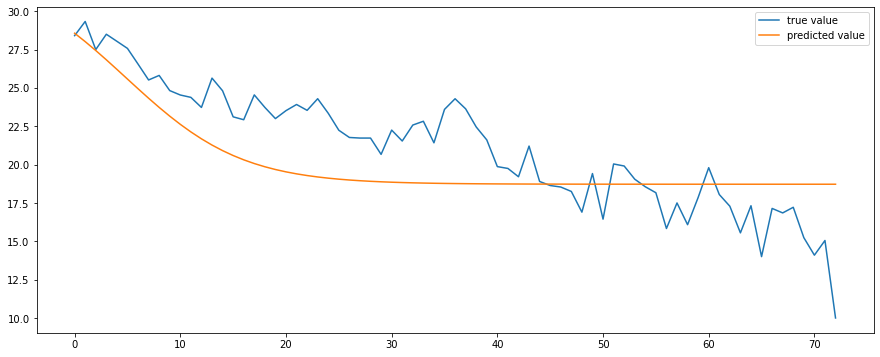

In [8]:
plt.figure(figsize=(15,6))
#plt.plot(day_new,temp_test[:50],label ='input')
plt.plot(day_new,out[2],label = 'true value')
plt.plot(day_new,out[3],label = 'predicted value')
plt.legend()
plt.show()